In [121]:
import torch
import torch.nn as nn
import yaml
import os

from models import MaskedAutoencoderViT
from dataloader import SpatioTemporalDataset, get_loader
from main import getpaths
from torch import optim
from tqdm import tqdm

In [122]:
save_dir_path = 'Results'
run_name = 'first_pulse_only'
save_path = os.path.join(save_dir_path, run_name)
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [123]:
net = MaskedAutoencoderViT(img_size = 256,
                           patch_size = 16,
                           in_chans = 600,
                           depth = 2,
                           num_heads = 2,
                           decoder_depth = 2,
                           decoder_num_heads = 2,
                           mlp_ratio = 4,
                           embed_dim = 128,
                           decoder_embed_dim = 64)

In [124]:
config_path = 'config.yaml'
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)
trainfol_path, valfol_path = getpaths(config, mode='train')
testfol_path = getpaths(config, mode='test')

# Get the dataloader for each of the train valid and test sets
train_dataset, train_loader = get_loader(config, trainfol_path, mode='train')
val_dataset, val_loader = get_loader(config, valfol_path, mode='valid')
test_dataset, test_loader = get_loader(config, testfol_path, mode='test')

print(f"length of train_dataset: {len(train_dataset)}")
print(f"length of train_loader: {len(train_loader)}")
print("\n")
print(f"length of val_dataset: {len(val_dataset)}")
print(f"length of val_loader: {len(val_loader)}")
print("\n")
print(f"length of test_dataset: {len(test_dataset)}")
print(f"length of test_loader: {len(test_loader)}")
print("\n")
train_iter = iter(train_loader)
inp_vid, tar_img, tar_pls = next(train_iter)
print(f"Shape of input video: {inp_vid.shape}")

length of train_dataset: 920
length of train_loader: 230


length of val_dataset: 240
length of val_loader: 60


length of test_dataset: 200
length of test_loader: 200


Shape of input video: torch.Size([4, 1, 600, 256, 256])


In [8]:
240/(920+240)

0.20689655172413793

In [125]:
device='cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.L1Loss()
lr = config['training_parameters']['learning_rate']
#num_epochs = config['training_parameters']['epochs']
num_epochs = 100
batch_size = config['training_parameters']['batch_size']
optimizer = optim.Adam(net.parameters(), lr)

In [144]:
batch_size

4

In [126]:
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    net.train()
    total_loss = 0; val_loss = 0
    for batch_idx, (inp_vid, tar_img, tar_pls) in enumerate(train_loader):
        
        optimizer.zero_grad()
        
        inp_vid, tar_img, tar_pls = inp_vid.to(device), tar_img.to(device), tar_pls.to(device)
        
        out_vid = net(inp_vid)
        
        out_img = out_vid.sum(dim=2, keepdim=True).squeeze(1).squeeze(1)
        out_pls = out_vid.sum(dim=[3,4], keepdim=True).squeeze(1).squeeze(2).squeeze(2)
        
        loss_img = criterion(out_img, tar_img)
        loss_pls = criterion(out_pls, tar_pls)
        
        #loss = loss_img# + 0.5 * loss_pls
        loss = loss_pls
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        print(f"Epoch: {epoch+1}, batch_id: {batch_idx+1}, batch train loss: {loss.item()}")
        print("\n")
    
    train_losses.append(total_loss/len(train_loader))
    print(f"Epoch: {epoch + 1}/ {num_epochs}, Loss: {total_loss/len(train_loader)}")
    print("-"*50)
    print("\n")
    
    net.eval()
    with torch.no_grad():
        for inp_vid, tar_img, tar_pls in tqdm(val_loader):
            inp_vid, tar_img, tar_pls = inp_vid.to(device), tar_img.to(device), tar_pls.to(device)
            out_vid = net(inp_vid)
            out_img = out_vid.sum(dim=2, keepdim=True).squeeze(1).squeeze(1)
            out_pls = out_vid.sum(dim=[3, 4], keepdim=True).squeeze(1).squeeze(2).squeeze(2)
            loss_img = criterion(out_img, tar_img)
            loss_pls = criterion(out_pls, tar_pls)
            #loss = loss_img#+ 0.5*loss_pls
            loss = loss_pls
            val_loss += loss.item()
        val_loss = val_loss/len(val_loader)
        val_losses.append(val_loss)
        print(f"Epoch: {epoch + 1} Validation Loss: {val_loss}")
        print("-"*50)
        print("\n")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epoch_path = f"{save_path}/chck_epoch_{epoch+1}.pt"
            torch.save({'epoch': epoch + 1,
                        'model_state_dict': net.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict()},
                         epoch_path)
            print(f"Model Saved")

Epoch: 1, batch_id: 1, batch train loss: 104.89038848876953


Epoch: 1, batch_id: 2, batch train loss: 202.65823364257812


Epoch: 1, batch_id: 3, batch train loss: 169.46939086914062


Epoch: 1, batch_id: 4, batch train loss: 82.0373306274414


Epoch: 1, batch_id: 5, batch train loss: 114.58906555175781


Epoch: 1, batch_id: 6, batch train loss: 115.80059814453125


Epoch: 1, batch_id: 7, batch train loss: 108.786376953125


Epoch: 1, batch_id: 8, batch train loss: 82.09578704833984


Epoch: 1, batch_id: 9, batch train loss: 75.38178253173828


Epoch: 1, batch_id: 10, batch train loss: 126.95855712890625


Epoch: 1, batch_id: 11, batch train loss: 74.158935546875


Epoch: 1, batch_id: 12, batch train loss: 91.63133239746094


Epoch: 1, batch_id: 13, batch train loss: 69.26919555664062


Epoch: 1, batch_id: 14, batch train loss: 102.65746307373047


Epoch: 1, batch_id: 15, batch train loss: 75.29608154296875


Epoch: 1, batch_id: 16, batch train loss: 58.589881896972656


Epoch: 1, bat

Epoch: 1, batch_id: 133, batch train loss: 28.306589126586914


Epoch: 1, batch_id: 134, batch train loss: 25.883506774902344


Epoch: 1, batch_id: 135, batch train loss: 29.050643920898438


Epoch: 1, batch_id: 136, batch train loss: 22.886396408081055


Epoch: 1, batch_id: 137, batch train loss: 23.169294357299805


Epoch: 1, batch_id: 138, batch train loss: 26.915855407714844


Epoch: 1, batch_id: 139, batch train loss: 23.03285789489746


Epoch: 1, batch_id: 140, batch train loss: 19.81321907043457


Epoch: 1, batch_id: 141, batch train loss: 19.823848724365234


Epoch: 1, batch_id: 142, batch train loss: 23.57306671142578


Epoch: 1, batch_id: 143, batch train loss: 24.698192596435547


Epoch: 1, batch_id: 144, batch train loss: 21.55986976623535


Epoch: 1, batch_id: 145, batch train loss: 19.375383377075195


Epoch: 1, batch_id: 146, batch train loss: 20.31365966796875


Epoch: 1, batch_id: 147, batch train loss: 20.16812515258789


Epoch: 1, batch_id: 148, batch train loss: 19.

100%|███████████████████████████████████████████| 60/60 [01:12<00:00,  1.21s/it]


Epoch: 1 Validation Loss: 17.599203888575236
--------------------------------------------------


Model Saved
Epoch: 2, batch_id: 1, batch train loss: 18.50062370300293


Epoch: 2, batch_id: 2, batch train loss: 16.80335235595703


Epoch: 2, batch_id: 3, batch train loss: 19.435453414916992


Epoch: 2, batch_id: 4, batch train loss: 19.247953414916992


Epoch: 2, batch_id: 5, batch train loss: 19.67225456237793


Epoch: 2, batch_id: 6, batch train loss: 15.629253387451172


Epoch: 2, batch_id: 7, batch train loss: 14.064713478088379


Epoch: 2, batch_id: 8, batch train loss: 15.421529769897461


Epoch: 2, batch_id: 9, batch train loss: 13.8352632522583


Epoch: 2, batch_id: 10, batch train loss: 15.193504333496094


Epoch: 2, batch_id: 11, batch train loss: 13.967073440551758


Epoch: 2, batch_id: 12, batch train loss: 13.685245513916016


Epoch: 2, batch_id: 13, batch train loss: 14.551739692687988


Epoch: 2, batch_id: 14, batch train loss: 22.25029182434082


Epoch: 2, batch_id: 15,

Epoch: 2, batch_id: 130, batch train loss: 15.1689453125


Epoch: 2, batch_id: 131, batch train loss: 17.35284996032715


Epoch: 2, batch_id: 132, batch train loss: 17.86240005493164


Epoch: 2, batch_id: 133, batch train loss: 17.053739547729492


Epoch: 2, batch_id: 134, batch train loss: 17.037025451660156


Epoch: 2, batch_id: 135, batch train loss: 12.954758644104004


Epoch: 2, batch_id: 136, batch train loss: 15.726191520690918


Epoch: 2, batch_id: 137, batch train loss: 15.490630149841309


Epoch: 2, batch_id: 138, batch train loss: 17.18354034423828


Epoch: 2, batch_id: 139, batch train loss: 17.986433029174805


Epoch: 2, batch_id: 140, batch train loss: 16.04725456237793


Epoch: 2, batch_id: 141, batch train loss: 24.12300682067871


Epoch: 2, batch_id: 142, batch train loss: 16.648962020874023


Epoch: 2, batch_id: 143, batch train loss: 18.496723175048828


Epoch: 2, batch_id: 144, batch train loss: 19.98267936706543


Epoch: 2, batch_id: 145, batch train loss: 15.96665

100%|███████████████████████████████████████████| 60/60 [01:08<00:00,  1.15s/it]


Epoch: 2 Validation Loss: 14.344892835617065
--------------------------------------------------


Model Saved
Epoch: 3, batch_id: 1, batch train loss: 13.9579496383667


Epoch: 3, batch_id: 2, batch train loss: 12.574519157409668


Epoch: 3, batch_id: 3, batch train loss: 16.54865074157715


Epoch: 3, batch_id: 4, batch train loss: 15.57947063446045


Epoch: 3, batch_id: 5, batch train loss: 14.233428001403809


Epoch: 3, batch_id: 6, batch train loss: 15.426046371459961


Epoch: 3, batch_id: 7, batch train loss: 12.521978378295898


Epoch: 3, batch_id: 8, batch train loss: 14.404775619506836


Epoch: 3, batch_id: 9, batch train loss: 16.92864990234375


Epoch: 3, batch_id: 10, batch train loss: 16.170515060424805


Epoch: 3, batch_id: 11, batch train loss: 16.1837100982666


Epoch: 3, batch_id: 12, batch train loss: 13.014446258544922


Epoch: 3, batch_id: 13, batch train loss: 16.539121627807617


Epoch: 3, batch_id: 14, batch train loss: 14.78126335144043


Epoch: 3, batch_id: 15, b

Epoch: 3, batch_id: 130, batch train loss: 12.69702434539795


Epoch: 3, batch_id: 131, batch train loss: 14.403122901916504


Epoch: 3, batch_id: 132, batch train loss: 15.06684398651123


Epoch: 3, batch_id: 133, batch train loss: 13.901076316833496


Epoch: 3, batch_id: 134, batch train loss: 11.798056602478027


Epoch: 3, batch_id: 135, batch train loss: 12.334857940673828


Epoch: 3, batch_id: 136, batch train loss: 15.915660858154297


Epoch: 3, batch_id: 137, batch train loss: 13.714735984802246


Epoch: 3, batch_id: 138, batch train loss: 14.705582618713379


Epoch: 3, batch_id: 139, batch train loss: 13.558640480041504


Epoch: 3, batch_id: 140, batch train loss: 16.79550552368164


Epoch: 3, batch_id: 141, batch train loss: 14.868380546569824


Epoch: 3, batch_id: 142, batch train loss: 15.277228355407715


Epoch: 3, batch_id: 143, batch train loss: 12.488822937011719


Epoch: 3, batch_id: 144, batch train loss: 12.61082649230957


Epoch: 3, batch_id: 145, batch train loss: 1

100%|███████████████████████████████████████████| 60/60 [01:07<00:00,  1.12s/it]

Epoch: 3 Validation Loss: 17.8206778049469
--------------------------------------------------




Epoch: 4, batch_id: 1, batch train loss: 16.540794372558594


Epoch: 4, batch_id: 2, batch train loss: 13.991341590881348


Epoch: 4, batch_id: 3, batch train loss: 12.954111099243164


Epoch: 4, batch_id: 4, batch train loss: 15.67642593383789


Epoch: 4, batch_id: 5, batch train loss: 10.656128883361816


Epoch: 4, batch_id: 6, batch train loss: 17.980562210083008


Epoch: 4, batch_id: 7, batch train loss: 17.6519718170166


Epoch: 4, batch_id: 8, batch train loss: 15.59237289428711


Epoch: 4, batch_id: 9, batch train loss: 19.54058837890625


Epoch: 4, batch_id: 10, batch train loss: 9.750265121459961


Epoch: 4, batch_id: 11, batch train loss: 16.84865379333496


Epoch: 4, batch_id: 12, batch train loss: 17.199247360229492


Epoch: 4, batch_id: 13, batch train loss: 14.705169677734375


Epoch: 4, batch_id: 14, batch train loss: 15.296826362609863


Epoch: 4, batch_id: 15, batch train loss: 14.09737491607666


Epoch: 4, batch_id: 16, batch train loss: 12.93443489074707


Epoch: 4, 

Epoch: 4, batch_id: 132, batch train loss: 10.350976943969727


Epoch: 4, batch_id: 133, batch train loss: 12.74935245513916


Epoch: 4, batch_id: 134, batch train loss: 12.573467254638672


Epoch: 4, batch_id: 135, batch train loss: 15.702153205871582


Epoch: 4, batch_id: 136, batch train loss: 12.060161590576172


Epoch: 4, batch_id: 137, batch train loss: 14.277579307556152


Epoch: 4, batch_id: 138, batch train loss: 12.690190315246582


Epoch: 4, batch_id: 139, batch train loss: 12.140525817871094


Epoch: 4, batch_id: 140, batch train loss: 12.869121551513672


Epoch: 4, batch_id: 141, batch train loss: 12.416086196899414


Epoch: 4, batch_id: 142, batch train loss: 13.345954895019531


Epoch: 4, batch_id: 143, batch train loss: 12.79466438293457


Epoch: 4, batch_id: 144, batch train loss: 12.78193187713623


Epoch: 4, batch_id: 145, batch train loss: 16.374183654785156


Epoch: 4, batch_id: 146, batch train loss: 13.039444923400879


Epoch: 4, batch_id: 147, batch train loss: 

100%|███████████████████████████████████████████| 60/60 [01:20<00:00,  1.34s/it]

Epoch: 4 Validation Loss: 14.682053836186727
--------------------------------------------------




Epoch: 5, batch_id: 1, batch train loss: 14.314596176147461


Epoch: 5, batch_id: 2, batch train loss: 16.03667449951172


Epoch: 5, batch_id: 3, batch train loss: 13.533051490783691


Epoch: 5, batch_id: 4, batch train loss: 15.491671562194824


Epoch: 5, batch_id: 5, batch train loss: 15.668813705444336


Epoch: 5, batch_id: 6, batch train loss: 14.679397583007812


Epoch: 5, batch_id: 7, batch train loss: 14.93045711517334


Epoch: 5, batch_id: 8, batch train loss: 11.965827941894531


Epoch: 5, batch_id: 9, batch train loss: 10.414770126342773


Epoch: 5, batch_id: 10, batch train loss: 10.798517227172852


Epoch: 5, batch_id: 11, batch train loss: 11.476304054260254


Epoch: 5, batch_id: 12, batch train loss: 11.411646842956543


Epoch: 5, batch_id: 13, batch train loss: 10.867806434631348


Epoch: 5, batch_id: 14, batch train loss: 11.841907501220703


Epoch: 5, batch_id: 15, batch train loss: 11.536568641662598


Epoch: 5, batch_id: 16, batch train loss: 12.476910591125488


Epo

Epoch: 5, batch_id: 132, batch train loss: 10.066192626953125


Epoch: 5, batch_id: 133, batch train loss: 12.257230758666992


Epoch: 5, batch_id: 134, batch train loss: 9.782296180725098


Epoch: 5, batch_id: 135, batch train loss: 11.759052276611328


Epoch: 5, batch_id: 136, batch train loss: 9.221814155578613


Epoch: 5, batch_id: 137, batch train loss: 8.53514575958252


Epoch: 5, batch_id: 138, batch train loss: 9.124364852905273


Epoch: 5, batch_id: 139, batch train loss: 9.423257827758789


Epoch: 5, batch_id: 140, batch train loss: 9.598196983337402


Epoch: 5, batch_id: 141, batch train loss: 9.32651424407959


Epoch: 5, batch_id: 142, batch train loss: 10.049163818359375


Epoch: 5, batch_id: 143, batch train loss: 9.96646499633789


Epoch: 5, batch_id: 144, batch train loss: 9.942809104919434


Epoch: 5, batch_id: 145, batch train loss: 11.419808387756348


Epoch: 5, batch_id: 146, batch train loss: 10.916814804077148


Epoch: 5, batch_id: 147, batch train loss: 10.534512

100%|███████████████████████████████████████████| 60/60 [01:20<00:00,  1.34s/it]


Epoch: 5 Validation Loss: 13.361890681584676
--------------------------------------------------


Model Saved
Epoch: 6, batch_id: 1, batch train loss: 13.842171669006348


Epoch: 6, batch_id: 2, batch train loss: 12.201163291931152


Epoch: 6, batch_id: 3, batch train loss: 10.711570739746094


Epoch: 6, batch_id: 4, batch train loss: 15.600177764892578


Epoch: 6, batch_id: 5, batch train loss: 12.92720890045166


Epoch: 6, batch_id: 6, batch train loss: 13.669576644897461


Epoch: 6, batch_id: 7, batch train loss: 11.288217544555664


Epoch: 6, batch_id: 8, batch train loss: 10.91179084777832


Epoch: 6, batch_id: 9, batch train loss: 10.841554641723633


Epoch: 6, batch_id: 10, batch train loss: 12.321725845336914


Epoch: 6, batch_id: 11, batch train loss: 10.709238052368164


Epoch: 6, batch_id: 12, batch train loss: 11.314872741699219


Epoch: 6, batch_id: 13, batch train loss: 11.450203895568848


Epoch: 6, batch_id: 14, batch train loss: 9.658965110778809


Epoch: 6, batch_id: 

Epoch: 6, batch_id: 130, batch train loss: 11.615589141845703


Epoch: 6, batch_id: 131, batch train loss: 10.80146312713623


Epoch: 6, batch_id: 132, batch train loss: 11.729435920715332


Epoch: 6, batch_id: 133, batch train loss: 10.16845989227295


Epoch: 6, batch_id: 134, batch train loss: 9.182235717773438


Epoch: 6, batch_id: 135, batch train loss: 8.378554344177246


Epoch: 6, batch_id: 136, batch train loss: 8.221359252929688


Epoch: 6, batch_id: 137, batch train loss: 8.998390197753906


Epoch: 6, batch_id: 138, batch train loss: 11.273768424987793


Epoch: 6, batch_id: 139, batch train loss: 8.995859146118164


Epoch: 6, batch_id: 140, batch train loss: 11.194902420043945


Epoch: 6, batch_id: 141, batch train loss: 9.92624568939209


Epoch: 6, batch_id: 142, batch train loss: 10.151052474975586


Epoch: 6, batch_id: 143, batch train loss: 10.174970626831055


Epoch: 6, batch_id: 144, batch train loss: 10.538946151733398


Epoch: 6, batch_id: 145, batch train loss: 10.541

100%|███████████████████████████████████████████| 60/60 [01:24<00:00,  1.41s/it]


Epoch: 6 Validation Loss: 9.812534189224243
--------------------------------------------------


Model Saved
Epoch: 7, batch_id: 1, batch train loss: 9.76582145690918


Epoch: 7, batch_id: 2, batch train loss: 9.054445266723633


Epoch: 7, batch_id: 3, batch train loss: 10.52541732788086


Epoch: 7, batch_id: 4, batch train loss: 11.221182823181152


Epoch: 7, batch_id: 5, batch train loss: 12.834033966064453


Epoch: 7, batch_id: 6, batch train loss: 11.582621574401855


Epoch: 7, batch_id: 7, batch train loss: 9.144611358642578


Epoch: 7, batch_id: 8, batch train loss: 9.75191879272461


Epoch: 7, batch_id: 9, batch train loss: 11.864744186401367


Epoch: 7, batch_id: 10, batch train loss: 10.646404266357422


Epoch: 7, batch_id: 11, batch train loss: 10.218894958496094


Epoch: 7, batch_id: 12, batch train loss: 10.241374969482422


Epoch: 7, batch_id: 13, batch train loss: 10.298981666564941


Epoch: 7, batch_id: 14, batch train loss: 10.435171127319336


Epoch: 7, batch_id: 15, b

Epoch: 7, batch_id: 130, batch train loss: 12.535110473632812


Epoch: 7, batch_id: 131, batch train loss: 9.937536239624023


Epoch: 7, batch_id: 132, batch train loss: 10.179368019104004


Epoch: 7, batch_id: 133, batch train loss: 10.21071720123291


Epoch: 7, batch_id: 134, batch train loss: 11.171727180480957


Epoch: 7, batch_id: 135, batch train loss: 11.129510879516602


Epoch: 7, batch_id: 136, batch train loss: 9.86097526550293


Epoch: 7, batch_id: 137, batch train loss: 10.089547157287598


Epoch: 7, batch_id: 138, batch train loss: 9.726431846618652


Epoch: 7, batch_id: 139, batch train loss: 9.119462013244629


Epoch: 7, batch_id: 140, batch train loss: 9.802051544189453


Epoch: 7, batch_id: 141, batch train loss: 8.927298545837402


Epoch: 7, batch_id: 142, batch train loss: 11.326200485229492


Epoch: 7, batch_id: 143, batch train loss: 9.097707748413086


Epoch: 7, batch_id: 144, batch train loss: 11.132262229919434


Epoch: 7, batch_id: 145, batch train loss: 10.365

100%|███████████████████████████████████████████| 60/60 [01:11<00:00,  1.19s/it]


Epoch: 7 Validation Loss: 8.753355503082275
--------------------------------------------------


Model Saved
Epoch: 8, batch_id: 1, batch train loss: 8.328721046447754


Epoch: 8, batch_id: 2, batch train loss: 8.657286643981934


Epoch: 8, batch_id: 3, batch train loss: 7.567065238952637


Epoch: 8, batch_id: 4, batch train loss: 7.346222400665283


Epoch: 8, batch_id: 5, batch train loss: 9.742795944213867


Epoch: 8, batch_id: 6, batch train loss: 9.18380355834961


Epoch: 8, batch_id: 7, batch train loss: 9.15117359161377


Epoch: 8, batch_id: 8, batch train loss: 9.112744331359863


Epoch: 8, batch_id: 9, batch train loss: 8.903450965881348


Epoch: 8, batch_id: 10, batch train loss: 11.205381393432617


Epoch: 8, batch_id: 11, batch train loss: 8.013955116271973


Epoch: 8, batch_id: 12, batch train loss: 10.00457763671875


Epoch: 8, batch_id: 13, batch train loss: 10.206933975219727


Epoch: 8, batch_id: 14, batch train loss: 9.370221138000488


Epoch: 8, batch_id: 15, batch tr

Epoch: 8, batch_id: 131, batch train loss: 7.6654582023620605


Epoch: 8, batch_id: 132, batch train loss: 6.832054138183594


Epoch: 8, batch_id: 133, batch train loss: 6.373126029968262


Epoch: 8, batch_id: 134, batch train loss: 7.166228771209717


Epoch: 8, batch_id: 135, batch train loss: 7.269094944000244


Epoch: 8, batch_id: 136, batch train loss: 7.474576950073242


Epoch: 8, batch_id: 137, batch train loss: 7.2413411140441895


Epoch: 8, batch_id: 138, batch train loss: 9.9292631149292


Epoch: 8, batch_id: 139, batch train loss: 8.091533660888672


Epoch: 8, batch_id: 140, batch train loss: 8.723265647888184


Epoch: 8, batch_id: 141, batch train loss: 7.842491149902344


Epoch: 8, batch_id: 142, batch train loss: 8.585479736328125


Epoch: 8, batch_id: 143, batch train loss: 8.001412391662598


Epoch: 8, batch_id: 144, batch train loss: 7.631066799163818


Epoch: 8, batch_id: 145, batch train loss: 9.34191608428955


Epoch: 8, batch_id: 146, batch train loss: 7.02760982513

100%|███████████████████████████████████████████| 60/60 [01:09<00:00,  1.16s/it]


Epoch: 8 Validation Loss: 6.705915959676107
--------------------------------------------------


Model Saved
Epoch: 9, batch_id: 1, batch train loss: 6.1224470138549805


Epoch: 9, batch_id: 2, batch train loss: 9.958592414855957


Epoch: 9, batch_id: 3, batch train loss: 10.567307472229004


Epoch: 9, batch_id: 4, batch train loss: 6.8518385887146


Epoch: 9, batch_id: 5, batch train loss: 12.829977035522461


Epoch: 9, batch_id: 6, batch train loss: 8.784649848937988


Epoch: 9, batch_id: 7, batch train loss: 8.455814361572266


Epoch: 9, batch_id: 8, batch train loss: 13.564248085021973


Epoch: 9, batch_id: 9, batch train loss: 11.0780029296875


Epoch: 9, batch_id: 10, batch train loss: 12.744144439697266


Epoch: 9, batch_id: 11, batch train loss: 15.14136028289795


Epoch: 9, batch_id: 12, batch train loss: 11.071267127990723


Epoch: 9, batch_id: 13, batch train loss: 9.318779945373535


Epoch: 9, batch_id: 14, batch train loss: 11.989032745361328


Epoch: 9, batch_id: 15, batc

Epoch: 9, batch_id: 131, batch train loss: 9.426057815551758


Epoch: 9, batch_id: 132, batch train loss: 5.961423873901367


Epoch: 9, batch_id: 133, batch train loss: 10.826396942138672


Epoch: 9, batch_id: 134, batch train loss: 14.250235557556152


Epoch: 9, batch_id: 135, batch train loss: 10.068415641784668


Epoch: 9, batch_id: 136, batch train loss: 9.791580200195312


Epoch: 9, batch_id: 137, batch train loss: 12.048093795776367


Epoch: 9, batch_id: 138, batch train loss: 12.436766624450684


Epoch: 9, batch_id: 139, batch train loss: 8.477807998657227


Epoch: 9, batch_id: 140, batch train loss: 11.412707328796387


Epoch: 9, batch_id: 141, batch train loss: 7.394426345825195


Epoch: 9, batch_id: 142, batch train loss: 5.0996222496032715


Epoch: 9, batch_id: 143, batch train loss: 8.246685981750488


Epoch: 9, batch_id: 144, batch train loss: 5.760314464569092


Epoch: 9, batch_id: 145, batch train loss: 6.380195140838623


Epoch: 9, batch_id: 146, batch train loss: 7.064

100%|███████████████████████████████████████████| 60/60 [01:22<00:00,  1.38s/it]


Epoch: 9 Validation Loss: 5.612189320723216
--------------------------------------------------


Model Saved
Epoch: 10, batch_id: 1, batch train loss: 5.922604084014893


Epoch: 10, batch_id: 2, batch train loss: 6.12603759765625


Epoch: 10, batch_id: 3, batch train loss: 8.988187789916992


Epoch: 10, batch_id: 4, batch train loss: 5.4202728271484375


Epoch: 10, batch_id: 5, batch train loss: 6.294537544250488


Epoch: 10, batch_id: 6, batch train loss: 6.100890159606934


Epoch: 10, batch_id: 7, batch train loss: 3.840594530105591


Epoch: 10, batch_id: 8, batch train loss: 4.895994663238525


Epoch: 10, batch_id: 9, batch train loss: 4.451368808746338


Epoch: 10, batch_id: 10, batch train loss: 3.594289541244507


Epoch: 10, batch_id: 11, batch train loss: 7.0105485916137695


Epoch: 10, batch_id: 12, batch train loss: 3.4069929122924805


Epoch: 10, batch_id: 13, batch train loss: 6.95414400100708


Epoch: 10, batch_id: 14, batch train loss: 3.6881885528564453


Epoch: 10, batch

Epoch: 10, batch_id: 129, batch train loss: 2.184415340423584


Epoch: 10, batch_id: 130, batch train loss: 5.189210414886475


Epoch: 10, batch_id: 131, batch train loss: 3.9873721599578857


Epoch: 10, batch_id: 132, batch train loss: 3.9479737281799316


Epoch: 10, batch_id: 133, batch train loss: 3.1194355487823486


Epoch: 10, batch_id: 134, batch train loss: 3.479494333267212


Epoch: 10, batch_id: 135, batch train loss: 3.901698350906372


Epoch: 10, batch_id: 136, batch train loss: 6.012761116027832


Epoch: 10, batch_id: 137, batch train loss: 5.117268085479736


Epoch: 10, batch_id: 138, batch train loss: 5.481321811676025


Epoch: 10, batch_id: 139, batch train loss: 7.356706619262695


Epoch: 10, batch_id: 140, batch train loss: 4.033085346221924


Epoch: 10, batch_id: 141, batch train loss: 6.4187469482421875


Epoch: 10, batch_id: 142, batch train loss: 8.935813903808594


Epoch: 10, batch_id: 143, batch train loss: 3.751617908477783


Epoch: 10, batch_id: 144, batch trai

100%|███████████████████████████████████████████| 60/60 [01:10<00:00,  1.18s/it]


Epoch: 10 Validation Loss: 4.348496870199839
--------------------------------------------------


Model Saved
Epoch: 11, batch_id: 1, batch train loss: 5.570269584655762


Epoch: 11, batch_id: 2, batch train loss: 3.4926257133483887


Epoch: 11, batch_id: 3, batch train loss: 3.7084925174713135


Epoch: 11, batch_id: 4, batch train loss: 3.4919092655181885


Epoch: 11, batch_id: 5, batch train loss: 2.941817283630371


Epoch: 11, batch_id: 6, batch train loss: 3.1021571159362793


Epoch: 11, batch_id: 7, batch train loss: 3.429577589035034


Epoch: 11, batch_id: 8, batch train loss: 2.7070631980895996


Epoch: 11, batch_id: 9, batch train loss: 2.6202828884124756


Epoch: 11, batch_id: 10, batch train loss: 4.27875280380249


Epoch: 11, batch_id: 11, batch train loss: 5.851746559143066


Epoch: 11, batch_id: 12, batch train loss: 5.170464992523193


Epoch: 11, batch_id: 13, batch train loss: 4.9231486320495605


Epoch: 11, batch_id: 14, batch train loss: 6.528799057006836


Epoch: 11, 

Epoch: 11, batch_id: 129, batch train loss: 3.6759676933288574


Epoch: 11, batch_id: 130, batch train loss: 3.7916581630706787


Epoch: 11, batch_id: 131, batch train loss: 4.518655300140381


Epoch: 11, batch_id: 132, batch train loss: 4.130573749542236


Epoch: 11, batch_id: 133, batch train loss: 4.510629653930664


Epoch: 11, batch_id: 134, batch train loss: 3.6502938270568848


Epoch: 11, batch_id: 135, batch train loss: 3.5170552730560303


Epoch: 11, batch_id: 136, batch train loss: 6.1289215087890625


Epoch: 11, batch_id: 137, batch train loss: 4.5503830909729


Epoch: 11, batch_id: 138, batch train loss: 5.301898002624512


Epoch: 11, batch_id: 139, batch train loss: 7.047236919403076


Epoch: 11, batch_id: 140, batch train loss: 4.820252895355225


Epoch: 11, batch_id: 141, batch train loss: 4.729126453399658


Epoch: 11, batch_id: 142, batch train loss: 5.0441789627075195


Epoch: 11, batch_id: 143, batch train loss: 3.260253667831421


Epoch: 11, batch_id: 144, batch trai

100%|███████████████████████████████████████████| 60/60 [01:12<00:00,  1.21s/it]


Epoch: 11 Validation Loss: 3.9580071171124778
--------------------------------------------------


Model Saved
Epoch: 12, batch_id: 1, batch train loss: 5.13341760635376


Epoch: 12, batch_id: 2, batch train loss: 3.11124849319458


Epoch: 12, batch_id: 3, batch train loss: 3.1264657974243164


Epoch: 12, batch_id: 4, batch train loss: 4.79305362701416


Epoch: 12, batch_id: 5, batch train loss: 4.102834701538086


Epoch: 12, batch_id: 6, batch train loss: 3.981771945953369


Epoch: 12, batch_id: 7, batch train loss: 5.059957504272461


Epoch: 12, batch_id: 8, batch train loss: 3.4908320903778076


Epoch: 12, batch_id: 9, batch train loss: 4.009424686431885


Epoch: 12, batch_id: 10, batch train loss: 3.8432397842407227


Epoch: 12, batch_id: 11, batch train loss: 4.4713592529296875


Epoch: 12, batch_id: 12, batch train loss: 5.258094310760498


Epoch: 12, batch_id: 13, batch train loss: 3.0652830600738525


Epoch: 12, batch_id: 14, batch train loss: 3.0501341819763184


Epoch: 12, ba

Epoch: 12, batch_id: 129, batch train loss: 3.775566816329956


Epoch: 12, batch_id: 130, batch train loss: 4.6294708251953125


Epoch: 12, batch_id: 131, batch train loss: 3.013702869415283


Epoch: 12, batch_id: 132, batch train loss: 2.943655490875244


Epoch: 12, batch_id: 133, batch train loss: 5.374241352081299


Epoch: 12, batch_id: 134, batch train loss: 5.259706020355225


Epoch: 12, batch_id: 135, batch train loss: 2.6224868297576904


Epoch: 12, batch_id: 136, batch train loss: 5.362480640411377


Epoch: 12, batch_id: 137, batch train loss: 5.859752655029297


Epoch: 12, batch_id: 138, batch train loss: 7.373481273651123


Epoch: 12, batch_id: 139, batch train loss: 3.4457600116729736


Epoch: 12, batch_id: 140, batch train loss: 5.265567302703857


Epoch: 12, batch_id: 141, batch train loss: 5.044616222381592


Epoch: 12, batch_id: 142, batch train loss: 3.049919366836548


Epoch: 12, batch_id: 143, batch train loss: 4.134979248046875


Epoch: 12, batch_id: 144, batch train

100%|███████████████████████████████████████████| 60/60 [01:12<00:00,  1.20s/it]


Epoch: 12 Validation Loss: 3.2271383961041766
--------------------------------------------------


Model Saved
Epoch: 13, batch_id: 1, batch train loss: 3.1471025943756104


Epoch: 13, batch_id: 2, batch train loss: 2.801227331161499


Epoch: 13, batch_id: 3, batch train loss: 1.985225796699524


Epoch: 13, batch_id: 4, batch train loss: 2.5276663303375244


Epoch: 13, batch_id: 5, batch train loss: 3.1071252822875977


Epoch: 13, batch_id: 6, batch train loss: 2.7378287315368652


Epoch: 13, batch_id: 7, batch train loss: 3.3228085041046143


Epoch: 13, batch_id: 8, batch train loss: 2.769381046295166


Epoch: 13, batch_id: 9, batch train loss: 2.502716064453125


Epoch: 13, batch_id: 10, batch train loss: 2.5027549266815186


Epoch: 13, batch_id: 11, batch train loss: 2.277475595474243


Epoch: 13, batch_id: 12, batch train loss: 3.0889854431152344


Epoch: 13, batch_id: 13, batch train loss: 4.517601490020752


Epoch: 13, batch_id: 14, batch train loss: 3.352667808532715


Epoch: 13

Epoch: 13, batch_id: 129, batch train loss: 2.8731272220611572


Epoch: 13, batch_id: 130, batch train loss: 3.549069404602051


Epoch: 13, batch_id: 131, batch train loss: 4.188683032989502


Epoch: 13, batch_id: 132, batch train loss: 3.32181453704834


Epoch: 13, batch_id: 133, batch train loss: 3.742927312850952


Epoch: 13, batch_id: 134, batch train loss: 2.8329031467437744


Epoch: 13, batch_id: 135, batch train loss: 3.914318799972534


Epoch: 13, batch_id: 136, batch train loss: 4.960427761077881


Epoch: 13, batch_id: 137, batch train loss: 2.8594448566436768


Epoch: 13, batch_id: 138, batch train loss: 2.4580957889556885


Epoch: 13, batch_id: 139, batch train loss: 2.9014647006988525


Epoch: 13, batch_id: 140, batch train loss: 3.7084851264953613


Epoch: 13, batch_id: 141, batch train loss: 2.572604179382324


Epoch: 13, batch_id: 142, batch train loss: 4.668200492858887


Epoch: 13, batch_id: 143, batch train loss: 4.281877517700195


Epoch: 13, batch_id: 144, batch tra

100%|███████████████████████████████████████████| 60/60 [01:08<00:00,  1.14s/it]

Epoch: 13 Validation Loss: 3.7172409693400064
--------------------------------------------------




Epoch: 14, batch_id: 1, batch train loss: 3.969792127609253


Epoch: 14, batch_id: 2, batch train loss: 4.200296401977539


Epoch: 14, batch_id: 3, batch train loss: 5.832326412200928


Epoch: 14, batch_id: 4, batch train loss: 7.770968437194824


Epoch: 14, batch_id: 5, batch train loss: 6.874797344207764


Epoch: 14, batch_id: 6, batch train loss: 2.954511880874634


Epoch: 14, batch_id: 7, batch train loss: 2.01332950592041


Epoch: 14, batch_id: 8, batch train loss: 4.546313762664795


Epoch: 14, batch_id: 9, batch train loss: 2.960552453994751


Epoch: 14, batch_id: 10, batch train loss: 3.3703155517578125


Epoch: 14, batch_id: 11, batch train loss: 3.8964781761169434


Epoch: 14, batch_id: 12, batch train loss: 2.637962579727173


Epoch: 14, batch_id: 13, batch train loss: 2.6631994247436523


Epoch: 14, batch_id: 14, batch train loss: 4.083061695098877


Epoch: 14, batch_id: 15, batch train loss: 3.1330199241638184


Epoch: 14, batch_id: 16, batch train loss: 2.7986249923706055

Epoch: 14, batch_id: 131, batch train loss: 5.1401166915893555


Epoch: 14, batch_id: 132, batch train loss: 3.6204304695129395


Epoch: 14, batch_id: 133, batch train loss: 3.867079973220825


Epoch: 14, batch_id: 134, batch train loss: 2.791055202484131


Epoch: 14, batch_id: 135, batch train loss: 3.1226792335510254


Epoch: 14, batch_id: 136, batch train loss: 3.968981981277466


Epoch: 14, batch_id: 137, batch train loss: 2.936495542526245


Epoch: 14, batch_id: 138, batch train loss: 3.878037929534912


Epoch: 14, batch_id: 139, batch train loss: 3.6825666427612305


Epoch: 14, batch_id: 140, batch train loss: 3.357590436935425


Epoch: 14, batch_id: 141, batch train loss: 6.187985420227051


Epoch: 14, batch_id: 142, batch train loss: 6.585515022277832


Epoch: 14, batch_id: 143, batch train loss: 4.383633613586426


Epoch: 14, batch_id: 144, batch train loss: 5.3630146980285645


Epoch: 14, batch_id: 145, batch train loss: 7.415513515472412


Epoch: 14, batch_id: 146, batch tra

100%|███████████████████████████████████████████| 60/60 [01:08<00:00,  1.14s/it]


Epoch: 14 Validation Loss: 2.729197108745575
--------------------------------------------------


Model Saved
Epoch: 15, batch_id: 1, batch train loss: 2.7759194374084473


Epoch: 15, batch_id: 2, batch train loss: 2.1235618591308594


Epoch: 15, batch_id: 3, batch train loss: 2.593287706375122


Epoch: 15, batch_id: 4, batch train loss: 2.6705055236816406


Epoch: 15, batch_id: 5, batch train loss: 3.2541604042053223


Epoch: 15, batch_id: 6, batch train loss: 3.5921623706817627


Epoch: 15, batch_id: 7, batch train loss: 2.5641236305236816


Epoch: 15, batch_id: 8, batch train loss: 3.2316179275512695


Epoch: 15, batch_id: 9, batch train loss: 2.530048131942749


Epoch: 15, batch_id: 10, batch train loss: 2.833421468734741


Epoch: 15, batch_id: 11, batch train loss: 2.43534255027771


Epoch: 15, batch_id: 12, batch train loss: 3.702047824859619


Epoch: 15, batch_id: 13, batch train loss: 2.3103890419006348


Epoch: 15, batch_id: 14, batch train loss: 2.7821381092071533


Epoch: 15

Epoch: 15, batch_id: 129, batch train loss: 4.165029525756836


Epoch: 15, batch_id: 130, batch train loss: 2.2356131076812744


Epoch: 15, batch_id: 131, batch train loss: 3.515831708908081


Epoch: 15, batch_id: 132, batch train loss: 2.9311397075653076


Epoch: 15, batch_id: 133, batch train loss: 2.9695334434509277


Epoch: 15, batch_id: 134, batch train loss: 3.138355016708374


Epoch: 15, batch_id: 135, batch train loss: 1.965492606163025


Epoch: 15, batch_id: 136, batch train loss: 3.5639867782592773


Epoch: 15, batch_id: 137, batch train loss: 2.831486701965332


Epoch: 15, batch_id: 138, batch train loss: 3.3852739334106445


Epoch: 15, batch_id: 139, batch train loss: 2.954543113708496


Epoch: 15, batch_id: 140, batch train loss: 3.5502803325653076


Epoch: 15, batch_id: 141, batch train loss: 3.198444128036499


Epoch: 15, batch_id: 142, batch train loss: 3.680905342102051


Epoch: 15, batch_id: 143, batch train loss: 3.996607780456543


Epoch: 15, batch_id: 144, batch tr

100%|███████████████████████████████████████████| 60/60 [01:08<00:00,  1.14s/it]

Epoch: 15 Validation Loss: 3.4356536050637563
--------------------------------------------------




Epoch: 16, batch_id: 1, batch train loss: 2.3229739665985107


Epoch: 16, batch_id: 2, batch train loss: 3.0948281288146973


Epoch: 16, batch_id: 3, batch train loss: 6.3228912353515625


Epoch: 16, batch_id: 4, batch train loss: 3.0437088012695312


Epoch: 16, batch_id: 5, batch train loss: 3.8353707790374756


Epoch: 16, batch_id: 6, batch train loss: 2.886505603790283


Epoch: 16, batch_id: 7, batch train loss: 2.855360984802246


Epoch: 16, batch_id: 8, batch train loss: 3.671184778213501


Epoch: 16, batch_id: 9, batch train loss: 2.4724044799804688


Epoch: 16, batch_id: 10, batch train loss: 2.8891663551330566


Epoch: 16, batch_id: 11, batch train loss: 2.7196426391601562


Epoch: 16, batch_id: 12, batch train loss: 2.8302721977233887


Epoch: 16, batch_id: 13, batch train loss: 2.849461555480957


Epoch: 16, batch_id: 14, batch train loss: 2.7067642211914062


Epoch: 16, batch_id: 15, batch train loss: 2.7893595695495605


Epoch: 16, batch_id: 16, batch train loss: 2.83459401

Epoch: 16, batch_id: 130, batch train loss: 5.821873188018799


Epoch: 16, batch_id: 131, batch train loss: 4.332984447479248


Epoch: 16, batch_id: 132, batch train loss: 4.307353973388672


Epoch: 16, batch_id: 133, batch train loss: 6.879479885101318


Epoch: 16, batch_id: 134, batch train loss: 3.831247568130493


Epoch: 16, batch_id: 135, batch train loss: 3.7325692176818848


Epoch: 16, batch_id: 136, batch train loss: 5.5204315185546875


Epoch: 16, batch_id: 137, batch train loss: 4.331664085388184


Epoch: 16, batch_id: 138, batch train loss: 3.468914747238159


Epoch: 16, batch_id: 139, batch train loss: 4.414973258972168


Epoch: 16, batch_id: 140, batch train loss: 2.2487680912017822


Epoch: 16, batch_id: 141, batch train loss: 3.598567008972168


Epoch: 16, batch_id: 142, batch train loss: 3.277104377746582


Epoch: 16, batch_id: 143, batch train loss: 3.2577409744262695


Epoch: 16, batch_id: 144, batch train loss: 2.6932075023651123


Epoch: 16, batch_id: 145, batch tra

100%|███████████████████████████████████████████| 60/60 [01:10<00:00,  1.17s/it]

Epoch: 16 Validation Loss: 3.983133296171824
--------------------------------------------------




Epoch: 17, batch_id: 1, batch train loss: 4.865224838256836


Epoch: 17, batch_id: 2, batch train loss: 3.5249691009521484


Epoch: 17, batch_id: 3, batch train loss: 4.784583568572998


Epoch: 17, batch_id: 4, batch train loss: 4.3647942543029785


Epoch: 17, batch_id: 5, batch train loss: 2.7942097187042236


Epoch: 17, batch_id: 6, batch train loss: 4.176015853881836


Epoch: 17, batch_id: 7, batch train loss: 4.226599216461182


Epoch: 17, batch_id: 8, batch train loss: 2.20378041267395


Epoch: 17, batch_id: 9, batch train loss: 2.2968153953552246


Epoch: 17, batch_id: 10, batch train loss: 2.831245183944702


Epoch: 17, batch_id: 11, batch train loss: 4.731849193572998


Epoch: 17, batch_id: 12, batch train loss: 2.684161901473999


Epoch: 17, batch_id: 13, batch train loss: 2.5134918689727783


Epoch: 17, batch_id: 14, batch train loss: 2.617142677307129


Epoch: 17, batch_id: 15, batch train loss: 2.353696346282959


Epoch: 17, batch_id: 16, batch train loss: 2.938817024230957

Epoch: 17, batch_id: 130, batch train loss: 3.0356132984161377


Epoch: 17, batch_id: 131, batch train loss: 4.199850082397461


Epoch: 17, batch_id: 132, batch train loss: 2.270470142364502


Epoch: 17, batch_id: 133, batch train loss: 4.581705570220947


Epoch: 17, batch_id: 134, batch train loss: 4.321075916290283


Epoch: 17, batch_id: 135, batch train loss: 2.605677604675293


Epoch: 17, batch_id: 136, batch train loss: 4.484565734863281


Epoch: 17, batch_id: 137, batch train loss: 6.338757514953613


Epoch: 17, batch_id: 138, batch train loss: 1.8769718408584595


Epoch: 17, batch_id: 139, batch train loss: 3.3786916732788086


Epoch: 17, batch_id: 140, batch train loss: 5.248526573181152


Epoch: 17, batch_id: 141, batch train loss: 3.000206470489502


Epoch: 17, batch_id: 142, batch train loss: 3.346672773361206


Epoch: 17, batch_id: 143, batch train loss: 2.442608594894409


Epoch: 17, batch_id: 144, batch train loss: 1.8772413730621338


Epoch: 17, batch_id: 145, batch trai

100%|███████████████████████████████████████████| 60/60 [01:09<00:00,  1.16s/it]

Epoch: 17 Validation Loss: 2.818667697906494
--------------------------------------------------




Epoch: 18, batch_id: 1, batch train loss: 2.7976834774017334


Epoch: 18, batch_id: 2, batch train loss: 2.4595773220062256


Epoch: 18, batch_id: 3, batch train loss: 2.617309331893921


Epoch: 18, batch_id: 4, batch train loss: 2.446594476699829


Epoch: 18, batch_id: 5, batch train loss: 2.3081648349761963


Epoch: 18, batch_id: 6, batch train loss: 3.345397472381592


Epoch: 18, batch_id: 7, batch train loss: 2.3956711292266846


Epoch: 18, batch_id: 8, batch train loss: 3.1350228786468506


Epoch: 18, batch_id: 9, batch train loss: 2.8234121799468994


Epoch: 18, batch_id: 10, batch train loss: 2.8713021278381348


Epoch: 18, batch_id: 11, batch train loss: 2.2205045223236084


Epoch: 18, batch_id: 12, batch train loss: 1.8795307874679565


Epoch: 18, batch_id: 13, batch train loss: 2.60674786567688


Epoch: 18, batch_id: 14, batch train loss: 2.51975417137146


Epoch: 18, batch_id: 15, batch train loss: 3.190850019454956


Epoch: 18, batch_id: 16, batch train loss: 2.801042795181

Epoch: 18, batch_id: 130, batch train loss: 2.594038486480713


Epoch: 18, batch_id: 131, batch train loss: 1.8945589065551758


Epoch: 18, batch_id: 132, batch train loss: 2.368705987930298


Epoch: 18, batch_id: 133, batch train loss: 2.5893094539642334


Epoch: 18, batch_id: 134, batch train loss: 2.4424333572387695


Epoch: 18, batch_id: 135, batch train loss: 2.7360846996307373


Epoch: 18, batch_id: 136, batch train loss: 2.3276305198669434


Epoch: 18, batch_id: 137, batch train loss: 2.3443291187286377


Epoch: 18, batch_id: 138, batch train loss: 2.027808427810669


Epoch: 18, batch_id: 139, batch train loss: 2.596967935562134


Epoch: 18, batch_id: 140, batch train loss: 2.1669914722442627


Epoch: 18, batch_id: 141, batch train loss: 2.246898651123047


Epoch: 18, batch_id: 142, batch train loss: 1.5475693941116333


Epoch: 18, batch_id: 143, batch train loss: 2.7203195095062256


Epoch: 18, batch_id: 144, batch train loss: 2.232219696044922


Epoch: 18, batch_id: 145, batch

100%|███████████████████████████████████████████| 60/60 [01:11<00:00,  1.20s/it]

Epoch: 18 Validation Loss: 2.840086501836777
--------------------------------------------------




Epoch: 19, batch_id: 1, batch train loss: 2.1476051807403564


Epoch: 19, batch_id: 2, batch train loss: 3.949505567550659


Epoch: 19, batch_id: 3, batch train loss: 2.663696050643921


Epoch: 19, batch_id: 4, batch train loss: 3.948923349380493


Epoch: 19, batch_id: 5, batch train loss: 2.360487222671509


Epoch: 19, batch_id: 6, batch train loss: 4.028155326843262


Epoch: 19, batch_id: 7, batch train loss: 2.7966814041137695


Epoch: 19, batch_id: 8, batch train loss: 3.737004041671753


Epoch: 19, batch_id: 9, batch train loss: 2.0628793239593506


Epoch: 19, batch_id: 10, batch train loss: 1.881974697113037


Epoch: 19, batch_id: 11, batch train loss: 2.565666437149048


Epoch: 19, batch_id: 12, batch train loss: 4.589169025421143


Epoch: 19, batch_id: 13, batch train loss: 4.815322399139404


Epoch: 19, batch_id: 14, batch train loss: 5.4069294929504395


Epoch: 19, batch_id: 15, batch train loss: 3.8775105476379395


Epoch: 19, batch_id: 16, batch train loss: 3.19941639900207

Epoch: 19, batch_id: 130, batch train loss: 3.3884127140045166


Epoch: 19, batch_id: 131, batch train loss: 4.273383617401123


Epoch: 19, batch_id: 132, batch train loss: 2.0745747089385986


Epoch: 19, batch_id: 133, batch train loss: 3.2777786254882812


Epoch: 19, batch_id: 134, batch train loss: 1.8920644521713257


Epoch: 19, batch_id: 135, batch train loss: 3.387024402618408


Epoch: 19, batch_id: 136, batch train loss: 2.8755741119384766


Epoch: 19, batch_id: 137, batch train loss: 4.588693141937256


Epoch: 19, batch_id: 138, batch train loss: 5.77431058883667


Epoch: 19, batch_id: 139, batch train loss: 3.821154832839966


Epoch: 19, batch_id: 140, batch train loss: 2.7404112815856934


Epoch: 19, batch_id: 141, batch train loss: 3.053109645843506


Epoch: 19, batch_id: 142, batch train loss: 3.9465463161468506


Epoch: 19, batch_id: 143, batch train loss: 1.9999611377716064


Epoch: 19, batch_id: 144, batch train loss: 6.683586597442627


Epoch: 19, batch_id: 145, batch t

100%|███████████████████████████████████████████| 60/60 [01:12<00:00,  1.20s/it]

Epoch: 19 Validation Loss: 2.8181517839431764
--------------------------------------------------




Epoch: 20, batch_id: 1, batch train loss: 2.6429827213287354


Epoch: 20, batch_id: 2, batch train loss: 5.427192211151123


Epoch: 20, batch_id: 3, batch train loss: 2.8989572525024414


Epoch: 20, batch_id: 4, batch train loss: 3.11942195892334


Epoch: 20, batch_id: 5, batch train loss: 2.334872007369995


Epoch: 20, batch_id: 6, batch train loss: 2.4637882709503174


Epoch: 20, batch_id: 7, batch train loss: 2.6188411712646484


Epoch: 20, batch_id: 8, batch train loss: 2.0825486183166504


Epoch: 20, batch_id: 9, batch train loss: 2.4783220291137695


Epoch: 20, batch_id: 10, batch train loss: 2.1613450050354004


Epoch: 20, batch_id: 11, batch train loss: 2.5489375591278076


Epoch: 20, batch_id: 12, batch train loss: 4.644021987915039


Epoch: 20, batch_id: 13, batch train loss: 2.2243683338165283


Epoch: 20, batch_id: 14, batch train loss: 2.9617691040039062


Epoch: 20, batch_id: 15, batch train loss: 2.256528615951538


Epoch: 20, batch_id: 16, batch train loss: 2.4511461257

Epoch: 20, batch_id: 130, batch train loss: 2.7371633052825928


Epoch: 20, batch_id: 131, batch train loss: 1.9183136224746704


Epoch: 20, batch_id: 132, batch train loss: 2.217331886291504


Epoch: 20, batch_id: 133, batch train loss: 1.8549107313156128


Epoch: 20, batch_id: 134, batch train loss: 2.711172580718994


Epoch: 20, batch_id: 135, batch train loss: 3.068134307861328


Epoch: 20, batch_id: 136, batch train loss: 3.1450533866882324


Epoch: 20, batch_id: 137, batch train loss: 2.221163034439087


Epoch: 20, batch_id: 138, batch train loss: 2.5982370376586914


Epoch: 20, batch_id: 139, batch train loss: 2.706183671951294


Epoch: 20, batch_id: 140, batch train loss: 2.5255117416381836


Epoch: 20, batch_id: 141, batch train loss: 3.9532740116119385


Epoch: 20, batch_id: 142, batch train loss: 3.3876349925994873


Epoch: 20, batch_id: 143, batch train loss: 3.466191053390503


Epoch: 20, batch_id: 144, batch train loss: 2.372699022293091


Epoch: 20, batch_id: 145, batch 

100%|███████████████████████████████████████████| 60/60 [01:23<00:00,  1.39s/it]

Epoch: 20 Validation Loss: 3.7158422589302065
--------------------------------------------------




Epoch: 21, batch_id: 1, batch train loss: 4.696646690368652


Epoch: 21, batch_id: 2, batch train loss: 1.8955857753753662


Epoch: 21, batch_id: 3, batch train loss: 3.4620230197906494


Epoch: 21, batch_id: 4, batch train loss: 4.297542095184326


Epoch: 21, batch_id: 5, batch train loss: 2.2831625938415527


Epoch: 21, batch_id: 6, batch train loss: 3.2116730213165283


Epoch: 21, batch_id: 7, batch train loss: 2.3934152126312256


Epoch: 21, batch_id: 8, batch train loss: 4.613897800445557


Epoch: 21, batch_id: 9, batch train loss: 2.7869231700897217


Epoch: 21, batch_id: 10, batch train loss: 4.082498073577881


Epoch: 21, batch_id: 11, batch train loss: 3.9950037002563477


Epoch: 21, batch_id: 12, batch train loss: 4.090285778045654


Epoch: 21, batch_id: 13, batch train loss: 4.511570930480957


Epoch: 21, batch_id: 14, batch train loss: 4.639829635620117


Epoch: 21, batch_id: 15, batch train loss: 2.5250542163848877


Epoch: 21, batch_id: 16, batch train loss: 3.07114076614

Epoch: 21, batch_id: 130, batch train loss: 2.0630178451538086


Epoch: 21, batch_id: 131, batch train loss: 2.0964252948760986


Epoch: 21, batch_id: 132, batch train loss: 2.3697824478149414


Epoch: 21, batch_id: 133, batch train loss: 1.905096173286438


Epoch: 21, batch_id: 134, batch train loss: 2.140732765197754


Epoch: 21, batch_id: 135, batch train loss: 2.4764435291290283


Epoch: 21, batch_id: 136, batch train loss: 2.8616104125976562


Epoch: 21, batch_id: 137, batch train loss: 3.235675573348999


Epoch: 21, batch_id: 138, batch train loss: 2.0991148948669434


Epoch: 21, batch_id: 139, batch train loss: 2.125931978225708


Epoch: 21, batch_id: 140, batch train loss: 2.987999439239502


Epoch: 21, batch_id: 141, batch train loss: 2.2662594318389893


Epoch: 21, batch_id: 142, batch train loss: 1.9047422409057617


Epoch: 21, batch_id: 143, batch train loss: 2.7871296405792236


Epoch: 21, batch_id: 144, batch train loss: 2.4478752613067627


Epoch: 21, batch_id: 145, batc

100%|███████████████████████████████████████████| 60/60 [01:24<00:00,  1.41s/it]

Epoch: 21 Validation Loss: 3.2770725806554157
--------------------------------------------------




Epoch: 22, batch_id: 1, batch train loss: 3.4478626251220703


Epoch: 22, batch_id: 2, batch train loss: 3.276888847351074


Epoch: 22, batch_id: 3, batch train loss: 3.256925344467163


Epoch: 22, batch_id: 4, batch train loss: 3.2888033390045166


Epoch: 22, batch_id: 5, batch train loss: 3.312474012374878


Epoch: 22, batch_id: 6, batch train loss: 3.2321956157684326


Epoch: 22, batch_id: 7, batch train loss: 3.4475507736206055


Epoch: 22, batch_id: 8, batch train loss: 4.408020496368408


Epoch: 22, batch_id: 9, batch train loss: 5.383435249328613


Epoch: 22, batch_id: 10, batch train loss: 3.299008369445801


Epoch: 22, batch_id: 11, batch train loss: 2.9727683067321777


Epoch: 22, batch_id: 12, batch train loss: 2.730433702468872


Epoch: 22, batch_id: 13, batch train loss: 2.852144241333008


Epoch: 22, batch_id: 14, batch train loss: 2.767535924911499


Epoch: 22, batch_id: 15, batch train loss: 3.2751636505126953


Epoch: 22, batch_id: 16, batch train loss: 3.6444694995880

Epoch: 22, batch_id: 130, batch train loss: 5.934191703796387


Epoch: 22, batch_id: 131, batch train loss: 6.129833221435547


Epoch: 22, batch_id: 132, batch train loss: 3.4291088581085205


Epoch: 22, batch_id: 133, batch train loss: 6.450217247009277


Epoch: 22, batch_id: 134, batch train loss: 5.482348442077637


Epoch: 22, batch_id: 135, batch train loss: 5.861486434936523


Epoch: 22, batch_id: 136, batch train loss: 3.5107169151306152


Epoch: 22, batch_id: 137, batch train loss: 6.254056930541992


Epoch: 22, batch_id: 138, batch train loss: 7.38810396194458


Epoch: 22, batch_id: 139, batch train loss: 5.46412992477417


Epoch: 22, batch_id: 140, batch train loss: 4.036448955535889


Epoch: 22, batch_id: 141, batch train loss: 3.1664798259735107


Epoch: 22, batch_id: 142, batch train loss: 2.629628896713257


Epoch: 22, batch_id: 143, batch train loss: 3.541245937347412


Epoch: 22, batch_id: 144, batch train loss: 5.501518249511719


Epoch: 22, batch_id: 145, batch train l

100%|███████████████████████████████████████████| 60/60 [01:30<00:00,  1.51s/it]


Epoch: 22 Validation Loss: 2.550552546977997
--------------------------------------------------


Model Saved
Epoch: 23, batch_id: 1, batch train loss: 2.6523942947387695


Epoch: 23, batch_id: 2, batch train loss: 3.1098639965057373


Epoch: 23, batch_id: 3, batch train loss: 2.464731216430664


Epoch: 23, batch_id: 4, batch train loss: 4.94423770904541


Epoch: 23, batch_id: 5, batch train loss: 2.4940762519836426


Epoch: 23, batch_id: 6, batch train loss: 2.810835838317871


Epoch: 23, batch_id: 7, batch train loss: 1.9400827884674072


Epoch: 23, batch_id: 8, batch train loss: 2.7912802696228027


Epoch: 23, batch_id: 9, batch train loss: 2.072890520095825


Epoch: 23, batch_id: 10, batch train loss: 2.3803203105926514


Epoch: 23, batch_id: 11, batch train loss: 2.4253079891204834


Epoch: 23, batch_id: 12, batch train loss: 2.074458122253418


Epoch: 23, batch_id: 13, batch train loss: 3.000061511993408


Epoch: 23, batch_id: 14, batch train loss: 2.596668004989624


Epoch: 23, 

Epoch: 23, batch_id: 129, batch train loss: 3.3354642391204834


Epoch: 23, batch_id: 130, batch train loss: 4.157528400421143


Epoch: 23, batch_id: 131, batch train loss: 2.774691104888916


Epoch: 23, batch_id: 132, batch train loss: 3.61357045173645


Epoch: 23, batch_id: 133, batch train loss: 2.7119381427764893


Epoch: 23, batch_id: 134, batch train loss: 3.211527109146118


Epoch: 23, batch_id: 135, batch train loss: 3.0019052028656006


Epoch: 23, batch_id: 136, batch train loss: 3.0841434001922607


Epoch: 23, batch_id: 137, batch train loss: 5.183231353759766


Epoch: 23, batch_id: 138, batch train loss: 5.184378147125244


Epoch: 23, batch_id: 139, batch train loss: 3.016192674636841


Epoch: 23, batch_id: 140, batch train loss: 3.1272835731506348


Epoch: 23, batch_id: 141, batch train loss: 3.0034055709838867


Epoch: 23, batch_id: 142, batch train loss: 4.062045097351074


Epoch: 23, batch_id: 143, batch train loss: 3.2986772060394287


Epoch: 23, batch_id: 144, batch tr

100%|███████████████████████████████████████████| 60/60 [01:29<00:00,  1.49s/it]

Epoch: 23 Validation Loss: 2.9268772264321643
--------------------------------------------------




Epoch: 24, batch_id: 1, batch train loss: 2.1667020320892334


Epoch: 24, batch_id: 2, batch train loss: 2.579878568649292


Epoch: 24, batch_id: 3, batch train loss: 2.0270864963531494


Epoch: 24, batch_id: 4, batch train loss: 2.508255958557129


Epoch: 24, batch_id: 5, batch train loss: 1.903136134147644


Epoch: 24, batch_id: 6, batch train loss: 2.494783639907837


Epoch: 24, batch_id: 7, batch train loss: 2.0459933280944824


Epoch: 24, batch_id: 8, batch train loss: 2.601717948913574


Epoch: 24, batch_id: 9, batch train loss: 3.440016746520996


Epoch: 24, batch_id: 10, batch train loss: 3.8923518657684326


Epoch: 24, batch_id: 11, batch train loss: 2.6600542068481445


Epoch: 24, batch_id: 12, batch train loss: 2.9107136726379395


Epoch: 24, batch_id: 13, batch train loss: 2.4040164947509766


Epoch: 24, batch_id: 14, batch train loss: 2.177255630493164


Epoch: 24, batch_id: 15, batch train loss: 1.9969474077224731


Epoch: 24, batch_id: 16, batch train loss: 3.81931757926

Epoch: 24, batch_id: 130, batch train loss: 2.6168506145477295


Epoch: 24, batch_id: 131, batch train loss: 3.5743460655212402


Epoch: 24, batch_id: 132, batch train loss: 2.5593621730804443


Epoch: 24, batch_id: 133, batch train loss: 3.57060170173645


Epoch: 24, batch_id: 134, batch train loss: 2.746519088745117


Epoch: 24, batch_id: 135, batch train loss: 2.656755208969116


Epoch: 24, batch_id: 136, batch train loss: 2.3212366104125977


Epoch: 24, batch_id: 137, batch train loss: 2.315028429031372


Epoch: 24, batch_id: 138, batch train loss: 4.86724328994751


Epoch: 24, batch_id: 139, batch train loss: 3.057990789413452


Epoch: 24, batch_id: 140, batch train loss: 2.984159231185913


Epoch: 24, batch_id: 141, batch train loss: 2.9690890312194824


Epoch: 24, batch_id: 142, batch train loss: 2.908123016357422


Epoch: 24, batch_id: 143, batch train loss: 2.5144619941711426


Epoch: 24, batch_id: 144, batch train loss: 4.157011032104492


Epoch: 24, batch_id: 145, batch trai

100%|███████████████████████████████████████████| 60/60 [01:27<00:00,  1.45s/it]

Epoch: 24 Validation Loss: 2.5529441634813943
--------------------------------------------------




Epoch: 25, batch_id: 1, batch train loss: 2.497420310974121


Epoch: 25, batch_id: 2, batch train loss: 2.5745315551757812


Epoch: 25, batch_id: 3, batch train loss: 2.553049325942993


Epoch: 25, batch_id: 4, batch train loss: 2.7842631340026855


Epoch: 25, batch_id: 5, batch train loss: 2.4149186611175537


Epoch: 25, batch_id: 6, batch train loss: 2.271087169647217


Epoch: 25, batch_id: 7, batch train loss: 2.709137201309204


Epoch: 25, batch_id: 8, batch train loss: 2.500891923904419


Epoch: 25, batch_id: 9, batch train loss: 2.7398343086242676


Epoch: 25, batch_id: 10, batch train loss: 3.0346434116363525


Epoch: 25, batch_id: 11, batch train loss: 2.628678321838379


Epoch: 25, batch_id: 12, batch train loss: 3.094118356704712


Epoch: 25, batch_id: 13, batch train loss: 2.2924063205718994


Epoch: 25, batch_id: 14, batch train loss: 2.0556023120880127


Epoch: 25, batch_id: 15, batch train loss: 3.040239095687866


Epoch: 25, batch_id: 16, batch train loss: 3.119621753692

Epoch: 25, batch_id: 130, batch train loss: 2.7552788257598877


Epoch: 25, batch_id: 131, batch train loss: 4.832512378692627


Epoch: 25, batch_id: 132, batch train loss: 8.140889167785645


Epoch: 25, batch_id: 133, batch train loss: 6.853038787841797


Epoch: 25, batch_id: 134, batch train loss: 2.9117016792297363


Epoch: 25, batch_id: 135, batch train loss: 3.3096420764923096


Epoch: 25, batch_id: 136, batch train loss: 5.442905902862549


Epoch: 25, batch_id: 137, batch train loss: 4.762363910675049


Epoch: 25, batch_id: 138, batch train loss: 3.3559863567352295


Epoch: 25, batch_id: 139, batch train loss: 2.8364171981811523


Epoch: 25, batch_id: 140, batch train loss: 3.216038703918457


Epoch: 25, batch_id: 141, batch train loss: 3.7079012393951416


Epoch: 25, batch_id: 142, batch train loss: 2.9756739139556885


Epoch: 25, batch_id: 143, batch train loss: 2.9492878913879395


Epoch: 25, batch_id: 144, batch train loss: 3.2524349689483643


Epoch: 25, batch_id: 145, batch

100%|███████████████████████████████████████████| 60/60 [01:25<00:00,  1.42s/it]

Epoch: 25 Validation Loss: 3.3779255112012225
--------------------------------------------------




Epoch: 26, batch_id: 1, batch train loss: 2.127924919128418


Epoch: 26, batch_id: 2, batch train loss: 3.0238680839538574


Epoch: 26, batch_id: 3, batch train loss: 3.8751795291900635


Epoch: 26, batch_id: 4, batch train loss: 3.3942911624908447


Epoch: 26, batch_id: 5, batch train loss: 2.425246477127075


Epoch: 26, batch_id: 6, batch train loss: 3.880504608154297


Epoch: 26, batch_id: 7, batch train loss: 3.028658390045166


Epoch: 26, batch_id: 8, batch train loss: 2.3020637035369873


Epoch: 26, batch_id: 9, batch train loss: 3.9171459674835205


Epoch: 26, batch_id: 10, batch train loss: 2.0174975395202637


Epoch: 26, batch_id: 11, batch train loss: 3.338700294494629


Epoch: 26, batch_id: 12, batch train loss: 4.498764514923096


Epoch: 26, batch_id: 13, batch train loss: 2.1825478076934814


Epoch: 26, batch_id: 14, batch train loss: 3.316923141479492


Epoch: 26, batch_id: 15, batch train loss: 3.7551562786102295


Epoch: 26, batch_id: 16, batch train loss: 2.17176198959

Epoch: 26, batch_id: 130, batch train loss: 1.9177545309066772


Epoch: 26, batch_id: 131, batch train loss: 2.1780261993408203


Epoch: 26, batch_id: 132, batch train loss: 3.0866129398345947


Epoch: 26, batch_id: 133, batch train loss: 2.521547794342041


Epoch: 26, batch_id: 134, batch train loss: 3.0064072608947754


Epoch: 26, batch_id: 135, batch train loss: 4.832687854766846


Epoch: 26, batch_id: 136, batch train loss: 2.574667453765869


Epoch: 26, batch_id: 137, batch train loss: 3.8516714572906494


Epoch: 26, batch_id: 138, batch train loss: 4.536186695098877


Epoch: 26, batch_id: 139, batch train loss: 2.3568179607391357


Epoch: 26, batch_id: 140, batch train loss: 2.900277614593506


Epoch: 26, batch_id: 141, batch train loss: 2.2892937660217285


Epoch: 26, batch_id: 142, batch train loss: 2.2802069187164307


Epoch: 26, batch_id: 143, batch train loss: 2.5734899044036865


Epoch: 26, batch_id: 144, batch train loss: 2.4499223232269287


Epoch: 26, batch_id: 145, batc

100%|███████████████████████████████████████████| 60/60 [01:13<00:00,  1.23s/it]


Epoch: 26 Validation Loss: 2.3800163745880125
--------------------------------------------------


Model Saved
Epoch: 27, batch_id: 1, batch train loss: 2.277838706970215


Epoch: 27, batch_id: 2, batch train loss: 3.121528387069702


Epoch: 27, batch_id: 3, batch train loss: 2.0145392417907715


Epoch: 27, batch_id: 4, batch train loss: 3.6107280254364014


Epoch: 27, batch_id: 5, batch train loss: 2.880021572113037


Epoch: 27, batch_id: 6, batch train loss: 3.4309473037719727


Epoch: 27, batch_id: 7, batch train loss: 2.793499231338501


Epoch: 27, batch_id: 8, batch train loss: 1.9577209949493408


Epoch: 27, batch_id: 9, batch train loss: 2.9244983196258545


Epoch: 27, batch_id: 10, batch train loss: 1.9722263813018799


Epoch: 27, batch_id: 11, batch train loss: 1.6717356443405151


Epoch: 27, batch_id: 12, batch train loss: 2.0729894638061523


Epoch: 27, batch_id: 13, batch train loss: 1.4377386569976807


Epoch: 27, batch_id: 14, batch train loss: 3.2038707733154297


Epoch:

Epoch: 27, batch_id: 128, batch train loss: 3.026294231414795


Epoch: 27, batch_id: 129, batch train loss: 2.732266664505005


Epoch: 27, batch_id: 130, batch train loss: 3.6732161045074463


Epoch: 27, batch_id: 131, batch train loss: 3.5385546684265137


Epoch: 27, batch_id: 132, batch train loss: 2.6010217666625977


Epoch: 27, batch_id: 133, batch train loss: 2.9744348526000977


Epoch: 27, batch_id: 134, batch train loss: 1.9518522024154663


Epoch: 27, batch_id: 135, batch train loss: 2.266078472137451


Epoch: 27, batch_id: 136, batch train loss: 2.2238073348999023


Epoch: 27, batch_id: 137, batch train loss: 2.4509079456329346


Epoch: 27, batch_id: 138, batch train loss: 2.6641485691070557


Epoch: 27, batch_id: 139, batch train loss: 2.412991523742676


Epoch: 27, batch_id: 140, batch train loss: 1.9590353965759277


Epoch: 27, batch_id: 141, batch train loss: 1.6860299110412598


Epoch: 27, batch_id: 142, batch train loss: 2.0708062648773193


Epoch: 27, batch_id: 143, bat

100%|███████████████████████████████████████████| 60/60 [01:17<00:00,  1.29s/it]


Epoch: 27 Validation Loss: 1.7572203954060872
--------------------------------------------------


Model Saved
Epoch: 28, batch_id: 1, batch train loss: 1.5433810949325562


Epoch: 28, batch_id: 2, batch train loss: 1.6638870239257812


Epoch: 28, batch_id: 3, batch train loss: 1.5425748825073242


Epoch: 28, batch_id: 4, batch train loss: 1.3923434019088745


Epoch: 28, batch_id: 5, batch train loss: 1.2216377258300781


Epoch: 28, batch_id: 6, batch train loss: 2.1013805866241455


Epoch: 28, batch_id: 7, batch train loss: 1.7091078758239746


Epoch: 28, batch_id: 8, batch train loss: 2.048471689224243


Epoch: 28, batch_id: 9, batch train loss: 1.851349115371704


Epoch: 28, batch_id: 10, batch train loss: 1.8787654638290405


Epoch: 28, batch_id: 11, batch train loss: 2.8417954444885254


Epoch: 28, batch_id: 12, batch train loss: 2.1767663955688477


Epoch: 28, batch_id: 13, batch train loss: 2.066189765930176


Epoch: 28, batch_id: 14, batch train loss: 2.997220516204834


Epoch:

Epoch: 28, batch_id: 128, batch train loss: 3.2314627170562744


Epoch: 28, batch_id: 129, batch train loss: 3.043720006942749


Epoch: 28, batch_id: 130, batch train loss: 2.604778289794922


Epoch: 28, batch_id: 131, batch train loss: 1.6385467052459717


Epoch: 28, batch_id: 132, batch train loss: 3.141085147857666


Epoch: 28, batch_id: 133, batch train loss: 3.056403875350952


Epoch: 28, batch_id: 134, batch train loss: 4.1228485107421875


Epoch: 28, batch_id: 135, batch train loss: 3.1587462425231934


Epoch: 28, batch_id: 136, batch train loss: 2.6313583850860596


Epoch: 28, batch_id: 137, batch train loss: 3.8196589946746826


Epoch: 28, batch_id: 138, batch train loss: 2.435885429382324


Epoch: 28, batch_id: 139, batch train loss: 3.0644378662109375


Epoch: 28, batch_id: 140, batch train loss: 3.652297258377075


Epoch: 28, batch_id: 141, batch train loss: 2.446756601333618


Epoch: 28, batch_id: 142, batch train loss: 2.6061511039733887


Epoch: 28, batch_id: 143, batch 

100%|███████████████████████████████████████████| 60/60 [01:09<00:00,  1.15s/it]

Epoch: 28 Validation Loss: 2.088045730193456
--------------------------------------------------




Epoch: 29, batch_id: 1, batch train loss: 1.936279535293579


Epoch: 29, batch_id: 2, batch train loss: 2.1597683429718018


Epoch: 29, batch_id: 3, batch train loss: 2.0290589332580566


Epoch: 29, batch_id: 4, batch train loss: 2.9227867126464844


Epoch: 29, batch_id: 5, batch train loss: 2.522341012954712


Epoch: 29, batch_id: 6, batch train loss: 3.165936231613159


Epoch: 29, batch_id: 7, batch train loss: 2.859861135482788


Epoch: 29, batch_id: 8, batch train loss: 2.6147327423095703


Epoch: 29, batch_id: 9, batch train loss: 3.2202823162078857


Epoch: 29, batch_id: 10, batch train loss: 2.347050666809082


Epoch: 29, batch_id: 11, batch train loss: 2.084676742553711


Epoch: 29, batch_id: 12, batch train loss: 1.6806501150131226


Epoch: 29, batch_id: 13, batch train loss: 1.7242964506149292


Epoch: 29, batch_id: 14, batch train loss: 2.049826145172119


Epoch: 29, batch_id: 15, batch train loss: 1.8195300102233887


Epoch: 29, batch_id: 16, batch train loss: 1.74044191837

Epoch: 29, batch_id: 130, batch train loss: 3.234008312225342


Epoch: 29, batch_id: 131, batch train loss: 2.6973299980163574


Epoch: 29, batch_id: 132, batch train loss: 2.4041764736175537


Epoch: 29, batch_id: 133, batch train loss: 2.202014684677124


Epoch: 29, batch_id: 134, batch train loss: 1.987074613571167


Epoch: 29, batch_id: 135, batch train loss: 1.8349509239196777


Epoch: 29, batch_id: 136, batch train loss: 2.095911979675293


Epoch: 29, batch_id: 137, batch train loss: 3.1133928298950195


Epoch: 29, batch_id: 138, batch train loss: 1.8679190874099731


Epoch: 29, batch_id: 139, batch train loss: 2.9887614250183105


Epoch: 29, batch_id: 140, batch train loss: 2.283334255218506


Epoch: 29, batch_id: 141, batch train loss: 2.5662972927093506


Epoch: 29, batch_id: 142, batch train loss: 1.7138692140579224


Epoch: 29, batch_id: 143, batch train loss: 1.990752100944519


Epoch: 29, batch_id: 144, batch train loss: 1.6794917583465576


Epoch: 29, batch_id: 145, batch

100%|███████████████████████████████████████████| 60/60 [01:06<00:00,  1.11s/it]

Epoch: 29 Validation Loss: 3.1747796177864074
--------------------------------------------------




Epoch: 30, batch_id: 1, batch train loss: 3.8561108112335205


Epoch: 30, batch_id: 2, batch train loss: 4.123208522796631


Epoch: 30, batch_id: 3, batch train loss: 3.0466175079345703


Epoch: 30, batch_id: 4, batch train loss: 3.087221145629883


Epoch: 30, batch_id: 5, batch train loss: 4.283414840698242


Epoch: 30, batch_id: 6, batch train loss: 2.063552141189575


Epoch: 30, batch_id: 7, batch train loss: 3.1333653926849365


Epoch: 30, batch_id: 8, batch train loss: 3.289660692214966


Epoch: 30, batch_id: 9, batch train loss: 2.4698774814605713


Epoch: 30, batch_id: 10, batch train loss: 2.505366563796997


Epoch: 30, batch_id: 11, batch train loss: 2.336442708969116


Epoch: 30, batch_id: 12, batch train loss: 3.2802298069000244


Epoch: 30, batch_id: 13, batch train loss: 1.638474941253662


Epoch: 30, batch_id: 14, batch train loss: 3.0189223289489746


Epoch: 30, batch_id: 15, batch train loss: 2.2360970973968506


Epoch: 30, batch_id: 16, batch train loss: 2.860226869583

Epoch: 30, batch_id: 130, batch train loss: 2.1625874042510986


Epoch: 30, batch_id: 131, batch train loss: 2.455669641494751


Epoch: 30, batch_id: 132, batch train loss: 1.9126381874084473


Epoch: 30, batch_id: 133, batch train loss: 2.1383910179138184


Epoch: 30, batch_id: 134, batch train loss: 2.133103132247925


Epoch: 30, batch_id: 135, batch train loss: 1.9442317485809326


Epoch: 30, batch_id: 136, batch train loss: 1.611714482307434


Epoch: 30, batch_id: 137, batch train loss: 2.4202163219451904


Epoch: 30, batch_id: 138, batch train loss: 2.1872477531433105


Epoch: 30, batch_id: 139, batch train loss: 2.8008499145507812


Epoch: 30, batch_id: 140, batch train loss: 3.8620519638061523


Epoch: 30, batch_id: 141, batch train loss: 2.4562695026397705


Epoch: 30, batch_id: 142, batch train loss: 3.2158377170562744


Epoch: 30, batch_id: 143, batch train loss: 2.4565677642822266


Epoch: 30, batch_id: 144, batch train loss: 2.709317445755005


Epoch: 30, batch_id: 145, bat

100%|███████████████████████████████████████████| 60/60 [01:18<00:00,  1.31s/it]

Epoch: 30 Validation Loss: 2.4077786087989805
--------------------------------------------------




Epoch: 31, batch_id: 1, batch train loss: 2.3305211067199707


Epoch: 31, batch_id: 2, batch train loss: 2.471245527267456


Epoch: 31, batch_id: 3, batch train loss: 2.8149518966674805


Epoch: 31, batch_id: 4, batch train loss: 2.7785208225250244


Epoch: 31, batch_id: 5, batch train loss: 1.7746622562408447


Epoch: 31, batch_id: 6, batch train loss: 2.7418746948242188


Epoch: 31, batch_id: 7, batch train loss: 2.344238758087158


Epoch: 31, batch_id: 8, batch train loss: 1.7729583978652954


Epoch: 31, batch_id: 9, batch train loss: 2.312380790710449


Epoch: 31, batch_id: 10, batch train loss: 1.8331528902053833


Epoch: 31, batch_id: 11, batch train loss: 1.897550106048584


Epoch: 31, batch_id: 12, batch train loss: 2.3417139053344727


Epoch: 31, batch_id: 13, batch train loss: 2.800403594970703


Epoch: 31, batch_id: 14, batch train loss: 2.066725730895996


Epoch: 31, batch_id: 15, batch train loss: 2.111341714859009


Epoch: 31, batch_id: 16, batch train loss: 1.96811568737

Epoch: 31, batch_id: 130, batch train loss: 1.9175230264663696


Epoch: 31, batch_id: 131, batch train loss: 2.2362635135650635


Epoch: 31, batch_id: 132, batch train loss: 3.191959857940674


Epoch: 31, batch_id: 133, batch train loss: 2.081418037414551


Epoch: 31, batch_id: 134, batch train loss: 1.714992642402649


Epoch: 31, batch_id: 135, batch train loss: 1.7321420907974243


Epoch: 31, batch_id: 136, batch train loss: 2.204723596572876


Epoch: 31, batch_id: 137, batch train loss: 2.839557409286499


Epoch: 31, batch_id: 138, batch train loss: 2.376044511795044


Epoch: 31, batch_id: 139, batch train loss: 2.9687042236328125


Epoch: 31, batch_id: 140, batch train loss: 2.7761595249176025


Epoch: 31, batch_id: 141, batch train loss: 2.7439000606536865


Epoch: 31, batch_id: 142, batch train loss: 3.291797637939453


Epoch: 31, batch_id: 143, batch train loss: 3.232823133468628


Epoch: 31, batch_id: 144, batch train loss: 2.6153459548950195


Epoch: 31, batch_id: 145, batch t

100%|███████████████████████████████████████████| 60/60 [01:14<00:00,  1.24s/it]

Epoch: 31 Validation Loss: 2.544896195332209
--------------------------------------------------




Epoch: 32, batch_id: 1, batch train loss: 2.6724557876586914


Epoch: 32, batch_id: 2, batch train loss: 2.53896427154541


Epoch: 32, batch_id: 3, batch train loss: 2.0944395065307617


Epoch: 32, batch_id: 4, batch train loss: 5.001278400421143


Epoch: 32, batch_id: 5, batch train loss: 3.0775671005249023


Epoch: 32, batch_id: 6, batch train loss: 4.106477737426758


Epoch: 32, batch_id: 7, batch train loss: 4.286916732788086


Epoch: 32, batch_id: 8, batch train loss: 3.5726158618927


Epoch: 32, batch_id: 9, batch train loss: 3.5729739665985107


Epoch: 32, batch_id: 10, batch train loss: 2.354184627532959


Epoch: 32, batch_id: 11, batch train loss: 2.2807087898254395


Epoch: 32, batch_id: 12, batch train loss: 3.104327917098999


Epoch: 32, batch_id: 13, batch train loss: 2.7891244888305664


Epoch: 32, batch_id: 14, batch train loss: 2.5744826793670654


Epoch: 32, batch_id: 15, batch train loss: 2.9632506370544434


Epoch: 32, batch_id: 16, batch train loss: 2.13293814659118

Epoch: 32, batch_id: 130, batch train loss: 1.9024513959884644


Epoch: 32, batch_id: 131, batch train loss: 2.1846795082092285


Epoch: 32, batch_id: 132, batch train loss: 4.609199523925781


Epoch: 32, batch_id: 133, batch train loss: 2.514439821243286


Epoch: 32, batch_id: 134, batch train loss: 3.1755940914154053


Epoch: 32, batch_id: 135, batch train loss: 2.7772738933563232


Epoch: 32, batch_id: 136, batch train loss: 2.8554205894470215


Epoch: 32, batch_id: 137, batch train loss: 1.964637279510498


Epoch: 32, batch_id: 138, batch train loss: 2.089312791824341


Epoch: 32, batch_id: 139, batch train loss: 2.03783917427063


Epoch: 32, batch_id: 140, batch train loss: 2.1375975608825684


Epoch: 32, batch_id: 141, batch train loss: 2.0954208374023438


Epoch: 32, batch_id: 142, batch train loss: 2.830185890197754


Epoch: 32, batch_id: 143, batch train loss: 2.2458295822143555


Epoch: 32, batch_id: 144, batch train loss: 2.0895800590515137


Epoch: 32, batch_id: 145, batch 

100%|███████████████████████████████████████████| 60/60 [01:10<00:00,  1.17s/it]

Epoch: 32 Validation Loss: 1.8244961222012839
--------------------------------------------------




Epoch: 33, batch_id: 1, batch train loss: 1.6949189901351929


Epoch: 33, batch_id: 2, batch train loss: 1.7878060340881348


Epoch: 33, batch_id: 3, batch train loss: 2.3123040199279785


Epoch: 33, batch_id: 4, batch train loss: 2.4006927013397217


Epoch: 33, batch_id: 5, batch train loss: 1.9894834756851196


Epoch: 33, batch_id: 6, batch train loss: 2.0995962619781494


Epoch: 33, batch_id: 7, batch train loss: 1.6820718050003052


Epoch: 33, batch_id: 8, batch train loss: 1.9171278476715088


Epoch: 33, batch_id: 9, batch train loss: 1.8926578760147095


Epoch: 33, batch_id: 10, batch train loss: 1.6823339462280273


Epoch: 33, batch_id: 11, batch train loss: 2.301461935043335


Epoch: 33, batch_id: 12, batch train loss: 2.169252634048462


Epoch: 33, batch_id: 13, batch train loss: 2.2932887077331543


Epoch: 33, batch_id: 14, batch train loss: 2.2026352882385254


Epoch: 33, batch_id: 15, batch train loss: 1.7982348203659058


Epoch: 33, batch_id: 16, batch train loss: 1.844370

Epoch: 33, batch_id: 130, batch train loss: 2.363612174987793


Epoch: 33, batch_id: 131, batch train loss: 2.027174472808838


Epoch: 33, batch_id: 132, batch train loss: 1.9875431060791016


Epoch: 33, batch_id: 133, batch train loss: 2.2944135665893555


Epoch: 33, batch_id: 134, batch train loss: 2.3214447498321533


Epoch: 33, batch_id: 135, batch train loss: 2.4566893577575684


Epoch: 33, batch_id: 136, batch train loss: 1.8634134531021118


Epoch: 33, batch_id: 137, batch train loss: 2.421764612197876


Epoch: 33, batch_id: 138, batch train loss: 2.2186052799224854


Epoch: 33, batch_id: 139, batch train loss: 2.394545793533325


Epoch: 33, batch_id: 140, batch train loss: 1.9777445793151855


Epoch: 33, batch_id: 141, batch train loss: 2.7160775661468506


Epoch: 33, batch_id: 142, batch train loss: 2.509047269821167


Epoch: 33, batch_id: 143, batch train loss: 2.4292423725128174


Epoch: 33, batch_id: 144, batch train loss: 1.9290693998336792


Epoch: 33, batch_id: 145, batc

100%|███████████████████████████████████████████| 60/60 [01:12<00:00,  1.20s/it]

Epoch: 33 Validation Loss: 2.5031786998112997
--------------------------------------------------




Epoch: 34, batch_id: 1, batch train loss: 2.191058874130249


Epoch: 34, batch_id: 2, batch train loss: 3.8323111534118652


Epoch: 34, batch_id: 3, batch train loss: 4.061524391174316


Epoch: 34, batch_id: 4, batch train loss: 3.066570997238159


Epoch: 34, batch_id: 5, batch train loss: 3.5769894123077393


Epoch: 34, batch_id: 6, batch train loss: 3.2336432933807373


Epoch: 34, batch_id: 7, batch train loss: 2.0863146781921387


Epoch: 34, batch_id: 8, batch train loss: 3.1269984245300293


Epoch: 34, batch_id: 9, batch train loss: 2.235342264175415


Epoch: 34, batch_id: 10, batch train loss: 2.2669498920440674


Epoch: 34, batch_id: 11, batch train loss: 2.3785085678100586


Epoch: 34, batch_id: 12, batch train loss: 2.1174468994140625


Epoch: 34, batch_id: 13, batch train loss: 1.7829331159591675


Epoch: 34, batch_id: 14, batch train loss: 1.811895728111267


Epoch: 34, batch_id: 15, batch train loss: 2.9341373443603516


Epoch: 34, batch_id: 16, batch train loss: 2.142959594

Epoch: 34, batch_id: 130, batch train loss: 1.5658719539642334


Epoch: 34, batch_id: 131, batch train loss: 2.9325172901153564


Epoch: 34, batch_id: 132, batch train loss: 3.1354572772979736


Epoch: 34, batch_id: 133, batch train loss: 4.305209159851074


Epoch: 34, batch_id: 134, batch train loss: 2.2964372634887695


Epoch: 34, batch_id: 135, batch train loss: 3.0381574630737305


Epoch: 34, batch_id: 136, batch train loss: 2.4664807319641113


Epoch: 34, batch_id: 137, batch train loss: 2.4595773220062256


Epoch: 34, batch_id: 138, batch train loss: 1.9966357946395874


Epoch: 34, batch_id: 139, batch train loss: 1.857317328453064


Epoch: 34, batch_id: 140, batch train loss: 1.979556679725647


Epoch: 34, batch_id: 141, batch train loss: 2.0514352321624756


Epoch: 34, batch_id: 142, batch train loss: 2.140179395675659


Epoch: 34, batch_id: 143, batch train loss: 2.5688352584838867


Epoch: 34, batch_id: 144, batch train loss: 3.2899041175842285


Epoch: 34, batch_id: 145, bat

100%|███████████████████████████████████████████| 60/60 [01:25<00:00,  1.42s/it]

Epoch: 34 Validation Loss: 1.9617618600527444
--------------------------------------------------




Epoch: 35, batch_id: 1, batch train loss: 2.0819923877716064


Epoch: 35, batch_id: 2, batch train loss: 4.220283508300781


Epoch: 35, batch_id: 3, batch train loss: 3.338000535964966


Epoch: 35, batch_id: 4, batch train loss: 2.665147542953491


Epoch: 35, batch_id: 5, batch train loss: 3.5243523120880127


Epoch: 35, batch_id: 6, batch train loss: 1.8049118518829346


Epoch: 35, batch_id: 7, batch train loss: 2.226649045944214


Epoch: 35, batch_id: 8, batch train loss: 2.723949670791626


Epoch: 35, batch_id: 9, batch train loss: 4.139632225036621


Epoch: 35, batch_id: 10, batch train loss: 2.498154640197754


Epoch: 35, batch_id: 11, batch train loss: 2.6635727882385254


Epoch: 35, batch_id: 12, batch train loss: 3.449798583984375


Epoch: 35, batch_id: 13, batch train loss: 2.9344582557678223


Epoch: 35, batch_id: 14, batch train loss: 3.8470091819763184


Epoch: 35, batch_id: 15, batch train loss: 3.937819004058838


Epoch: 35, batch_id: 16, batch train loss: 3.5881884098052

Epoch: 35, batch_id: 130, batch train loss: 3.11576247215271


Epoch: 35, batch_id: 131, batch train loss: 2.9623448848724365


Epoch: 35, batch_id: 132, batch train loss: 2.900552272796631


Epoch: 35, batch_id: 133, batch train loss: 2.719136953353882


Epoch: 35, batch_id: 134, batch train loss: 3.1167664527893066


Epoch: 35, batch_id: 135, batch train loss: 2.1853206157684326


Epoch: 35, batch_id: 136, batch train loss: 3.352588415145874


Epoch: 35, batch_id: 137, batch train loss: 3.112438201904297


Epoch: 35, batch_id: 138, batch train loss: 3.4939863681793213


Epoch: 35, batch_id: 139, batch train loss: 3.3241357803344727


Epoch: 35, batch_id: 140, batch train loss: 4.176422119140625


Epoch: 35, batch_id: 141, batch train loss: 3.909996747970581


Epoch: 35, batch_id: 142, batch train loss: 2.453989267349243


Epoch: 35, batch_id: 143, batch train loss: 3.414839744567871


Epoch: 35, batch_id: 144, batch train loss: 3.1643686294555664


Epoch: 35, batch_id: 145, batch tra

100%|███████████████████████████████████████████| 60/60 [01:20<00:00,  1.35s/it]

Epoch: 35 Validation Loss: 2.6919389526049295
--------------------------------------------------




Epoch: 36, batch_id: 1, batch train loss: 2.3266139030456543


Epoch: 36, batch_id: 2, batch train loss: 2.5550825595855713


Epoch: 36, batch_id: 3, batch train loss: 2.2140302658081055


Epoch: 36, batch_id: 4, batch train loss: 1.9125726222991943


Epoch: 36, batch_id: 5, batch train loss: 1.4286397695541382


Epoch: 36, batch_id: 6, batch train loss: 2.638500928878784


Epoch: 36, batch_id: 7, batch train loss: 4.183482646942139


Epoch: 36, batch_id: 8, batch train loss: 4.288022041320801


Epoch: 36, batch_id: 9, batch train loss: 2.652024984359741


Epoch: 36, batch_id: 10, batch train loss: 2.8915205001831055


Epoch: 36, batch_id: 11, batch train loss: 2.446295738220215


Epoch: 36, batch_id: 12, batch train loss: 2.6374199390411377


Epoch: 36, batch_id: 13, batch train loss: 2.3285763263702393


Epoch: 36, batch_id: 14, batch train loss: 2.2590386867523193


Epoch: 36, batch_id: 15, batch train loss: 2.1868114471435547


Epoch: 36, batch_id: 16, batch train loss: 2.139123916

Epoch: 36, batch_id: 130, batch train loss: 3.205416202545166


Epoch: 36, batch_id: 131, batch train loss: 2.3826985359191895


Epoch: 36, batch_id: 132, batch train loss: 2.2106995582580566


Epoch: 36, batch_id: 133, batch train loss: 2.889150857925415


Epoch: 36, batch_id: 134, batch train loss: 2.5217390060424805


Epoch: 36, batch_id: 135, batch train loss: 2.778994560241699


Epoch: 36, batch_id: 136, batch train loss: 2.326338052749634


Epoch: 36, batch_id: 137, batch train loss: 2.0982136726379395


Epoch: 36, batch_id: 138, batch train loss: 2.2656350135803223


Epoch: 36, batch_id: 139, batch train loss: 2.346374273300171


Epoch: 36, batch_id: 140, batch train loss: 1.8430196046829224


Epoch: 36, batch_id: 141, batch train loss: 1.8695257902145386


Epoch: 36, batch_id: 142, batch train loss: 1.8907724618911743


Epoch: 36, batch_id: 143, batch train loss: 1.9451711177825928


Epoch: 36, batch_id: 144, batch train loss: 1.7844630479812622


Epoch: 36, batch_id: 145, batc

100%|███████████████████████████████████████████| 60/60 [01:22<00:00,  1.37s/it]


Epoch: 36 Validation Loss: 1.5850676159063974
--------------------------------------------------


Model Saved
Epoch: 37, batch_id: 1, batch train loss: 1.5238533020019531


Epoch: 37, batch_id: 2, batch train loss: 2.0196168422698975


Epoch: 37, batch_id: 3, batch train loss: 1.7335262298583984


Epoch: 37, batch_id: 4, batch train loss: 1.4024502038955688


Epoch: 37, batch_id: 5, batch train loss: 2.4531354904174805


Epoch: 37, batch_id: 6, batch train loss: 2.0705060958862305


Epoch: 37, batch_id: 7, batch train loss: 2.151904582977295


Epoch: 37, batch_id: 8, batch train loss: 1.4759827852249146


Epoch: 37, batch_id: 9, batch train loss: 2.093259572982788


Epoch: 37, batch_id: 10, batch train loss: 1.8645552396774292


Epoch: 37, batch_id: 11, batch train loss: 2.199075222015381


Epoch: 37, batch_id: 12, batch train loss: 1.5968924760818481


Epoch: 37, batch_id: 13, batch train loss: 2.3136682510375977


Epoch: 37, batch_id: 14, batch train loss: 1.326052188873291


Epoch:

Epoch: 37, batch_id: 128, batch train loss: 2.882366180419922


Epoch: 37, batch_id: 129, batch train loss: 1.9551560878753662


Epoch: 37, batch_id: 130, batch train loss: 2.1201276779174805


Epoch: 37, batch_id: 131, batch train loss: 3.1758203506469727


Epoch: 37, batch_id: 132, batch train loss: 3.1171011924743652


Epoch: 37, batch_id: 133, batch train loss: 2.5691771507263184


Epoch: 37, batch_id: 134, batch train loss: 3.6543688774108887


Epoch: 37, batch_id: 135, batch train loss: 2.7524573802948


Epoch: 37, batch_id: 136, batch train loss: 2.529984951019287


Epoch: 37, batch_id: 137, batch train loss: 3.4188387393951416


Epoch: 37, batch_id: 138, batch train loss: 3.023879051208496


Epoch: 37, batch_id: 139, batch train loss: 2.7516069412231445


Epoch: 37, batch_id: 140, batch train loss: 2.2814040184020996


Epoch: 37, batch_id: 141, batch train loss: 3.4182329177856445


Epoch: 37, batch_id: 142, batch train loss: 2.256030797958374


Epoch: 37, batch_id: 143, batch 

100%|███████████████████████████████████████████| 60/60 [01:18<00:00,  1.31s/it]

Epoch: 37 Validation Loss: 2.110515383879344
--------------------------------------------------




Epoch: 38, batch_id: 1, batch train loss: 2.0953562259674072


Epoch: 38, batch_id: 2, batch train loss: 1.28358793258667


Epoch: 38, batch_id: 3, batch train loss: 3.0636227130889893


Epoch: 38, batch_id: 4, batch train loss: 2.4470252990722656


Epoch: 38, batch_id: 5, batch train loss: 2.2796425819396973


Epoch: 38, batch_id: 6, batch train loss: 2.6105103492736816


Epoch: 38, batch_id: 7, batch train loss: 1.8747167587280273


Epoch: 38, batch_id: 8, batch train loss: 2.8129334449768066


Epoch: 38, batch_id: 9, batch train loss: 2.1724913120269775


Epoch: 38, batch_id: 10, batch train loss: 2.401087999343872


Epoch: 38, batch_id: 11, batch train loss: 2.5377678871154785


Epoch: 38, batch_id: 12, batch train loss: 2.20809006690979


Epoch: 38, batch_id: 13, batch train loss: 2.144217014312744


Epoch: 38, batch_id: 14, batch train loss: 2.3849387168884277


Epoch: 38, batch_id: 15, batch train loss: 1.95587158203125


Epoch: 38, batch_id: 16, batch train loss: 2.479551076889

Epoch: 38, batch_id: 130, batch train loss: 2.199727773666382


Epoch: 38, batch_id: 131, batch train loss: 1.848425269126892


Epoch: 38, batch_id: 132, batch train loss: 2.389331579208374


Epoch: 38, batch_id: 133, batch train loss: 1.8318532705307007


Epoch: 38, batch_id: 134, batch train loss: 2.276393413543701


Epoch: 38, batch_id: 135, batch train loss: 1.9423991441726685


Epoch: 38, batch_id: 136, batch train loss: 2.1008293628692627


Epoch: 38, batch_id: 137, batch train loss: 2.0681464672088623


Epoch: 38, batch_id: 138, batch train loss: 1.9115079641342163


Epoch: 38, batch_id: 139, batch train loss: 2.1941821575164795


Epoch: 38, batch_id: 140, batch train loss: 2.229077100753784


Epoch: 38, batch_id: 141, batch train loss: 2.092424154281616


Epoch: 38, batch_id: 142, batch train loss: 1.9500401020050049


Epoch: 38, batch_id: 143, batch train loss: 2.0753109455108643


Epoch: 38, batch_id: 144, batch train loss: 1.520883321762085


Epoch: 38, batch_id: 145, batch 

100%|███████████████████████████████████████████| 60/60 [01:08<00:00,  1.14s/it]

Epoch: 38 Validation Loss: 2.7547775824864704
--------------------------------------------------




Epoch: 39, batch_id: 1, batch train loss: 2.6900978088378906


Epoch: 39, batch_id: 2, batch train loss: 2.9645822048187256


Epoch: 39, batch_id: 3, batch train loss: 2.1155827045440674


Epoch: 39, batch_id: 4, batch train loss: 3.6495327949523926


Epoch: 39, batch_id: 5, batch train loss: 2.223057746887207


Epoch: 39, batch_id: 6, batch train loss: 2.3960065841674805


Epoch: 39, batch_id: 7, batch train loss: 2.529796838760376


Epoch: 39, batch_id: 8, batch train loss: 2.267075300216675


Epoch: 39, batch_id: 9, batch train loss: 3.170166015625


Epoch: 39, batch_id: 10, batch train loss: 2.4679415225982666


Epoch: 39, batch_id: 11, batch train loss: 2.7972421646118164


Epoch: 39, batch_id: 12, batch train loss: 2.65875506401062


Epoch: 39, batch_id: 13, batch train loss: 2.2770700454711914


Epoch: 39, batch_id: 14, batch train loss: 2.375883102416992


Epoch: 39, batch_id: 15, batch train loss: 2.2854135036468506


Epoch: 39, batch_id: 16, batch train loss: 2.25870513916015

Epoch: 39, batch_id: 130, batch train loss: 2.5058281421661377


Epoch: 39, batch_id: 131, batch train loss: 2.330974817276001


Epoch: 39, batch_id: 132, batch train loss: 2.661815881729126


Epoch: 39, batch_id: 133, batch train loss: 1.9406750202178955


Epoch: 39, batch_id: 134, batch train loss: 1.8943662643432617


Epoch: 39, batch_id: 135, batch train loss: 2.1341142654418945


Epoch: 39, batch_id: 136, batch train loss: 2.0169310569763184


Epoch: 39, batch_id: 137, batch train loss: 2.334429979324341


Epoch: 39, batch_id: 138, batch train loss: 2.3695459365844727


Epoch: 39, batch_id: 139, batch train loss: 1.9714603424072266


Epoch: 39, batch_id: 140, batch train loss: 2.8015334606170654


Epoch: 39, batch_id: 141, batch train loss: 2.0912649631500244


Epoch: 39, batch_id: 142, batch train loss: 2.048022985458374


Epoch: 39, batch_id: 143, batch train loss: 2.1511640548706055


Epoch: 39, batch_id: 144, batch train loss: 2.6671342849731445


Epoch: 39, batch_id: 145, bat

100%|███████████████████████████████████████████| 60/60 [01:21<00:00,  1.36s/it]

Epoch: 39 Validation Loss: 3.9710870107014973
--------------------------------------------------




Epoch: 40, batch_id: 1, batch train loss: 4.051822185516357


Epoch: 40, batch_id: 2, batch train loss: 2.0510635375976562


Epoch: 40, batch_id: 3, batch train loss: 2.6060123443603516


Epoch: 40, batch_id: 4, batch train loss: 3.9495413303375244


Epoch: 40, batch_id: 5, batch train loss: 2.518578052520752


Epoch: 40, batch_id: 6, batch train loss: 2.6138739585876465


Epoch: 40, batch_id: 7, batch train loss: 3.0486457347869873


Epoch: 40, batch_id: 8, batch train loss: 3.0046050548553467


Epoch: 40, batch_id: 9, batch train loss: 2.0360267162323


Epoch: 40, batch_id: 10, batch train loss: 1.958472490310669


Epoch: 40, batch_id: 11, batch train loss: 2.311588764190674


Epoch: 40, batch_id: 12, batch train loss: 1.4360445737838745


Epoch: 40, batch_id: 13, batch train loss: 1.6051698923110962


Epoch: 40, batch_id: 14, batch train loss: 1.8226560354232788


Epoch: 40, batch_id: 15, batch train loss: 1.7737268209457397


Epoch: 40, batch_id: 16, batch train loss: 1.73618102073

Epoch: 40, batch_id: 130, batch train loss: 1.8353654146194458


Epoch: 40, batch_id: 131, batch train loss: 2.2169852256774902


Epoch: 40, batch_id: 132, batch train loss: 2.2721774578094482


Epoch: 40, batch_id: 133, batch train loss: 1.8783966302871704


Epoch: 40, batch_id: 134, batch train loss: 1.9014066457748413


Epoch: 40, batch_id: 135, batch train loss: 1.783244013786316


Epoch: 40, batch_id: 136, batch train loss: 1.9590588808059692


Epoch: 40, batch_id: 137, batch train loss: 1.6136338710784912


Epoch: 40, batch_id: 138, batch train loss: 2.2203242778778076


Epoch: 40, batch_id: 139, batch train loss: 1.6476714611053467


Epoch: 40, batch_id: 140, batch train loss: 1.880808711051941


Epoch: 40, batch_id: 141, batch train loss: 1.6777876615524292


Epoch: 40, batch_id: 142, batch train loss: 1.6649008989334106


Epoch: 40, batch_id: 143, batch train loss: 1.5878230333328247


Epoch: 40, batch_id: 144, batch train loss: 1.8373852968215942


Epoch: 40, batch_id: 145, b

100%|███████████████████████████████████████████| 60/60 [01:18<00:00,  1.31s/it]

Epoch: 40 Validation Loss: 1.8268623312314352
--------------------------------------------------




Epoch: 41, batch_id: 1, batch train loss: 1.8820873498916626


Epoch: 41, batch_id: 2, batch train loss: 1.4543031454086304


Epoch: 41, batch_id: 3, batch train loss: 1.4743461608886719


Epoch: 41, batch_id: 4, batch train loss: 1.315085530281067


Epoch: 41, batch_id: 5, batch train loss: 1.309295892715454


Epoch: 41, batch_id: 6, batch train loss: 1.417494773864746


Epoch: 41, batch_id: 7, batch train loss: 1.5680063962936401


Epoch: 41, batch_id: 8, batch train loss: 2.21089243888855


Epoch: 41, batch_id: 9, batch train loss: 2.2111740112304688


Epoch: 41, batch_id: 10, batch train loss: 1.8983573913574219


Epoch: 41, batch_id: 11, batch train loss: 1.4011592864990234


Epoch: 41, batch_id: 12, batch train loss: 2.2162060737609863


Epoch: 41, batch_id: 13, batch train loss: 1.7099571228027344


Epoch: 41, batch_id: 14, batch train loss: 2.497206687927246


Epoch: 41, batch_id: 15, batch train loss: 1.7484875917434692


Epoch: 41, batch_id: 16, batch train loss: 2.2323811054

Epoch: 41, batch_id: 130, batch train loss: 3.3769798278808594


Epoch: 41, batch_id: 131, batch train loss: 1.9901217222213745


Epoch: 41, batch_id: 132, batch train loss: 4.295152187347412


Epoch: 41, batch_id: 133, batch train loss: 1.975727915763855


Epoch: 41, batch_id: 134, batch train loss: 2.526487112045288


Epoch: 41, batch_id: 135, batch train loss: 1.7060115337371826


Epoch: 41, batch_id: 136, batch train loss: 1.947879433631897


Epoch: 41, batch_id: 137, batch train loss: 2.2289175987243652


Epoch: 41, batch_id: 138, batch train loss: 2.2534332275390625


Epoch: 41, batch_id: 139, batch train loss: 1.9420100450515747


Epoch: 41, batch_id: 140, batch train loss: 1.7337628602981567


Epoch: 41, batch_id: 141, batch train loss: 2.1963160037994385


Epoch: 41, batch_id: 142, batch train loss: 1.9530253410339355


Epoch: 41, batch_id: 143, batch train loss: 2.394141435623169


Epoch: 41, batch_id: 144, batch train loss: 1.9225126504898071


Epoch: 41, batch_id: 145, batc

100%|███████████████████████████████████████████| 60/60 [01:12<00:00,  1.22s/it]

Epoch: 41 Validation Loss: 2.983830487728119
--------------------------------------------------




Epoch: 42, batch_id: 1, batch train loss: 2.0060315132141113


Epoch: 42, batch_id: 2, batch train loss: 3.3285458087921143


Epoch: 42, batch_id: 3, batch train loss: 2.670365333557129


Epoch: 42, batch_id: 4, batch train loss: 2.2587287425994873


Epoch: 42, batch_id: 5, batch train loss: 2.634718656539917


Epoch: 42, batch_id: 6, batch train loss: 2.5671846866607666


Epoch: 42, batch_id: 7, batch train loss: 3.978555202484131


Epoch: 42, batch_id: 8, batch train loss: 2.8973779678344727


Epoch: 42, batch_id: 9, batch train loss: 2.116373062133789


Epoch: 42, batch_id: 10, batch train loss: 2.4276304244995117


Epoch: 42, batch_id: 11, batch train loss: 1.75920832157135


Epoch: 42, batch_id: 12, batch train loss: 1.5866976976394653


Epoch: 42, batch_id: 13, batch train loss: 2.803981304168701


Epoch: 42, batch_id: 14, batch train loss: 3.3956058025360107


Epoch: 42, batch_id: 15, batch train loss: 2.886491537094116


Epoch: 42, batch_id: 16, batch train loss: 2.274486780166

Epoch: 42, batch_id: 130, batch train loss: 3.2507894039154053


Epoch: 42, batch_id: 131, batch train loss: 2.8638877868652344


Epoch: 42, batch_id: 132, batch train loss: 4.63644552230835


Epoch: 42, batch_id: 133, batch train loss: 3.962411403656006


Epoch: 42, batch_id: 134, batch train loss: 4.502991676330566


Epoch: 42, batch_id: 135, batch train loss: 7.202538967132568


Epoch: 42, batch_id: 136, batch train loss: 3.5169637203216553


Epoch: 42, batch_id: 137, batch train loss: 4.0671515464782715


Epoch: 42, batch_id: 138, batch train loss: 6.570884704589844


Epoch: 42, batch_id: 139, batch train loss: 5.146387100219727


Epoch: 42, batch_id: 140, batch train loss: 5.607308387756348


Epoch: 42, batch_id: 141, batch train loss: 4.488292217254639


Epoch: 42, batch_id: 142, batch train loss: 5.750992774963379


Epoch: 42, batch_id: 143, batch train loss: 6.458613395690918


Epoch: 42, batch_id: 144, batch train loss: 4.5265350341796875


Epoch: 42, batch_id: 145, batch trai

100%|███████████████████████████████████████████| 60/60 [01:24<00:00,  1.41s/it]

Epoch: 42 Validation Loss: 5.404202695687612
--------------------------------------------------




Epoch: 43, batch_id: 1, batch train loss: 5.350919723510742


Epoch: 43, batch_id: 2, batch train loss: 6.11522102355957


Epoch: 43, batch_id: 3, batch train loss: 4.897775650024414


Epoch: 43, batch_id: 4, batch train loss: 4.366137504577637


Epoch: 43, batch_id: 5, batch train loss: 4.721817970275879


Epoch: 43, batch_id: 6, batch train loss: 4.716871738433838


Epoch: 43, batch_id: 7, batch train loss: 3.9654996395111084


Epoch: 43, batch_id: 8, batch train loss: 4.496800422668457


Epoch: 43, batch_id: 9, batch train loss: 6.021480083465576


Epoch: 43, batch_id: 10, batch train loss: 5.1790056228637695


Epoch: 43, batch_id: 11, batch train loss: 4.1152753829956055


Epoch: 43, batch_id: 12, batch train loss: 4.431573867797852


Epoch: 43, batch_id: 13, batch train loss: 4.913722038269043


Epoch: 43, batch_id: 14, batch train loss: 6.684332847595215


Epoch: 43, batch_id: 15, batch train loss: 6.273528575897217


Epoch: 43, batch_id: 16, batch train loss: 4.691807746887207



Epoch: 43, batch_id: 131, batch train loss: 7.116281032562256


Epoch: 43, batch_id: 132, batch train loss: 5.6308722496032715


Epoch: 43, batch_id: 133, batch train loss: 4.0476250648498535


Epoch: 43, batch_id: 134, batch train loss: 5.279939651489258


Epoch: 43, batch_id: 135, batch train loss: 5.63107442855835


Epoch: 43, batch_id: 136, batch train loss: 3.0567383766174316


Epoch: 43, batch_id: 137, batch train loss: 3.6890640258789062


Epoch: 43, batch_id: 138, batch train loss: 3.0136282444000244


Epoch: 43, batch_id: 139, batch train loss: 3.614184617996216


Epoch: 43, batch_id: 140, batch train loss: 4.120199203491211


Epoch: 43, batch_id: 141, batch train loss: 3.501584053039551


Epoch: 43, batch_id: 142, batch train loss: 3.7022151947021484


Epoch: 43, batch_id: 143, batch train loss: 3.180234670639038


Epoch: 43, batch_id: 144, batch train loss: 3.404972791671753


Epoch: 43, batch_id: 145, batch train loss: 3.9492952823638916


Epoch: 43, batch_id: 146, batch tr

100%|███████████████████████████████████████████| 60/60 [01:19<00:00,  1.32s/it]

Epoch: 43 Validation Loss: 1.6148616472880046
--------------------------------------------------




Epoch: 44, batch_id: 1, batch train loss: 1.4584506750106812


Epoch: 44, batch_id: 2, batch train loss: 1.6433402299880981


Epoch: 44, batch_id: 3, batch train loss: 1.5825767517089844


Epoch: 44, batch_id: 4, batch train loss: 1.726433277130127


Epoch: 44, batch_id: 5, batch train loss: 1.824160099029541


Epoch: 44, batch_id: 6, batch train loss: 1.4949713945388794


Epoch: 44, batch_id: 7, batch train loss: 1.7188279628753662


Epoch: 44, batch_id: 8, batch train loss: 1.8773443698883057


Epoch: 44, batch_id: 9, batch train loss: 1.4447131156921387


Epoch: 44, batch_id: 10, batch train loss: 1.7365301847457886


Epoch: 44, batch_id: 11, batch train loss: 1.9395086765289307


Epoch: 44, batch_id: 12, batch train loss: 1.3094404935836792


Epoch: 44, batch_id: 13, batch train loss: 1.5917680263519287


Epoch: 44, batch_id: 14, batch train loss: 1.9895641803741455


Epoch: 44, batch_id: 15, batch train loss: 1.531502604484558


Epoch: 44, batch_id: 16, batch train loss: 1.8383017

Epoch: 44, batch_id: 130, batch train loss: 2.562695264816284


Epoch: 44, batch_id: 131, batch train loss: 1.7841912508010864


Epoch: 44, batch_id: 132, batch train loss: 2.7399885654449463


Epoch: 44, batch_id: 133, batch train loss: 2.3138186931610107


Epoch: 44, batch_id: 134, batch train loss: 2.7266125679016113


Epoch: 44, batch_id: 135, batch train loss: 2.4814956188201904


Epoch: 44, batch_id: 136, batch train loss: 2.0540101528167725


Epoch: 44, batch_id: 137, batch train loss: 1.974904179573059


Epoch: 44, batch_id: 138, batch train loss: 1.7434258460998535


Epoch: 44, batch_id: 139, batch train loss: 1.9650769233703613


Epoch: 44, batch_id: 140, batch train loss: 1.5490013360977173


Epoch: 44, batch_id: 141, batch train loss: 1.711686611175537


Epoch: 44, batch_id: 142, batch train loss: 1.8936173915863037


Epoch: 44, batch_id: 143, batch train loss: 1.6222589015960693


Epoch: 44, batch_id: 144, batch train loss: 2.683631420135498


Epoch: 44, batch_id: 145, bat

100%|███████████████████████████████████████████| 60/60 [01:15<00:00,  1.25s/it]

Epoch: 44 Validation Loss: 2.146254140138626
--------------------------------------------------




Epoch: 45, batch_id: 1, batch train loss: 1.848381757736206


Epoch: 45, batch_id: 2, batch train loss: 2.036588191986084


Epoch: 45, batch_id: 3, batch train loss: 2.220933675765991


Epoch: 45, batch_id: 4, batch train loss: 2.2264840602874756


Epoch: 45, batch_id: 5, batch train loss: 2.342181444168091


Epoch: 45, batch_id: 6, batch train loss: 2.1994664669036865


Epoch: 45, batch_id: 7, batch train loss: 2.066789150238037


Epoch: 45, batch_id: 8, batch train loss: 2.0239083766937256


Epoch: 45, batch_id: 9, batch train loss: 1.849711298942566


Epoch: 45, batch_id: 10, batch train loss: 1.6549561023712158


Epoch: 45, batch_id: 11, batch train loss: 1.657201886177063


Epoch: 45, batch_id: 12, batch train loss: 1.9172875881195068


Epoch: 45, batch_id: 13, batch train loss: 1.645231008529663


Epoch: 45, batch_id: 14, batch train loss: 1.835423231124878


Epoch: 45, batch_id: 15, batch train loss: 1.6410948038101196


Epoch: 45, batch_id: 16, batch train loss: 1.6366986036300

Epoch: 45, batch_id: 130, batch train loss: 1.2227939367294312


Epoch: 45, batch_id: 131, batch train loss: 2.681790351867676


Epoch: 45, batch_id: 132, batch train loss: 2.3739445209503174


Epoch: 45, batch_id: 133, batch train loss: 2.4935059547424316


Epoch: 45, batch_id: 134, batch train loss: 2.5113532543182373


Epoch: 45, batch_id: 135, batch train loss: 2.208604574203491


Epoch: 45, batch_id: 136, batch train loss: 1.9495235681533813


Epoch: 45, batch_id: 137, batch train loss: 1.7756949663162231


Epoch: 45, batch_id: 138, batch train loss: 2.090510368347168


Epoch: 45, batch_id: 139, batch train loss: 1.7923247814178467


Epoch: 45, batch_id: 140, batch train loss: 1.800105333328247


Epoch: 45, batch_id: 141, batch train loss: 1.5002466440200806


Epoch: 45, batch_id: 142, batch train loss: 1.2584245204925537


Epoch: 45, batch_id: 143, batch train loss: 1.576568841934204


Epoch: 45, batch_id: 144, batch train loss: 1.4091591835021973


Epoch: 45, batch_id: 145, batc

100%|███████████████████████████████████████████| 60/60 [01:21<00:00,  1.35s/it]

Epoch: 45 Validation Loss: 2.5156307021776834
--------------------------------------------------




Epoch: 46, batch_id: 1, batch train loss: 2.0749850273132324


Epoch: 46, batch_id: 2, batch train loss: 2.355480670928955


Epoch: 46, batch_id: 3, batch train loss: 1.7969242334365845


Epoch: 46, batch_id: 4, batch train loss: 2.2198524475097656


Epoch: 46, batch_id: 5, batch train loss: 3.1960690021514893


Epoch: 46, batch_id: 6, batch train loss: 2.727407217025757


Epoch: 46, batch_id: 7, batch train loss: 1.7900416851043701


Epoch: 46, batch_id: 8, batch train loss: 3.6942410469055176


Epoch: 46, batch_id: 9, batch train loss: 1.7939510345458984


Epoch: 46, batch_id: 10, batch train loss: 2.319772243499756


Epoch: 46, batch_id: 11, batch train loss: 2.196364641189575


Epoch: 46, batch_id: 12, batch train loss: 1.9122259616851807


Epoch: 46, batch_id: 13, batch train loss: 1.7143017053604126


Epoch: 46, batch_id: 14, batch train loss: 2.776484251022339


Epoch: 46, batch_id: 15, batch train loss: 2.743591547012329


Epoch: 46, batch_id: 16, batch train loss: 2.2832758426

Epoch: 46, batch_id: 130, batch train loss: 1.4596352577209473


Epoch: 46, batch_id: 131, batch train loss: 1.5253437757492065


Epoch: 46, batch_id: 132, batch train loss: 1.589504599571228


Epoch: 46, batch_id: 133, batch train loss: 1.7404897212982178


Epoch: 46, batch_id: 134, batch train loss: 1.5866265296936035


Epoch: 46, batch_id: 135, batch train loss: 2.734084129333496


Epoch: 46, batch_id: 136, batch train loss: 1.55345618724823


Epoch: 46, batch_id: 137, batch train loss: 1.8957165479660034


Epoch: 46, batch_id: 138, batch train loss: 1.7626904249191284


Epoch: 46, batch_id: 139, batch train loss: 2.0874099731445312


Epoch: 46, batch_id: 140, batch train loss: 2.822915554046631


Epoch: 46, batch_id: 141, batch train loss: 2.174529552459717


Epoch: 46, batch_id: 142, batch train loss: 2.57971453666687


Epoch: 46, batch_id: 143, batch train loss: 3.1855361461639404


Epoch: 46, batch_id: 144, batch train loss: 2.5188746452331543


Epoch: 46, batch_id: 145, batch t

100%|███████████████████████████████████████████| 60/60 [01:22<00:00,  1.38s/it]

Epoch: 46 Validation Loss: 2.5194360335667927
--------------------------------------------------




Epoch: 47, batch_id: 1, batch train loss: 2.7165775299072266


Epoch: 47, batch_id: 2, batch train loss: 2.147719383239746


Epoch: 47, batch_id: 3, batch train loss: 2.1180593967437744


Epoch: 47, batch_id: 4, batch train loss: 2.005242347717285


Epoch: 47, batch_id: 5, batch train loss: 1.5278525352478027


Epoch: 47, batch_id: 6, batch train loss: 1.7495977878570557


Epoch: 47, batch_id: 7, batch train loss: 1.6436021327972412


Epoch: 47, batch_id: 8, batch train loss: 1.5610196590423584


Epoch: 47, batch_id: 9, batch train loss: 1.3263286352157593


Epoch: 47, batch_id: 10, batch train loss: 1.6691739559173584


Epoch: 47, batch_id: 11, batch train loss: 1.6253496408462524


Epoch: 47, batch_id: 12, batch train loss: 1.848783016204834


Epoch: 47, batch_id: 13, batch train loss: 1.7564300298690796


Epoch: 47, batch_id: 14, batch train loss: 1.5384669303894043


Epoch: 47, batch_id: 15, batch train loss: 1.465482234954834


Epoch: 47, batch_id: 16, batch train loss: 1.29909658

Epoch: 47, batch_id: 130, batch train loss: 1.7303351163864136


Epoch: 47, batch_id: 131, batch train loss: 1.6270674467086792


Epoch: 47, batch_id: 132, batch train loss: 1.8114066123962402


Epoch: 47, batch_id: 133, batch train loss: 1.9327197074890137


Epoch: 47, batch_id: 134, batch train loss: 1.927099585533142


Epoch: 47, batch_id: 135, batch train loss: 1.3328263759613037


Epoch: 47, batch_id: 136, batch train loss: 1.8891503810882568


Epoch: 47, batch_id: 137, batch train loss: 1.2485058307647705


Epoch: 47, batch_id: 138, batch train loss: 1.3672080039978027


Epoch: 47, batch_id: 139, batch train loss: 1.6215534210205078


Epoch: 47, batch_id: 140, batch train loss: 1.862444281578064


Epoch: 47, batch_id: 141, batch train loss: 3.041541814804077


Epoch: 47, batch_id: 142, batch train loss: 1.9711631536483765


Epoch: 47, batch_id: 143, batch train loss: 2.6676859855651855


Epoch: 47, batch_id: 144, batch train loss: 2.5843050479888916


Epoch: 47, batch_id: 145, ba

100%|███████████████████████████████████████████| 60/60 [01:20<00:00,  1.34s/it]

Epoch: 47 Validation Loss: 1.6007014175256093
--------------------------------------------------




Epoch: 48, batch_id: 1, batch train loss: 1.5854532718658447


Epoch: 48, batch_id: 2, batch train loss: 1.8899800777435303


Epoch: 48, batch_id: 3, batch train loss: 1.4420727491378784


Epoch: 48, batch_id: 4, batch train loss: 1.334658145904541


Epoch: 48, batch_id: 5, batch train loss: 2.1396188735961914


Epoch: 48, batch_id: 6, batch train loss: 1.828524112701416


Epoch: 48, batch_id: 7, batch train loss: 1.9073987007141113


Epoch: 48, batch_id: 8, batch train loss: 2.157470464706421


Epoch: 48, batch_id: 9, batch train loss: 1.8319705724716187


Epoch: 48, batch_id: 10, batch train loss: 1.6814357042312622


Epoch: 48, batch_id: 11, batch train loss: 2.9726710319519043


Epoch: 48, batch_id: 12, batch train loss: 1.5042506456375122


Epoch: 48, batch_id: 13, batch train loss: 2.073683977127075


Epoch: 48, batch_id: 14, batch train loss: 2.016791343688965


Epoch: 48, batch_id: 15, batch train loss: 2.2059977054595947


Epoch: 48, batch_id: 16, batch train loss: 2.420748472

Epoch: 48, batch_id: 130, batch train loss: 2.90799880027771


Epoch: 48, batch_id: 131, batch train loss: 2.307438611984253


Epoch: 48, batch_id: 132, batch train loss: 3.9576611518859863


Epoch: 48, batch_id: 133, batch train loss: 2.8745343685150146


Epoch: 48, batch_id: 134, batch train loss: 2.1322851181030273


Epoch: 48, batch_id: 135, batch train loss: 1.7388297319412231


Epoch: 48, batch_id: 136, batch train loss: 4.096264839172363


Epoch: 48, batch_id: 137, batch train loss: 2.8389434814453125


Epoch: 48, batch_id: 138, batch train loss: 2.851741075515747


Epoch: 48, batch_id: 139, batch train loss: 1.949873447418213


Epoch: 48, batch_id: 140, batch train loss: 1.8900753259658813


Epoch: 48, batch_id: 141, batch train loss: 2.194392442703247


Epoch: 48, batch_id: 142, batch train loss: 1.7660605907440186


Epoch: 48, batch_id: 143, batch train loss: 2.029348611831665


Epoch: 48, batch_id: 144, batch train loss: 2.0314927101135254


Epoch: 48, batch_id: 145, batch t

100%|███████████████████████████████████████████| 60/60 [01:27<00:00,  1.46s/it]

Epoch: 48 Validation Loss: 4.4291315595308935
--------------------------------------------------




Epoch: 49, batch_id: 1, batch train loss: 6.55940580368042


Epoch: 49, batch_id: 2, batch train loss: 3.546035051345825


Epoch: 49, batch_id: 3, batch train loss: 2.8266024589538574


Epoch: 49, batch_id: 4, batch train loss: 3.1131844520568848


Epoch: 49, batch_id: 5, batch train loss: 1.8669525384902954


Epoch: 49, batch_id: 6, batch train loss: 2.5810439586639404


Epoch: 49, batch_id: 7, batch train loss: 3.082932233810425


Epoch: 49, batch_id: 8, batch train loss: 4.256232738494873


Epoch: 49, batch_id: 9, batch train loss: 3.4451863765716553


Epoch: 49, batch_id: 10, batch train loss: 2.893374443054199


Epoch: 49, batch_id: 11, batch train loss: 4.859408855438232


Epoch: 49, batch_id: 12, batch train loss: 2.1862127780914307


Epoch: 49, batch_id: 13, batch train loss: 2.69035267829895


Epoch: 49, batch_id: 14, batch train loss: 3.2339491844177246


Epoch: 49, batch_id: 15, batch train loss: 3.746767997741699


Epoch: 49, batch_id: 16, batch train loss: 3.22803354263305

Epoch: 49, batch_id: 130, batch train loss: 3.469698190689087


Epoch: 49, batch_id: 131, batch train loss: 2.33809232711792


Epoch: 49, batch_id: 132, batch train loss: 2.179090738296509


Epoch: 49, batch_id: 133, batch train loss: 2.731585741043091


Epoch: 49, batch_id: 134, batch train loss: 2.346438407897949


Epoch: 49, batch_id: 135, batch train loss: 2.9333486557006836


Epoch: 49, batch_id: 136, batch train loss: 3.286461353302002


Epoch: 49, batch_id: 137, batch train loss: 2.168064832687378


Epoch: 49, batch_id: 138, batch train loss: 2.5081169605255127


Epoch: 49, batch_id: 139, batch train loss: 3.569973945617676


Epoch: 49, batch_id: 140, batch train loss: 1.8747973442077637


Epoch: 49, batch_id: 141, batch train loss: 2.8447961807250977


Epoch: 49, batch_id: 142, batch train loss: 4.239509105682373


Epoch: 49, batch_id: 143, batch train loss: 1.797946572303772


Epoch: 49, batch_id: 144, batch train loss: 3.104766845703125


Epoch: 49, batch_id: 145, batch train

100%|███████████████████████████████████████████| 60/60 [01:11<00:00,  1.19s/it]

Epoch: 49 Validation Loss: 1.8616477648417156
--------------------------------------------------




Epoch: 50, batch_id: 1, batch train loss: 1.743984341621399


Epoch: 50, batch_id: 2, batch train loss: 1.704979658126831


Epoch: 50, batch_id: 3, batch train loss: 1.733439564704895


Epoch: 50, batch_id: 4, batch train loss: 2.3758199214935303


Epoch: 50, batch_id: 5, batch train loss: 2.2889153957366943


Epoch: 50, batch_id: 6, batch train loss: 1.8691328763961792


Epoch: 50, batch_id: 7, batch train loss: 1.9972745180130005


Epoch: 50, batch_id: 8, batch train loss: 1.8081040382385254


Epoch: 50, batch_id: 9, batch train loss: 1.9963421821594238


Epoch: 50, batch_id: 10, batch train loss: 2.1777541637420654


Epoch: 50, batch_id: 11, batch train loss: 1.6196234226226807


Epoch: 50, batch_id: 12, batch train loss: 1.4449734687805176


Epoch: 50, batch_id: 13, batch train loss: 1.341930866241455


Epoch: 50, batch_id: 14, batch train loss: 1.3478782176971436


Epoch: 50, batch_id: 15, batch train loss: 2.192363739013672


Epoch: 50, batch_id: 16, batch train loss: 2.130173921

Epoch: 50, batch_id: 130, batch train loss: 2.646096706390381


Epoch: 50, batch_id: 131, batch train loss: 1.7721408605575562


Epoch: 50, batch_id: 132, batch train loss: 1.970342993736267


Epoch: 50, batch_id: 133, batch train loss: 2.156132221221924


Epoch: 50, batch_id: 134, batch train loss: 2.1029767990112305


Epoch: 50, batch_id: 135, batch train loss: 1.496446132659912


Epoch: 50, batch_id: 136, batch train loss: 1.249430537223816


Epoch: 50, batch_id: 137, batch train loss: 1.5368839502334595


Epoch: 50, batch_id: 138, batch train loss: 1.289705753326416


Epoch: 50, batch_id: 139, batch train loss: 1.9507195949554443


Epoch: 50, batch_id: 140, batch train loss: 1.550561547279358


Epoch: 50, batch_id: 141, batch train loss: 1.1664758920669556


Epoch: 50, batch_id: 142, batch train loss: 1.4174162149429321


Epoch: 50, batch_id: 143, batch train loss: 1.5504361391067505


Epoch: 50, batch_id: 144, batch train loss: 2.2675986289978027


Epoch: 50, batch_id: 145, batch 

100%|███████████████████████████████████████████| 60/60 [01:14<00:00,  1.24s/it]

Epoch: 50 Validation Loss: 2.2764063517252606
--------------------------------------------------




Epoch: 51, batch_id: 1, batch train loss: 2.348257303237915


Epoch: 51, batch_id: 2, batch train loss: 2.5757853984832764


Epoch: 51, batch_id: 3, batch train loss: 3.198636770248413


Epoch: 51, batch_id: 4, batch train loss: 3.8237006664276123


Epoch: 51, batch_id: 5, batch train loss: 2.696809768676758


Epoch: 51, batch_id: 6, batch train loss: 4.558853626251221


Epoch: 51, batch_id: 7, batch train loss: 4.144024848937988


Epoch: 51, batch_id: 8, batch train loss: 1.9840232133865356


Epoch: 51, batch_id: 9, batch train loss: 4.478641986846924


Epoch: 51, batch_id: 10, batch train loss: 4.454168796539307


Epoch: 51, batch_id: 11, batch train loss: 3.9651038646698


Epoch: 51, batch_id: 12, batch train loss: 1.9110103845596313


Epoch: 51, batch_id: 13, batch train loss: 2.682474374771118


Epoch: 51, batch_id: 14, batch train loss: 2.260669708251953


Epoch: 51, batch_id: 15, batch train loss: 3.8744068145751953


Epoch: 51, batch_id: 16, batch train loss: 4.267074108123779


Epoch: 51, batch_id: 130, batch train loss: 2.5082337856292725


Epoch: 51, batch_id: 131, batch train loss: 2.1043694019317627


Epoch: 51, batch_id: 132, batch train loss: 3.0120787620544434


Epoch: 51, batch_id: 133, batch train loss: 2.544728994369507


Epoch: 51, batch_id: 134, batch train loss: 3.296804189682007


Epoch: 51, batch_id: 135, batch train loss: 1.9553974866867065


Epoch: 51, batch_id: 136, batch train loss: 2.2018091678619385


Epoch: 51, batch_id: 137, batch train loss: 2.817185163497925


Epoch: 51, batch_id: 138, batch train loss: 3.2049543857574463


Epoch: 51, batch_id: 139, batch train loss: 2.7706475257873535


Epoch: 51, batch_id: 140, batch train loss: 2.7922093868255615


Epoch: 51, batch_id: 141, batch train loss: 2.9495675563812256


Epoch: 51, batch_id: 142, batch train loss: 4.039779186248779


Epoch: 51, batch_id: 143, batch train loss: 2.3281302452087402


Epoch: 51, batch_id: 144, batch train loss: 3.1835222244262695


Epoch: 51, batch_id: 145, bat

100%|███████████████████████████████████████████| 60/60 [01:12<00:00,  1.22s/it]

Epoch: 51 Validation Loss: 2.4279033104578653
--------------------------------------------------




Epoch: 52, batch_id: 1, batch train loss: 2.3682119846343994


Epoch: 52, batch_id: 2, batch train loss: 2.471039295196533


Epoch: 52, batch_id: 3, batch train loss: 2.5896999835968018


Epoch: 52, batch_id: 4, batch train loss: 2.10514760017395


Epoch: 52, batch_id: 5, batch train loss: 3.7830913066864014


Epoch: 52, batch_id: 6, batch train loss: 2.9868876934051514


Epoch: 52, batch_id: 7, batch train loss: 3.871473789215088


Epoch: 52, batch_id: 8, batch train loss: 2.993166208267212


Epoch: 52, batch_id: 9, batch train loss: 2.3752171993255615


Epoch: 52, batch_id: 10, batch train loss: 2.210566759109497


Epoch: 52, batch_id: 11, batch train loss: 3.8847668170928955


Epoch: 52, batch_id: 12, batch train loss: 3.002882480621338


Epoch: 52, batch_id: 13, batch train loss: 3.331204891204834


Epoch: 52, batch_id: 14, batch train loss: 3.3118224143981934


Epoch: 52, batch_id: 15, batch train loss: 2.776566982269287


Epoch: 52, batch_id: 16, batch train loss: 2.8543074131011

Epoch: 52, batch_id: 130, batch train loss: 2.9239466190338135


Epoch: 52, batch_id: 131, batch train loss: 2.4854159355163574


Epoch: 52, batch_id: 132, batch train loss: 2.00688099861145


Epoch: 52, batch_id: 133, batch train loss: 2.03886079788208


Epoch: 52, batch_id: 134, batch train loss: 2.2737419605255127


Epoch: 52, batch_id: 135, batch train loss: 2.4993412494659424


Epoch: 52, batch_id: 136, batch train loss: 2.3675310611724854


Epoch: 52, batch_id: 137, batch train loss: 3.0148324966430664


Epoch: 52, batch_id: 138, batch train loss: 2.6916234493255615


Epoch: 52, batch_id: 139, batch train loss: 3.377739906311035


Epoch: 52, batch_id: 140, batch train loss: 3.6131348609924316


Epoch: 52, batch_id: 141, batch train loss: 2.8167426586151123


Epoch: 52, batch_id: 142, batch train loss: 2.4123709201812744


Epoch: 52, batch_id: 143, batch train loss: 1.9824371337890625


Epoch: 52, batch_id: 144, batch train loss: 3.4096133708953857


Epoch: 52, batch_id: 145, batc

100%|███████████████████████████████████████████| 60/60 [01:12<00:00,  1.21s/it]

Epoch: 52 Validation Loss: 5.642310659090678
--------------------------------------------------




Epoch: 53, batch_id: 1, batch train loss: 4.547684192657471


Epoch: 53, batch_id: 2, batch train loss: 4.8168253898620605


Epoch: 53, batch_id: 3, batch train loss: 4.311748504638672


Epoch: 53, batch_id: 4, batch train loss: 4.010686874389648


Epoch: 53, batch_id: 5, batch train loss: 4.032283306121826


Epoch: 53, batch_id: 6, batch train loss: 3.4985909461975098


Epoch: 53, batch_id: 7, batch train loss: 4.409669876098633


Epoch: 53, batch_id: 8, batch train loss: 3.839230537414551


Epoch: 53, batch_id: 9, batch train loss: 3.512209415435791


Epoch: 53, batch_id: 10, batch train loss: 4.082951068878174


Epoch: 53, batch_id: 11, batch train loss: 3.151141881942749


Epoch: 53, batch_id: 12, batch train loss: 5.914466381072998


Epoch: 53, batch_id: 13, batch train loss: 4.4021782875061035


Epoch: 53, batch_id: 14, batch train loss: 6.684439182281494


Epoch: 53, batch_id: 15, batch train loss: 6.206387996673584


Epoch: 53, batch_id: 16, batch train loss: 5.353572368621826


Epoch: 53, batch_id: 131, batch train loss: 2.2764387130737305


Epoch: 53, batch_id: 132, batch train loss: 2.631113052368164


Epoch: 53, batch_id: 133, batch train loss: 2.6131772994995117


Epoch: 53, batch_id: 134, batch train loss: 2.665128469467163


Epoch: 53, batch_id: 135, batch train loss: 2.170006036758423


Epoch: 53, batch_id: 136, batch train loss: 2.5387344360351562


Epoch: 53, batch_id: 137, batch train loss: 2.650813341140747


Epoch: 53, batch_id: 138, batch train loss: 3.3502092361450195


Epoch: 53, batch_id: 139, batch train loss: 2.7182037830352783


Epoch: 53, batch_id: 140, batch train loss: 2.9190001487731934


Epoch: 53, batch_id: 141, batch train loss: 2.7645959854125977


Epoch: 53, batch_id: 142, batch train loss: 2.661747932434082


Epoch: 53, batch_id: 143, batch train loss: 2.3742306232452393


Epoch: 53, batch_id: 144, batch train loss: 2.4005773067474365


Epoch: 53, batch_id: 145, batch train loss: 2.174398899078369


Epoch: 53, batch_id: 146, batch

100%|███████████████████████████████████████████| 60/60 [01:25<00:00,  1.42s/it]

Epoch: 53 Validation Loss: 2.7969090223312376
--------------------------------------------------




Epoch: 54, batch_id: 1, batch train loss: 2.591261386871338


Epoch: 54, batch_id: 2, batch train loss: 2.132636070251465


Epoch: 54, batch_id: 3, batch train loss: 2.9346749782562256


Epoch: 54, batch_id: 4, batch train loss: 3.173729658126831


Epoch: 54, batch_id: 5, batch train loss: 2.2395753860473633


Epoch: 54, batch_id: 6, batch train loss: 2.248087167739868


Epoch: 54, batch_id: 7, batch train loss: 2.2105941772460938


Epoch: 54, batch_id: 8, batch train loss: 2.7497990131378174


Epoch: 54, batch_id: 9, batch train loss: 2.9498465061187744


Epoch: 54, batch_id: 10, batch train loss: 2.033576488494873


Epoch: 54, batch_id: 11, batch train loss: 1.8865761756896973


Epoch: 54, batch_id: 12, batch train loss: 2.3530728816986084


Epoch: 54, batch_id: 13, batch train loss: 2.3615963459014893


Epoch: 54, batch_id: 14, batch train loss: 2.818763494491577


Epoch: 54, batch_id: 15, batch train loss: 2.926039457321167


Epoch: 54, batch_id: 16, batch train loss: 2.58587026596

Epoch: 54, batch_id: 130, batch train loss: 3.5766122341156006


Epoch: 54, batch_id: 131, batch train loss: 2.951641321182251


Epoch: 54, batch_id: 132, batch train loss: 3.5340914726257324


Epoch: 54, batch_id: 133, batch train loss: 3.8581888675689697


Epoch: 54, batch_id: 134, batch train loss: 4.770992755889893


Epoch: 54, batch_id: 135, batch train loss: 3.4604358673095703


Epoch: 54, batch_id: 136, batch train loss: 4.03955078125


Epoch: 54, batch_id: 137, batch train loss: 3.342517614364624


Epoch: 54, batch_id: 138, batch train loss: 2.396198272705078


Epoch: 54, batch_id: 139, batch train loss: 4.435015678405762


Epoch: 54, batch_id: 140, batch train loss: 4.115769863128662


Epoch: 54, batch_id: 141, batch train loss: 3.6343278884887695


Epoch: 54, batch_id: 142, batch train loss: 2.4326987266540527


Epoch: 54, batch_id: 143, batch train loss: 3.026649236679077


Epoch: 54, batch_id: 144, batch train loss: 2.3830811977386475


Epoch: 54, batch_id: 145, batch train

100%|███████████████████████████████████████████| 60/60 [01:16<00:00,  1.27s/it]

Epoch: 54 Validation Loss: 1.7119624098141988
--------------------------------------------------




Epoch: 55, batch_id: 1, batch train loss: 1.923132300376892


Epoch: 55, batch_id: 2, batch train loss: 1.732966661453247


Epoch: 55, batch_id: 3, batch train loss: 1.9943501949310303


Epoch: 55, batch_id: 4, batch train loss: 2.436798572540283


Epoch: 55, batch_id: 5, batch train loss: 1.950560450553894


Epoch: 55, batch_id: 6, batch train loss: 2.2738301753997803


Epoch: 55, batch_id: 7, batch train loss: 1.6071664094924927


Epoch: 55, batch_id: 8, batch train loss: 1.811920404434204


Epoch: 55, batch_id: 9, batch train loss: 1.5295692682266235


Epoch: 55, batch_id: 10, batch train loss: 1.4928765296936035


Epoch: 55, batch_id: 11, batch train loss: 1.441306710243225


Epoch: 55, batch_id: 12, batch train loss: 1.4770933389663696


Epoch: 55, batch_id: 13, batch train loss: 2.1374948024749756


Epoch: 55, batch_id: 14, batch train loss: 1.6801329851150513


Epoch: 55, batch_id: 15, batch train loss: 1.9499125480651855


Epoch: 55, batch_id: 16, batch train loss: 1.6085869073

Epoch: 55, batch_id: 130, batch train loss: 1.9849551916122437


Epoch: 55, batch_id: 131, batch train loss: 1.912943959236145


Epoch: 55, batch_id: 132, batch train loss: 2.700929880142212


Epoch: 55, batch_id: 133, batch train loss: 2.984881639480591


Epoch: 55, batch_id: 134, batch train loss: 1.822418212890625


Epoch: 55, batch_id: 135, batch train loss: 3.240896701812744


Epoch: 55, batch_id: 136, batch train loss: 2.8135671615600586


Epoch: 55, batch_id: 137, batch train loss: 2.5432701110839844


Epoch: 55, batch_id: 138, batch train loss: 2.8924319744110107


Epoch: 55, batch_id: 139, batch train loss: 2.3915586471557617


Epoch: 55, batch_id: 140, batch train loss: 2.5679872035980225


Epoch: 55, batch_id: 141, batch train loss: 3.483612537384033


Epoch: 55, batch_id: 142, batch train loss: 1.977624773979187


Epoch: 55, batch_id: 143, batch train loss: 3.3190906047821045


Epoch: 55, batch_id: 144, batch train loss: 3.301103353500366


Epoch: 55, batch_id: 145, batch t

100%|███████████████████████████████████████████| 60/60 [01:16<00:00,  1.28s/it]

Epoch: 55 Validation Loss: 1.5936447978019714
--------------------------------------------------




Epoch: 56, batch_id: 1, batch train loss: 1.9426718950271606


Epoch: 56, batch_id: 2, batch train loss: 2.024232864379883


Epoch: 56, batch_id: 3, batch train loss: 1.5389362573623657


Epoch: 56, batch_id: 4, batch train loss: 1.9802262783050537


Epoch: 56, batch_id: 5, batch train loss: 1.9000262022018433


Epoch: 56, batch_id: 6, batch train loss: 1.9779701232910156


Epoch: 56, batch_id: 7, batch train loss: 2.306716203689575


Epoch: 56, batch_id: 8, batch train loss: 2.0384864807128906


Epoch: 56, batch_id: 9, batch train loss: 2.287292718887329


Epoch: 56, batch_id: 10, batch train loss: 2.352184534072876


Epoch: 56, batch_id: 11, batch train loss: 2.104389190673828


Epoch: 56, batch_id: 12, batch train loss: 1.3600258827209473


Epoch: 56, batch_id: 13, batch train loss: 1.894343614578247


Epoch: 56, batch_id: 14, batch train loss: 1.6678683757781982


Epoch: 56, batch_id: 15, batch train loss: 2.1853504180908203


Epoch: 56, batch_id: 16, batch train loss: 1.6174062490

Epoch: 56, batch_id: 130, batch train loss: 2.28205943107605


Epoch: 56, batch_id: 131, batch train loss: 1.6623737812042236


Epoch: 56, batch_id: 132, batch train loss: 2.0453288555145264


Epoch: 56, batch_id: 133, batch train loss: 2.711230754852295


Epoch: 56, batch_id: 134, batch train loss: 1.9644280672073364


Epoch: 56, batch_id: 135, batch train loss: 2.4872846603393555


Epoch: 56, batch_id: 136, batch train loss: 1.857412338256836


Epoch: 56, batch_id: 137, batch train loss: 1.6385725736618042


Epoch: 56, batch_id: 138, batch train loss: 2.855666160583496


Epoch: 56, batch_id: 139, batch train loss: 1.6491252183914185


Epoch: 56, batch_id: 140, batch train loss: 2.112327814102173


Epoch: 56, batch_id: 141, batch train loss: 4.165287971496582


Epoch: 56, batch_id: 142, batch train loss: 2.1210029125213623


Epoch: 56, batch_id: 143, batch train loss: 2.3456788063049316


Epoch: 56, batch_id: 144, batch train loss: 2.2101857662200928


Epoch: 56, batch_id: 145, batch 

100%|███████████████████████████████████████████| 60/60 [01:11<00:00,  1.20s/it]

Epoch: 56 Validation Loss: 1.8879867951075235
--------------------------------------------------




Epoch: 57, batch_id: 1, batch train loss: 1.7369199991226196


Epoch: 57, batch_id: 2, batch train loss: 1.6380282640457153


Epoch: 57, batch_id: 3, batch train loss: 1.6053224802017212


Epoch: 57, batch_id: 4, batch train loss: 1.466338038444519


Epoch: 57, batch_id: 5, batch train loss: 1.3918389081954956


Epoch: 57, batch_id: 6, batch train loss: 1.6114658117294312


Epoch: 57, batch_id: 7, batch train loss: 1.419887900352478


Epoch: 57, batch_id: 8, batch train loss: 1.3683191537857056


Epoch: 57, batch_id: 9, batch train loss: 1.8424334526062012


Epoch: 57, batch_id: 10, batch train loss: 1.772868275642395


Epoch: 57, batch_id: 11, batch train loss: 1.4255732297897339


Epoch: 57, batch_id: 12, batch train loss: 1.7540494203567505


Epoch: 57, batch_id: 13, batch train loss: 1.8327046632766724


Epoch: 57, batch_id: 14, batch train loss: 2.1224260330200195


Epoch: 57, batch_id: 15, batch train loss: 2.5697193145751953


Epoch: 57, batch_id: 16, batch train loss: 1.9486291

Epoch: 57, batch_id: 130, batch train loss: 2.357825517654419


Epoch: 57, batch_id: 131, batch train loss: 1.8054829835891724


Epoch: 57, batch_id: 132, batch train loss: 1.6104683876037598


Epoch: 57, batch_id: 133, batch train loss: 1.4595664739608765


Epoch: 57, batch_id: 134, batch train loss: 1.5546653270721436


Epoch: 57, batch_id: 135, batch train loss: 1.3577018976211548


Epoch: 57, batch_id: 136, batch train loss: 1.9646384716033936


Epoch: 57, batch_id: 137, batch train loss: 1.5815349817276


Epoch: 57, batch_id: 138, batch train loss: 2.185513973236084


Epoch: 57, batch_id: 139, batch train loss: 1.6687555313110352


Epoch: 57, batch_id: 140, batch train loss: 1.908691644668579


Epoch: 57, batch_id: 141, batch train loss: 2.2918248176574707


Epoch: 57, batch_id: 142, batch train loss: 1.8406970500946045


Epoch: 57, batch_id: 143, batch train loss: 1.917259931564331


Epoch: 57, batch_id: 144, batch train loss: 1.6066640615463257


Epoch: 57, batch_id: 145, batch 

100%|███████████████████████████████████████████| 60/60 [01:13<00:00,  1.22s/it]

Epoch: 57 Validation Loss: 2.383188174168269
--------------------------------------------------




Epoch: 58, batch_id: 1, batch train loss: 3.6716268062591553


Epoch: 58, batch_id: 2, batch train loss: 2.033177375793457


Epoch: 58, batch_id: 3, batch train loss: 2.419473886489868


Epoch: 58, batch_id: 4, batch train loss: 2.055755376815796


Epoch: 58, batch_id: 5, batch train loss: 1.9869508743286133


Epoch: 58, batch_id: 6, batch train loss: 2.1004810333251953


Epoch: 58, batch_id: 7, batch train loss: 1.8118165731430054


Epoch: 58, batch_id: 8, batch train loss: 1.8572251796722412


Epoch: 58, batch_id: 9, batch train loss: 3.9610912799835205


Epoch: 58, batch_id: 10, batch train loss: 5.5475687980651855


Epoch: 58, batch_id: 11, batch train loss: 3.3019778728485107


Epoch: 58, batch_id: 12, batch train loss: 3.970594882965088


Epoch: 58, batch_id: 13, batch train loss: 4.75016450881958


Epoch: 58, batch_id: 14, batch train loss: 3.2474236488342285


Epoch: 58, batch_id: 15, batch train loss: 3.115715742111206


Epoch: 58, batch_id: 16, batch train loss: 4.09089899063

Epoch: 58, batch_id: 130, batch train loss: 1.565895438194275


Epoch: 58, batch_id: 131, batch train loss: 1.8635780811309814


Epoch: 58, batch_id: 132, batch train loss: 1.9184759855270386


Epoch: 58, batch_id: 133, batch train loss: 2.4441964626312256


Epoch: 58, batch_id: 134, batch train loss: 2.1875362396240234


Epoch: 58, batch_id: 135, batch train loss: 1.7018619775772095


Epoch: 58, batch_id: 136, batch train loss: 2.015822649002075


Epoch: 58, batch_id: 137, batch train loss: 1.8435178995132446


Epoch: 58, batch_id: 138, batch train loss: 1.915781021118164


Epoch: 58, batch_id: 139, batch train loss: 1.3828558921813965


Epoch: 58, batch_id: 140, batch train loss: 1.8747094869613647


Epoch: 58, batch_id: 141, batch train loss: 1.8354909420013428


Epoch: 58, batch_id: 142, batch train loss: 2.0076842308044434


Epoch: 58, batch_id: 143, batch train loss: 1.8657615184783936


Epoch: 58, batch_id: 144, batch train loss: 1.6686882972717285


Epoch: 58, batch_id: 145, ba

100%|███████████████████████████████████████████| 60/60 [01:12<00:00,  1.21s/it]


Epoch: 58 Validation Loss: 1.3341763238112132
--------------------------------------------------


Model Saved
Epoch: 59, batch_id: 1, batch train loss: 1.2665331363677979


Epoch: 59, batch_id: 2, batch train loss: 1.3129280805587769


Epoch: 59, batch_id: 3, batch train loss: 1.2676528692245483


Epoch: 59, batch_id: 4, batch train loss: 1.3417528867721558


Epoch: 59, batch_id: 5, batch train loss: 1.541455864906311


Epoch: 59, batch_id: 6, batch train loss: 1.4754551649093628


Epoch: 59, batch_id: 7, batch train loss: 1.2213975191116333


Epoch: 59, batch_id: 8, batch train loss: 1.4584169387817383


Epoch: 59, batch_id: 9, batch train loss: 1.4196339845657349


Epoch: 59, batch_id: 10, batch train loss: 1.2000837326049805


Epoch: 59, batch_id: 11, batch train loss: 2.2861154079437256


Epoch: 59, batch_id: 12, batch train loss: 1.755218505859375


Epoch: 59, batch_id: 13, batch train loss: 1.7609080076217651


Epoch: 59, batch_id: 14, batch train loss: 1.6019854545593262


Epoc

Epoch: 59, batch_id: 128, batch train loss: 1.8859604597091675


Epoch: 59, batch_id: 129, batch train loss: 1.9427087306976318


Epoch: 59, batch_id: 130, batch train loss: 1.9444427490234375


Epoch: 59, batch_id: 131, batch train loss: 2.0534729957580566


Epoch: 59, batch_id: 132, batch train loss: 2.155251979827881


Epoch: 59, batch_id: 133, batch train loss: 2.092562198638916


Epoch: 59, batch_id: 134, batch train loss: 1.6433104276657104


Epoch: 59, batch_id: 135, batch train loss: 1.9470080137252808


Epoch: 59, batch_id: 136, batch train loss: 1.606020450592041


Epoch: 59, batch_id: 137, batch train loss: 1.4970941543579102


Epoch: 59, batch_id: 138, batch train loss: 1.5406347513198853


Epoch: 59, batch_id: 139, batch train loss: 1.5212907791137695


Epoch: 59, batch_id: 140, batch train loss: 1.8783442974090576


Epoch: 59, batch_id: 141, batch train loss: 1.5524946451187134


Epoch: 59, batch_id: 142, batch train loss: 1.5113071203231812


Epoch: 59, batch_id: 143, ba

100%|███████████████████████████████████████████| 60/60 [01:24<00:00,  1.42s/it]

Epoch: 59 Validation Loss: 2.23324103752772
--------------------------------------------------




Epoch: 60, batch_id: 1, batch train loss: 2.2064619064331055


Epoch: 60, batch_id: 2, batch train loss: 1.5535619258880615


Epoch: 60, batch_id: 3, batch train loss: 2.327080726623535


Epoch: 60, batch_id: 4, batch train loss: 2.00966477394104


Epoch: 60, batch_id: 5, batch train loss: 1.9320684671401978


Epoch: 60, batch_id: 6, batch train loss: 1.505151629447937


Epoch: 60, batch_id: 7, batch train loss: 1.6110951900482178


Epoch: 60, batch_id: 8, batch train loss: 1.6713095903396606


Epoch: 60, batch_id: 9, batch train loss: 1.559171438217163


Epoch: 60, batch_id: 10, batch train loss: 1.8074939250946045


Epoch: 60, batch_id: 11, batch train loss: 1.8363428115844727


Epoch: 60, batch_id: 12, batch train loss: 3.049725294113159


Epoch: 60, batch_id: 13, batch train loss: 2.068207263946533


Epoch: 60, batch_id: 14, batch train loss: 2.3450067043304443


Epoch: 60, batch_id: 15, batch train loss: 2.1816139221191406


Epoch: 60, batch_id: 16, batch train loss: 1.93186140060

Epoch: 60, batch_id: 130, batch train loss: 1.470090389251709


Epoch: 60, batch_id: 131, batch train loss: 1.2634142637252808


Epoch: 60, batch_id: 132, batch train loss: 1.7307881116867065


Epoch: 60, batch_id: 133, batch train loss: 1.6704506874084473


Epoch: 60, batch_id: 134, batch train loss: 1.5643105506896973


Epoch: 60, batch_id: 135, batch train loss: 1.731119990348816


Epoch: 60, batch_id: 136, batch train loss: 2.203611135482788


Epoch: 60, batch_id: 137, batch train loss: 1.6583969593048096


Epoch: 60, batch_id: 138, batch train loss: 2.6263203620910645


Epoch: 60, batch_id: 139, batch train loss: 1.828887939453125


Epoch: 60, batch_id: 140, batch train loss: 2.4142796993255615


Epoch: 60, batch_id: 141, batch train loss: 2.501168727874756


Epoch: 60, batch_id: 142, batch train loss: 1.7000681161880493


Epoch: 60, batch_id: 143, batch train loss: 2.331908941268921


Epoch: 60, batch_id: 144, batch train loss: 2.010927438735962


Epoch: 60, batch_id: 145, batch 

100%|███████████████████████████████████████████| 60/60 [01:31<00:00,  1.52s/it]


Epoch: 60 Validation Loss: 1.2630064090092976
--------------------------------------------------


Model Saved
Epoch: 61, batch_id: 1, batch train loss: 1.2234848737716675


Epoch: 61, batch_id: 2, batch train loss: 1.130257248878479


Epoch: 61, batch_id: 3, batch train loss: 1.1979382038116455


Epoch: 61, batch_id: 4, batch train loss: 1.4058046340942383


Epoch: 61, batch_id: 5, batch train loss: 1.4588710069656372


Epoch: 61, batch_id: 6, batch train loss: 1.4919503927230835


Epoch: 61, batch_id: 7, batch train loss: 1.1978799104690552


Epoch: 61, batch_id: 8, batch train loss: 1.762511968612671


Epoch: 61, batch_id: 9, batch train loss: 1.3776594400405884


Epoch: 61, batch_id: 10, batch train loss: 1.211437702178955


Epoch: 61, batch_id: 11, batch train loss: 1.1860417127609253


Epoch: 61, batch_id: 12, batch train loss: 1.3305851221084595


Epoch: 61, batch_id: 13, batch train loss: 1.993449330329895


Epoch: 61, batch_id: 14, batch train loss: 1.5326932668685913


Epoch:

Epoch: 61, batch_id: 128, batch train loss: 1.2823848724365234


Epoch: 61, batch_id: 129, batch train loss: 1.8730998039245605


Epoch: 61, batch_id: 130, batch train loss: 1.6279963254928589


Epoch: 61, batch_id: 131, batch train loss: 1.5585899353027344


Epoch: 61, batch_id: 132, batch train loss: 1.3421125411987305


Epoch: 61, batch_id: 133, batch train loss: 1.3585506677627563


Epoch: 61, batch_id: 134, batch train loss: 1.516154170036316


Epoch: 61, batch_id: 135, batch train loss: 1.2827928066253662


Epoch: 61, batch_id: 136, batch train loss: 1.6882306337356567


Epoch: 61, batch_id: 137, batch train loss: 1.126875877380371


Epoch: 61, batch_id: 138, batch train loss: 1.8883709907531738


Epoch: 61, batch_id: 139, batch train loss: 1.3830015659332275


Epoch: 61, batch_id: 140, batch train loss: 1.736871361732483


Epoch: 61, batch_id: 141, batch train loss: 1.3926608562469482


Epoch: 61, batch_id: 142, batch train loss: 1.570593237876892


Epoch: 61, batch_id: 143, bat

100%|███████████████████████████████████████████| 60/60 [01:31<00:00,  1.52s/it]

Epoch: 61 Validation Loss: 2.1654872993628183
--------------------------------------------------




Epoch: 62, batch_id: 1, batch train loss: 2.0968563556671143


Epoch: 62, batch_id: 2, batch train loss: 1.3603637218475342


Epoch: 62, batch_id: 3, batch train loss: 1.4720499515533447


Epoch: 62, batch_id: 4, batch train loss: 2.2184395790100098


Epoch: 62, batch_id: 5, batch train loss: 3.395709753036499


Epoch: 62, batch_id: 6, batch train loss: 3.2804226875305176


Epoch: 62, batch_id: 7, batch train loss: 2.278756618499756


Epoch: 62, batch_id: 8, batch train loss: 4.436567783355713


Epoch: 62, batch_id: 9, batch train loss: 4.265406608581543


Epoch: 62, batch_id: 10, batch train loss: 2.4909675121307373


Epoch: 62, batch_id: 11, batch train loss: 2.406914472579956


Epoch: 62, batch_id: 12, batch train loss: 6.4746198654174805


Epoch: 62, batch_id: 13, batch train loss: 4.967694282531738


Epoch: 62, batch_id: 14, batch train loss: 3.4270548820495605


Epoch: 62, batch_id: 15, batch train loss: 3.1390540599823


Epoch: 62, batch_id: 16, batch train loss: 3.9789144992828

Epoch: 62, batch_id: 130, batch train loss: 2.1510515213012695


Epoch: 62, batch_id: 131, batch train loss: 2.5825490951538086


Epoch: 62, batch_id: 132, batch train loss: 2.066983461380005


Epoch: 62, batch_id: 133, batch train loss: 2.6019182205200195


Epoch: 62, batch_id: 134, batch train loss: 1.7299267053604126


Epoch: 62, batch_id: 135, batch train loss: 1.4637482166290283


Epoch: 62, batch_id: 136, batch train loss: 2.0177903175354004


Epoch: 62, batch_id: 137, batch train loss: 1.9541078805923462


Epoch: 62, batch_id: 138, batch train loss: 1.7191884517669678


Epoch: 62, batch_id: 139, batch train loss: 1.7779667377471924


Epoch: 62, batch_id: 140, batch train loss: 1.462049126625061


Epoch: 62, batch_id: 141, batch train loss: 1.5334962606430054


Epoch: 62, batch_id: 142, batch train loss: 1.807671308517456


Epoch: 62, batch_id: 143, batch train loss: 2.207184076309204


Epoch: 62, batch_id: 144, batch train loss: 2.7071313858032227


Epoch: 62, batch_id: 145, bat

100%|███████████████████████████████████████████| 60/60 [01:28<00:00,  1.47s/it]

Epoch: 62 Validation Loss: 1.3928005715211234
--------------------------------------------------




Epoch: 63, batch_id: 1, batch train loss: 1.4373836517333984


Epoch: 63, batch_id: 2, batch train loss: 1.3696397542953491


Epoch: 63, batch_id: 3, batch train loss: 1.168581485748291


Epoch: 63, batch_id: 4, batch train loss: 1.4452966451644897


Epoch: 63, batch_id: 5, batch train loss: 1.5056449174880981


Epoch: 63, batch_id: 6, batch train loss: 1.769161343574524


Epoch: 63, batch_id: 7, batch train loss: 1.4560000896453857


Epoch: 63, batch_id: 8, batch train loss: 1.359283208847046


Epoch: 63, batch_id: 9, batch train loss: 1.292798399925232


Epoch: 63, batch_id: 10, batch train loss: 1.7229427099227905


Epoch: 63, batch_id: 11, batch train loss: 1.5574840307235718


Epoch: 63, batch_id: 12, batch train loss: 1.470402479171753


Epoch: 63, batch_id: 13, batch train loss: 1.325471043586731


Epoch: 63, batch_id: 14, batch train loss: 0.9762623906135559


Epoch: 63, batch_id: 15, batch train loss: 1.3437494039535522


Epoch: 63, batch_id: 16, batch train loss: 1.3240609169

Epoch: 63, batch_id: 130, batch train loss: 1.9366127252578735


Epoch: 63, batch_id: 131, batch train loss: 1.704448938369751


Epoch: 63, batch_id: 132, batch train loss: 1.4925872087478638


Epoch: 63, batch_id: 133, batch train loss: 1.2833274602890015


Epoch: 63, batch_id: 134, batch train loss: 1.5722798109054565


Epoch: 63, batch_id: 135, batch train loss: 1.3869413137435913


Epoch: 63, batch_id: 136, batch train loss: 1.6577882766723633


Epoch: 63, batch_id: 137, batch train loss: 1.3607914447784424


Epoch: 63, batch_id: 138, batch train loss: 1.6630871295928955


Epoch: 63, batch_id: 139, batch train loss: 1.5997804403305054


Epoch: 63, batch_id: 140, batch train loss: 1.2848907709121704


Epoch: 63, batch_id: 141, batch train loss: 1.2217501401901245


Epoch: 63, batch_id: 142, batch train loss: 1.5183628797531128


Epoch: 63, batch_id: 143, batch train loss: 1.4504574537277222


Epoch: 63, batch_id: 144, batch train loss: 1.5191874504089355


Epoch: 63, batch_id: 145, 

100%|███████████████████████████████████████████| 60/60 [01:30<00:00,  1.50s/it]

Epoch: 63 Validation Loss: 1.3030506292978923
--------------------------------------------------




Epoch: 64, batch_id: 1, batch train loss: 1.3083964586257935


Epoch: 64, batch_id: 2, batch train loss: 1.9401224851608276


Epoch: 64, batch_id: 3, batch train loss: 1.4292305707931519


Epoch: 64, batch_id: 4, batch train loss: 1.661777377128601


Epoch: 64, batch_id: 5, batch train loss: 1.3258056640625


Epoch: 64, batch_id: 6, batch train loss: 1.4813361167907715


Epoch: 64, batch_id: 7, batch train loss: 1.2981165647506714


Epoch: 64, batch_id: 8, batch train loss: 1.5030663013458252


Epoch: 64, batch_id: 9, batch train loss: 1.3519954681396484


Epoch: 64, batch_id: 10, batch train loss: 1.5586652755737305


Epoch: 64, batch_id: 11, batch train loss: 1.5430008172988892


Epoch: 64, batch_id: 12, batch train loss: 1.5114790201187134


Epoch: 64, batch_id: 13, batch train loss: 1.353158712387085


Epoch: 64, batch_id: 14, batch train loss: 1.3082001209259033


Epoch: 64, batch_id: 15, batch train loss: 1.877238154411316


Epoch: 64, batch_id: 16, batch train loss: 0.9849670529

Epoch: 64, batch_id: 130, batch train loss: 4.774657726287842


Epoch: 64, batch_id: 131, batch train loss: 5.87838077545166


Epoch: 64, batch_id: 132, batch train loss: 6.679327011108398


Epoch: 64, batch_id: 133, batch train loss: 2.3712899684906006


Epoch: 64, batch_id: 134, batch train loss: 4.015791416168213


Epoch: 64, batch_id: 135, batch train loss: 4.570319652557373


Epoch: 64, batch_id: 136, batch train loss: 3.162013292312622


Epoch: 64, batch_id: 137, batch train loss: 2.364638328552246


Epoch: 64, batch_id: 138, batch train loss: 3.3468496799468994


Epoch: 64, batch_id: 139, batch train loss: 4.101248741149902


Epoch: 64, batch_id: 140, batch train loss: 1.9752726554870605


Epoch: 64, batch_id: 141, batch train loss: 4.417341232299805


Epoch: 64, batch_id: 142, batch train loss: 5.086984634399414


Epoch: 64, batch_id: 143, batch train loss: 2.9999639987945557


Epoch: 64, batch_id: 144, batch train loss: 4.217521667480469


Epoch: 64, batch_id: 145, batch train

100%|███████████████████████████████████████████| 60/60 [01:20<00:00,  1.34s/it]

Epoch: 64 Validation Loss: 1.8921135107676188
--------------------------------------------------




Epoch: 65, batch_id: 1, batch train loss: 1.6077687740325928


Epoch: 65, batch_id: 2, batch train loss: 1.9070910215377808


Epoch: 65, batch_id: 3, batch train loss: 1.7760804891586304


Epoch: 65, batch_id: 4, batch train loss: 1.5984660387039185


Epoch: 65, batch_id: 5, batch train loss: 1.9506568908691406


Epoch: 65, batch_id: 6, batch train loss: 1.6594668626785278


Epoch: 65, batch_id: 7, batch train loss: 1.373020887374878


Epoch: 65, batch_id: 8, batch train loss: 1.584416151046753


Epoch: 65, batch_id: 9, batch train loss: 1.988073706626892


Epoch: 65, batch_id: 10, batch train loss: 3.007443904876709


Epoch: 65, batch_id: 11, batch train loss: 3.0056302547454834


Epoch: 65, batch_id: 12, batch train loss: 1.79443359375


Epoch: 65, batch_id: 13, batch train loss: 1.653376817703247


Epoch: 65, batch_id: 14, batch train loss: 2.1401422023773193


Epoch: 65, batch_id: 15, batch train loss: 2.1925694942474365


Epoch: 65, batch_id: 16, batch train loss: 1.94780004024505

Epoch: 65, batch_id: 130, batch train loss: 3.283759117126465


Epoch: 65, batch_id: 131, batch train loss: 3.4506795406341553


Epoch: 65, batch_id: 132, batch train loss: 3.4506571292877197


Epoch: 65, batch_id: 133, batch train loss: 4.465861797332764


Epoch: 65, batch_id: 134, batch train loss: 3.029855966567993


Epoch: 65, batch_id: 135, batch train loss: 2.7212023735046387


Epoch: 65, batch_id: 136, batch train loss: 2.603137254714966


Epoch: 65, batch_id: 137, batch train loss: 1.4703857898712158


Epoch: 65, batch_id: 138, batch train loss: 2.122779607772827


Epoch: 65, batch_id: 139, batch train loss: 1.664217233657837


Epoch: 65, batch_id: 140, batch train loss: 2.3530397415161133


Epoch: 65, batch_id: 141, batch train loss: 1.7299346923828125


Epoch: 65, batch_id: 142, batch train loss: 2.5853078365325928


Epoch: 65, batch_id: 143, batch train loss: 1.5212502479553223


Epoch: 65, batch_id: 144, batch train loss: 1.6998109817504883


Epoch: 65, batch_id: 145, batch

100%|███████████████████████████████████████████| 60/60 [01:29<00:00,  1.49s/it]

Epoch: 65 Validation Loss: 2.1062975505987804
--------------------------------------------------




Epoch: 66, batch_id: 1, batch train loss: 2.0537686347961426


Epoch: 66, batch_id: 2, batch train loss: 1.9520816802978516


Epoch: 66, batch_id: 3, batch train loss: 2.548222541809082


Epoch: 66, batch_id: 4, batch train loss: 2.1170144081115723


Epoch: 66, batch_id: 5, batch train loss: 1.7845458984375


Epoch: 66, batch_id: 6, batch train loss: 2.368297815322876


Epoch: 66, batch_id: 7, batch train loss: 2.791365385055542


Epoch: 66, batch_id: 8, batch train loss: 3.3326706886291504


Epoch: 66, batch_id: 9, batch train loss: 2.5906822681427


Epoch: 66, batch_id: 10, batch train loss: 1.7220330238342285


Epoch: 66, batch_id: 11, batch train loss: 1.6376214027404785


Epoch: 66, batch_id: 12, batch train loss: 2.473005771636963


Epoch: 66, batch_id: 13, batch train loss: 2.722791910171509


Epoch: 66, batch_id: 14, batch train loss: 2.600338935852051


Epoch: 66, batch_id: 15, batch train loss: 3.1633810997009277


Epoch: 66, batch_id: 16, batch train loss: 2.3620574474334717

Epoch: 66, batch_id: 130, batch train loss: 5.60000467300415


Epoch: 66, batch_id: 131, batch train loss: 10.644556045532227


Epoch: 66, batch_id: 132, batch train loss: 6.485494136810303


Epoch: 66, batch_id: 133, batch train loss: 9.385453224182129


Epoch: 66, batch_id: 134, batch train loss: 6.7424187660217285


Epoch: 66, batch_id: 135, batch train loss: 4.0186872482299805


Epoch: 66, batch_id: 136, batch train loss: 2.97481107711792


Epoch: 66, batch_id: 137, batch train loss: 6.865038871765137


Epoch: 66, batch_id: 138, batch train loss: 7.168856620788574


Epoch: 66, batch_id: 139, batch train loss: 6.706267356872559


Epoch: 66, batch_id: 140, batch train loss: 5.485228061676025


Epoch: 66, batch_id: 141, batch train loss: 4.2706990242004395


Epoch: 66, batch_id: 142, batch train loss: 6.135373115539551


Epoch: 66, batch_id: 143, batch train loss: 3.754223585128784


Epoch: 66, batch_id: 144, batch train loss: 4.468809604644775


Epoch: 66, batch_id: 145, batch train 

100%|███████████████████████████████████████████| 60/60 [01:13<00:00,  1.23s/it]

Epoch: 66 Validation Loss: 10.498546457290649
--------------------------------------------------




Epoch: 67, batch_id: 1, batch train loss: 11.727315902709961


Epoch: 67, batch_id: 2, batch train loss: 10.948554039001465


Epoch: 67, batch_id: 3, batch train loss: 13.513067245483398


Epoch: 67, batch_id: 4, batch train loss: 9.242618560791016


Epoch: 67, batch_id: 5, batch train loss: 8.354406356811523


Epoch: 67, batch_id: 6, batch train loss: 6.097647666931152


Epoch: 67, batch_id: 7, batch train loss: 4.913514137268066


Epoch: 67, batch_id: 8, batch train loss: 8.672255516052246


Epoch: 67, batch_id: 9, batch train loss: 8.31417179107666


Epoch: 67, batch_id: 10, batch train loss: 5.075929164886475


Epoch: 67, batch_id: 11, batch train loss: 6.982168197631836


Epoch: 67, batch_id: 12, batch train loss: 7.044047832489014


Epoch: 67, batch_id: 13, batch train loss: 7.478739261627197


Epoch: 67, batch_id: 14, batch train loss: 4.7702202796936035


Epoch: 67, batch_id: 15, batch train loss: 6.3805365562438965


Epoch: 67, batch_id: 16, batch train loss: 10.3930082321167


Epoch: 67, batch_id: 131, batch train loss: 4.083027362823486


Epoch: 67, batch_id: 132, batch train loss: 4.379382610321045


Epoch: 67, batch_id: 133, batch train loss: 4.024752140045166


Epoch: 67, batch_id: 134, batch train loss: 4.894822120666504


Epoch: 67, batch_id: 135, batch train loss: 5.471487045288086


Epoch: 67, batch_id: 136, batch train loss: 7.150562286376953


Epoch: 67, batch_id: 137, batch train loss: 4.500312805175781


Epoch: 67, batch_id: 138, batch train loss: 3.022733449935913


Epoch: 67, batch_id: 139, batch train loss: 4.692844867706299


Epoch: 67, batch_id: 140, batch train loss: 3.7409932613372803


Epoch: 67, batch_id: 141, batch train loss: 4.348013401031494


Epoch: 67, batch_id: 142, batch train loss: 4.166610240936279


Epoch: 67, batch_id: 143, batch train loss: 3.8765902519226074


Epoch: 67, batch_id: 144, batch train loss: 3.440579891204834


Epoch: 67, batch_id: 145, batch train loss: 3.9607205390930176


Epoch: 67, batch_id: 146, batch train

100%|███████████████████████████████████████████| 60/60 [01:08<00:00,  1.14s/it]

Epoch: 67 Validation Loss: 10.05223650932312
--------------------------------------------------




Epoch: 68, batch_id: 1, batch train loss: 10.089770317077637


Epoch: 68, batch_id: 2, batch train loss: 10.873199462890625


Epoch: 68, batch_id: 3, batch train loss: 8.79098129272461


Epoch: 68, batch_id: 4, batch train loss: 9.875875473022461


Epoch: 68, batch_id: 5, batch train loss: 9.090677261352539


Epoch: 68, batch_id: 6, batch train loss: 8.727397918701172


Epoch: 68, batch_id: 7, batch train loss: 7.225642681121826


Epoch: 68, batch_id: 8, batch train loss: 6.528234481811523


Epoch: 68, batch_id: 9, batch train loss: 7.786312580108643


Epoch: 68, batch_id: 10, batch train loss: 6.424166679382324


Epoch: 68, batch_id: 11, batch train loss: 5.34768533706665


Epoch: 68, batch_id: 12, batch train loss: 5.4690961837768555


Epoch: 68, batch_id: 13, batch train loss: 5.205899238586426


Epoch: 68, batch_id: 14, batch train loss: 3.9670777320861816


Epoch: 68, batch_id: 15, batch train loss: 4.433895587921143


Epoch: 68, batch_id: 16, batch train loss: 4.764411449432373



Epoch: 68, batch_id: 131, batch train loss: 3.365995407104492


Epoch: 68, batch_id: 132, batch train loss: 3.219815731048584


Epoch: 68, batch_id: 133, batch train loss: 4.779303550720215


Epoch: 68, batch_id: 134, batch train loss: 3.3693978786468506


Epoch: 68, batch_id: 135, batch train loss: 3.3069138526916504


Epoch: 68, batch_id: 136, batch train loss: 4.070620059967041


Epoch: 68, batch_id: 137, batch train loss: 4.921238899230957


Epoch: 68, batch_id: 138, batch train loss: 4.702779769897461


Epoch: 68, batch_id: 139, batch train loss: 4.569213390350342


Epoch: 68, batch_id: 140, batch train loss: 4.0190205574035645


Epoch: 68, batch_id: 141, batch train loss: 4.302981853485107


Epoch: 68, batch_id: 142, batch train loss: 4.4107584953308105


Epoch: 68, batch_id: 143, batch train loss: 4.4472551345825195


Epoch: 68, batch_id: 144, batch train loss: 4.8234543800354


Epoch: 68, batch_id: 145, batch train loss: 4.952417850494385


Epoch: 68, batch_id: 146, batch train

100%|███████████████████████████████████████████| 60/60 [01:11<00:00,  1.20s/it]

Epoch: 68 Validation Loss: 3.8614782174428304
--------------------------------------------------




Epoch: 69, batch_id: 1, batch train loss: 4.5025634765625


Epoch: 69, batch_id: 2, batch train loss: 3.6913387775421143


Epoch: 69, batch_id: 3, batch train loss: 3.4694697856903076


Epoch: 69, batch_id: 4, batch train loss: 3.3075613975524902


Epoch: 69, batch_id: 5, batch train loss: 3.1482272148132324


Epoch: 69, batch_id: 6, batch train loss: 3.777496337890625


Epoch: 69, batch_id: 7, batch train loss: 4.1564106941223145


Epoch: 69, batch_id: 8, batch train loss: 3.6209683418273926


Epoch: 69, batch_id: 9, batch train loss: 4.1193366050720215


Epoch: 69, batch_id: 10, batch train loss: 3.6538684368133545


Epoch: 69, batch_id: 11, batch train loss: 3.967987537384033


Epoch: 69, batch_id: 12, batch train loss: 3.743795871734619


Epoch: 69, batch_id: 13, batch train loss: 4.206296920776367


Epoch: 69, batch_id: 14, batch train loss: 4.505920886993408


Epoch: 69, batch_id: 15, batch train loss: 3.687670946121216


Epoch: 69, batch_id: 16, batch train loss: 3.5930025577545

Epoch: 69, batch_id: 131, batch train loss: 7.496882915496826


Epoch: 69, batch_id: 132, batch train loss: 7.620757579803467


Epoch: 69, batch_id: 133, batch train loss: 7.741891384124756


Epoch: 69, batch_id: 134, batch train loss: 8.262688636779785


Epoch: 69, batch_id: 135, batch train loss: 9.69210433959961


Epoch: 69, batch_id: 136, batch train loss: 8.323424339294434


Epoch: 69, batch_id: 137, batch train loss: 9.090902328491211


Epoch: 69, batch_id: 138, batch train loss: 8.851300239562988


Epoch: 69, batch_id: 139, batch train loss: 8.234183311462402


Epoch: 69, batch_id: 140, batch train loss: 10.29724407196045


Epoch: 69, batch_id: 141, batch train loss: 9.319313049316406


Epoch: 69, batch_id: 142, batch train loss: 9.61194896697998


Epoch: 69, batch_id: 143, batch train loss: 9.25971794128418


Epoch: 69, batch_id: 144, batch train loss: 8.585454940795898


Epoch: 69, batch_id: 145, batch train loss: 8.578883171081543


Epoch: 69, batch_id: 146, batch train loss:

100%|███████████████████████████████████████████| 60/60 [01:14<00:00,  1.23s/it]

Epoch: 69 Validation Loss: 2.3899471084276835
--------------------------------------------------




Epoch: 70, batch_id: 1, batch train loss: 2.0543205738067627


Epoch: 70, batch_id: 2, batch train loss: 2.1503372192382812


Epoch: 70, batch_id: 3, batch train loss: 2.6895477771759033


Epoch: 70, batch_id: 4, batch train loss: 2.8540711402893066


Epoch: 70, batch_id: 5, batch train loss: 2.492913007736206


Epoch: 70, batch_id: 6, batch train loss: 2.5126965045928955


Epoch: 70, batch_id: 7, batch train loss: 2.308175563812256


Epoch: 70, batch_id: 8, batch train loss: 2.5271029472351074


Epoch: 70, batch_id: 9, batch train loss: 2.7667758464813232


Epoch: 70, batch_id: 10, batch train loss: 2.965395212173462


Epoch: 70, batch_id: 11, batch train loss: 2.3240294456481934


Epoch: 70, batch_id: 12, batch train loss: 3.446978807449341


Epoch: 70, batch_id: 13, batch train loss: 3.8228447437286377


Epoch: 70, batch_id: 14, batch train loss: 4.806173324584961


Epoch: 70, batch_id: 15, batch train loss: 5.2982563972473145


Epoch: 70, batch_id: 16, batch train loss: 4.614218235

Epoch: 70, batch_id: 131, batch train loss: 8.184284210205078


Epoch: 70, batch_id: 132, batch train loss: 8.202451705932617


Epoch: 70, batch_id: 133, batch train loss: 8.222954750061035


Epoch: 70, batch_id: 134, batch train loss: 7.376420021057129


Epoch: 70, batch_id: 135, batch train loss: 7.628292560577393


Epoch: 70, batch_id: 136, batch train loss: 7.595369338989258


Epoch: 70, batch_id: 137, batch train loss: 6.204277515411377


Epoch: 70, batch_id: 138, batch train loss: 7.397899627685547


Epoch: 70, batch_id: 139, batch train loss: 7.039539337158203


Epoch: 70, batch_id: 140, batch train loss: 6.673686981201172


Epoch: 70, batch_id: 141, batch train loss: 6.209754467010498


Epoch: 70, batch_id: 142, batch train loss: 6.996305465698242


Epoch: 70, batch_id: 143, batch train loss: 8.042106628417969


Epoch: 70, batch_id: 144, batch train loss: 5.401349067687988


Epoch: 70, batch_id: 145, batch train loss: 6.135261058807373


Epoch: 70, batch_id: 146, batch train lo

100%|███████████████████████████████████████████| 60/60 [01:11<00:00,  1.20s/it]

Epoch: 70 Validation Loss: 2.3414855817953746
--------------------------------------------------




Epoch: 71, batch_id: 1, batch train loss: 1.8292152881622314


Epoch: 71, batch_id: 2, batch train loss: 2.857553005218506


Epoch: 71, batch_id: 3, batch train loss: 3.0609099864959717


Epoch: 71, batch_id: 4, batch train loss: 2.203601598739624


Epoch: 71, batch_id: 5, batch train loss: 2.779717206954956


Epoch: 71, batch_id: 6, batch train loss: 3.231827735900879


Epoch: 71, batch_id: 7, batch train loss: 4.129422187805176


Epoch: 71, batch_id: 8, batch train loss: 4.876719951629639


Epoch: 71, batch_id: 9, batch train loss: 3.898444890975952


Epoch: 71, batch_id: 10, batch train loss: 3.2770726680755615


Epoch: 71, batch_id: 11, batch train loss: 3.213498115539551


Epoch: 71, batch_id: 12, batch train loss: 3.3933799266815186


Epoch: 71, batch_id: 13, batch train loss: 2.4911067485809326


Epoch: 71, batch_id: 14, batch train loss: 2.9485855102539062


Epoch: 71, batch_id: 15, batch train loss: 3.9612374305725098


Epoch: 71, batch_id: 16, batch train loss: 3.188908815383

Epoch: 71, batch_id: 130, batch train loss: 7.49776029586792


Epoch: 71, batch_id: 131, batch train loss: 7.54506254196167


Epoch: 71, batch_id: 132, batch train loss: 6.2451324462890625


Epoch: 71, batch_id: 133, batch train loss: 6.098833084106445


Epoch: 71, batch_id: 134, batch train loss: 6.289066791534424


Epoch: 71, batch_id: 135, batch train loss: 6.797426223754883


Epoch: 71, batch_id: 136, batch train loss: 3.8975796699523926


Epoch: 71, batch_id: 137, batch train loss: 4.249574661254883


Epoch: 71, batch_id: 138, batch train loss: 5.129714012145996


Epoch: 71, batch_id: 139, batch train loss: 6.724130153656006


Epoch: 71, batch_id: 140, batch train loss: 5.666532039642334


Epoch: 71, batch_id: 141, batch train loss: 4.353609561920166


Epoch: 71, batch_id: 142, batch train loss: 6.979425430297852


Epoch: 71, batch_id: 143, batch train loss: 4.275911331176758


Epoch: 71, batch_id: 144, batch train loss: 12.731060028076172


Epoch: 71, batch_id: 145, batch train l

100%|███████████████████████████████████████████| 60/60 [01:17<00:00,  1.30s/it]

Epoch: 71 Validation Loss: 101.24610214233398
--------------------------------------------------




Epoch: 72, batch_id: 1, batch train loss: 96.58515930175781


Epoch: 72, batch_id: 2, batch train loss: 127.9281234741211


Epoch: 72, batch_id: 3, batch train loss: 116.78992462158203


Epoch: 72, batch_id: 4, batch train loss: 116.13253784179688


Epoch: 72, batch_id: 5, batch train loss: 79.56339263916016


Epoch: 72, batch_id: 6, batch train loss: 111.25102996826172


Epoch: 72, batch_id: 7, batch train loss: 94.72535705566406


Epoch: 72, batch_id: 8, batch train loss: 115.5068359375


Epoch: 72, batch_id: 9, batch train loss: 94.1627426147461


Epoch: 72, batch_id: 10, batch train loss: 94.10336303710938


Epoch: 72, batch_id: 11, batch train loss: 82.60797882080078


Epoch: 72, batch_id: 12, batch train loss: 93.53726196289062


Epoch: 72, batch_id: 13, batch train loss: 108.10806274414062


Epoch: 72, batch_id: 14, batch train loss: 76.3897933959961


Epoch: 72, batch_id: 15, batch train loss: 83.65072631835938


Epoch: 72, batch_id: 16, batch train loss: 80.44670104980469


Ep

Epoch: 72, batch_id: 131, batch train loss: 16.06970977783203


Epoch: 72, batch_id: 132, batch train loss: 17.14563751220703


Epoch: 72, batch_id: 133, batch train loss: 15.596578598022461


Epoch: 72, batch_id: 134, batch train loss: 21.543216705322266


Epoch: 72, batch_id: 135, batch train loss: 19.454750061035156


Epoch: 72, batch_id: 136, batch train loss: 13.943212509155273


Epoch: 72, batch_id: 137, batch train loss: 15.44942569732666


Epoch: 72, batch_id: 138, batch train loss: 20.785003662109375


Epoch: 72, batch_id: 139, batch train loss: 18.51537322998047


Epoch: 72, batch_id: 140, batch train loss: 20.025686264038086


Epoch: 72, batch_id: 141, batch train loss: 17.045454025268555


Epoch: 72, batch_id: 142, batch train loss: 21.77194595336914


Epoch: 72, batch_id: 143, batch train loss: 21.975433349609375


Epoch: 72, batch_id: 144, batch train loss: 18.592557907104492


Epoch: 72, batch_id: 145, batch train loss: 19.70694923400879


Epoch: 72, batch_id: 146, batch

100%|███████████████████████████████████████████| 60/60 [01:09<00:00,  1.16s/it]

Epoch: 72 Validation Loss: 15.090144443511964
--------------------------------------------------




Epoch: 73, batch_id: 1, batch train loss: 13.007701873779297


Epoch: 73, batch_id: 2, batch train loss: 14.23511028289795


Epoch: 73, batch_id: 3, batch train loss: 13.73233699798584


Epoch: 73, batch_id: 4, batch train loss: 13.53938102722168


Epoch: 73, batch_id: 5, batch train loss: 13.25639820098877


Epoch: 73, batch_id: 6, batch train loss: 13.043682098388672


Epoch: 73, batch_id: 7, batch train loss: 15.045419692993164


Epoch: 73, batch_id: 8, batch train loss: 15.012425422668457


Epoch: 73, batch_id: 9, batch train loss: 12.806706428527832


Epoch: 73, batch_id: 10, batch train loss: 11.363946914672852


Epoch: 73, batch_id: 11, batch train loss: 14.299417495727539


Epoch: 73, batch_id: 12, batch train loss: 12.651104927062988


Epoch: 73, batch_id: 13, batch train loss: 15.374055862426758


Epoch: 73, batch_id: 14, batch train loss: 13.831298828125


Epoch: 73, batch_id: 15, batch train loss: 14.722792625427246


Epoch: 73, batch_id: 16, batch train loss: 15.1865024566

Epoch: 73, batch_id: 130, batch train loss: 8.878859519958496


Epoch: 73, batch_id: 131, batch train loss: 6.333334922790527


Epoch: 73, batch_id: 132, batch train loss: 5.538547039031982


Epoch: 73, batch_id: 133, batch train loss: 6.759481430053711


Epoch: 73, batch_id: 134, batch train loss: 6.048734664916992


Epoch: 73, batch_id: 135, batch train loss: 5.90401029586792


Epoch: 73, batch_id: 136, batch train loss: 6.280139446258545


Epoch: 73, batch_id: 137, batch train loss: 7.344830513000488


Epoch: 73, batch_id: 138, batch train loss: 7.621710777282715


Epoch: 73, batch_id: 139, batch train loss: 7.972876071929932


Epoch: 73, batch_id: 140, batch train loss: 7.178592205047607


Epoch: 73, batch_id: 141, batch train loss: 5.821437358856201


Epoch: 73, batch_id: 142, batch train loss: 7.820221424102783


Epoch: 73, batch_id: 143, batch train loss: 5.672053813934326


Epoch: 73, batch_id: 144, batch train loss: 7.948124885559082


Epoch: 73, batch_id: 145, batch train los

100%|███████████████████████████████████████████| 60/60 [01:18<00:00,  1.31s/it]

Epoch: 73 Validation Loss: 6.3269600629806515
--------------------------------------------------




Epoch: 74, batch_id: 1, batch train loss: 6.172639846801758


Epoch: 74, batch_id: 2, batch train loss: 7.843719005584717


Epoch: 74, batch_id: 3, batch train loss: 7.12973165512085


Epoch: 74, batch_id: 4, batch train loss: 6.058743476867676


Epoch: 74, batch_id: 5, batch train loss: 5.879271030426025


Epoch: 74, batch_id: 6, batch train loss: 4.919925212860107


Epoch: 74, batch_id: 7, batch train loss: 8.058150291442871


Epoch: 74, batch_id: 8, batch train loss: 7.330967426300049


Epoch: 74, batch_id: 9, batch train loss: 6.315225601196289


Epoch: 74, batch_id: 10, batch train loss: 6.456605911254883


Epoch: 74, batch_id: 11, batch train loss: 7.015148162841797


Epoch: 74, batch_id: 12, batch train loss: 6.971843242645264


Epoch: 74, batch_id: 13, batch train loss: 12.296860694885254


Epoch: 74, batch_id: 14, batch train loss: 7.903735160827637


Epoch: 74, batch_id: 15, batch train loss: 7.533745288848877


Epoch: 74, batch_id: 16, batch train loss: 6.177003383636475


E

Epoch: 74, batch_id: 131, batch train loss: 8.1547269821167


Epoch: 74, batch_id: 132, batch train loss: 8.951086044311523


Epoch: 74, batch_id: 133, batch train loss: 6.17182731628418


Epoch: 74, batch_id: 134, batch train loss: 3.588137149810791


Epoch: 74, batch_id: 135, batch train loss: 6.741905212402344


Epoch: 74, batch_id: 136, batch train loss: 6.965090274810791


Epoch: 74, batch_id: 137, batch train loss: 4.230031967163086


Epoch: 74, batch_id: 138, batch train loss: 5.448637962341309


Epoch: 74, batch_id: 139, batch train loss: 5.780542850494385


Epoch: 74, batch_id: 140, batch train loss: 3.714040517807007


Epoch: 74, batch_id: 141, batch train loss: 2.8219246864318848


Epoch: 74, batch_id: 142, batch train loss: 4.150205135345459


Epoch: 74, batch_id: 143, batch train loss: 3.7324137687683105


Epoch: 74, batch_id: 144, batch train loss: 3.739367723464966


Epoch: 74, batch_id: 145, batch train loss: 5.815679550170898


Epoch: 74, batch_id: 146, batch train los

100%|███████████████████████████████████████████| 60/60 [01:09<00:00,  1.16s/it]

Epoch: 74 Validation Loss: 4.542301587263743
--------------------------------------------------




Epoch: 75, batch_id: 1, batch train loss: 3.893519401550293


Epoch: 75, batch_id: 2, batch train loss: 6.771198272705078


Epoch: 75, batch_id: 3, batch train loss: 4.4063544273376465


Epoch: 75, batch_id: 4, batch train loss: 3.656216621398926


Epoch: 75, batch_id: 5, batch train loss: 5.20390510559082


Epoch: 75, batch_id: 6, batch train loss: 4.64643669128418


Epoch: 75, batch_id: 7, batch train loss: 4.845001697540283


Epoch: 75, batch_id: 8, batch train loss: 4.104752063751221


Epoch: 75, batch_id: 9, batch train loss: 4.0060133934021


Epoch: 75, batch_id: 10, batch train loss: 5.01495885848999


Epoch: 75, batch_id: 11, batch train loss: 4.798487663269043


Epoch: 75, batch_id: 12, batch train loss: 3.9176456928253174


Epoch: 75, batch_id: 13, batch train loss: 3.627532958984375


Epoch: 75, batch_id: 14, batch train loss: 4.52256965637207


Epoch: 75, batch_id: 15, batch train loss: 3.9313623905181885


Epoch: 75, batch_id: 16, batch train loss: 5.614381313323975


Epoc

Epoch: 75, batch_id: 131, batch train loss: 8.544809341430664


Epoch: 75, batch_id: 132, batch train loss: 6.723254203796387


Epoch: 75, batch_id: 133, batch train loss: 4.748597621917725


Epoch: 75, batch_id: 134, batch train loss: 9.915796279907227


Epoch: 75, batch_id: 135, batch train loss: 8.789121627807617


Epoch: 75, batch_id: 136, batch train loss: 5.626219749450684


Epoch: 75, batch_id: 137, batch train loss: 6.85092306137085


Epoch: 75, batch_id: 138, batch train loss: 11.215925216674805


Epoch: 75, batch_id: 139, batch train loss: 7.587323188781738


Epoch: 75, batch_id: 140, batch train loss: 5.566743850708008


Epoch: 75, batch_id: 141, batch train loss: 7.219016075134277


Epoch: 75, batch_id: 142, batch train loss: 8.83840274810791


Epoch: 75, batch_id: 143, batch train loss: 4.787107467651367


Epoch: 75, batch_id: 144, batch train loss: 5.6904401779174805


Epoch: 75, batch_id: 145, batch train loss: 5.427812576293945


Epoch: 75, batch_id: 146, batch train lo

100%|███████████████████████████████████████████| 60/60 [01:06<00:00,  1.11s/it]

Epoch: 75 Validation Loss: 3.356240928173065
--------------------------------------------------




Epoch: 76, batch_id: 1, batch train loss: 3.3752336502075195


Epoch: 76, batch_id: 2, batch train loss: 3.817735195159912


Epoch: 76, batch_id: 3, batch train loss: 2.0258359909057617


Epoch: 76, batch_id: 4, batch train loss: 3.0057153701782227


Epoch: 76, batch_id: 5, batch train loss: 4.059932708740234


Epoch: 76, batch_id: 6, batch train loss: 2.9633595943450928


Epoch: 76, batch_id: 7, batch train loss: 3.1265709400177


Epoch: 76, batch_id: 8, batch train loss: 2.9351508617401123


Epoch: 76, batch_id: 9, batch train loss: 3.6404964923858643


Epoch: 76, batch_id: 10, batch train loss: 3.0424273014068604


Epoch: 76, batch_id: 11, batch train loss: 2.9581639766693115


Epoch: 76, batch_id: 12, batch train loss: 2.9378585815429688


Epoch: 76, batch_id: 13, batch train loss: 4.13370943069458


Epoch: 76, batch_id: 14, batch train loss: 2.9820902347564697


Epoch: 76, batch_id: 15, batch train loss: 3.4332327842712402


Epoch: 76, batch_id: 16, batch train loss: 3.56644296646

Epoch: 76, batch_id: 130, batch train loss: 4.344156742095947


Epoch: 76, batch_id: 131, batch train loss: 3.9948315620422363


Epoch: 76, batch_id: 132, batch train loss: 2.680018901824951


Epoch: 76, batch_id: 133, batch train loss: 3.2617835998535156


Epoch: 76, batch_id: 134, batch train loss: 3.500558614730835


Epoch: 76, batch_id: 135, batch train loss: 3.2893848419189453


Epoch: 76, batch_id: 136, batch train loss: 4.61372184753418


Epoch: 76, batch_id: 137, batch train loss: 2.855409860610962


Epoch: 76, batch_id: 138, batch train loss: 3.6114859580993652


Epoch: 76, batch_id: 139, batch train loss: 2.814328193664551


Epoch: 76, batch_id: 140, batch train loss: 2.696721076965332


Epoch: 76, batch_id: 141, batch train loss: 3.115068197250366


Epoch: 76, batch_id: 142, batch train loss: 4.420488357543945


Epoch: 76, batch_id: 143, batch train loss: 2.559873580932617


Epoch: 76, batch_id: 144, batch train loss: 2.766184091567993


Epoch: 76, batch_id: 145, batch train

100%|███████████████████████████████████████████| 60/60 [01:07<00:00,  1.12s/it]

Epoch: 76 Validation Loss: 3.06454621553421
--------------------------------------------------




Epoch: 77, batch_id: 1, batch train loss: 3.2603960037231445


Epoch: 77, batch_id: 2, batch train loss: 3.535504102706909


Epoch: 77, batch_id: 3, batch train loss: 2.6957039833068848


Epoch: 77, batch_id: 4, batch train loss: 3.0151424407958984


Epoch: 77, batch_id: 5, batch train loss: 3.327224016189575


Epoch: 77, batch_id: 6, batch train loss: 4.655330657958984


Epoch: 77, batch_id: 7, batch train loss: 4.8783345222473145


Epoch: 77, batch_id: 8, batch train loss: 3.397932767868042


Epoch: 77, batch_id: 9, batch train loss: 3.9630537033081055


Epoch: 77, batch_id: 10, batch train loss: 3.961569309234619


Epoch: 77, batch_id: 11, batch train loss: 2.6241955757141113


Epoch: 77, batch_id: 12, batch train loss: 3.770193576812744


Epoch: 77, batch_id: 13, batch train loss: 2.991032361984253


Epoch: 77, batch_id: 14, batch train loss: 3.644240617752075


Epoch: 77, batch_id: 15, batch train loss: 3.862473964691162


Epoch: 77, batch_id: 16, batch train loss: 3.2436900138854

Epoch: 77, batch_id: 130, batch train loss: 5.606563091278076


Epoch: 77, batch_id: 131, batch train loss: 7.111608028411865


Epoch: 77, batch_id: 132, batch train loss: 7.666913986206055


Epoch: 77, batch_id: 133, batch train loss: 9.509259223937988


Epoch: 77, batch_id: 134, batch train loss: 8.768902778625488


Epoch: 77, batch_id: 135, batch train loss: 5.802938938140869


Epoch: 77, batch_id: 136, batch train loss: 4.833031177520752


Epoch: 77, batch_id: 137, batch train loss: 8.231327056884766


Epoch: 77, batch_id: 138, batch train loss: 7.080812931060791


Epoch: 77, batch_id: 139, batch train loss: 5.318435192108154


Epoch: 77, batch_id: 140, batch train loss: 6.564876079559326


Epoch: 77, batch_id: 141, batch train loss: 7.542763710021973


Epoch: 77, batch_id: 142, batch train loss: 5.817930221557617


Epoch: 77, batch_id: 143, batch train loss: 4.655686855316162


Epoch: 77, batch_id: 144, batch train loss: 6.7430572509765625


Epoch: 77, batch_id: 145, batch train l

100%|███████████████████████████████████████████| 60/60 [01:12<00:00,  1.21s/it]

Epoch: 77 Validation Loss: 3.072926660378774
--------------------------------------------------




Epoch: 78, batch_id: 1, batch train loss: 3.161284923553467


Epoch: 78, batch_id: 2, batch train loss: 2.7490808963775635


Epoch: 78, batch_id: 3, batch train loss: 2.843975782394409


Epoch: 78, batch_id: 4, batch train loss: 2.4904963970184326


Epoch: 78, batch_id: 5, batch train loss: 2.803349018096924


Epoch: 78, batch_id: 6, batch train loss: 4.358972549438477


Epoch: 78, batch_id: 7, batch train loss: 3.166213274002075


Epoch: 78, batch_id: 8, batch train loss: 3.991422176361084


Epoch: 78, batch_id: 9, batch train loss: 3.6208324432373047


Epoch: 78, batch_id: 10, batch train loss: 3.597945213317871


Epoch: 78, batch_id: 11, batch train loss: 3.82830810546875


Epoch: 78, batch_id: 12, batch train loss: 3.3115782737731934


Epoch: 78, batch_id: 13, batch train loss: 3.6843578815460205


Epoch: 78, batch_id: 14, batch train loss: 4.762439727783203


Epoch: 78, batch_id: 15, batch train loss: 2.9057083129882812


Epoch: 78, batch_id: 16, batch train loss: 4.47914123535156

Epoch: 78, batch_id: 131, batch train loss: 3.655313730239868


Epoch: 78, batch_id: 132, batch train loss: 3.101837635040283


Epoch: 78, batch_id: 133, batch train loss: 4.780068397521973


Epoch: 78, batch_id: 134, batch train loss: 3.239088535308838


Epoch: 78, batch_id: 135, batch train loss: 3.072664260864258


Epoch: 78, batch_id: 136, batch train loss: 3.168935537338257


Epoch: 78, batch_id: 137, batch train loss: 2.8805627822875977


Epoch: 78, batch_id: 138, batch train loss: 3.028895139694214


Epoch: 78, batch_id: 139, batch train loss: 3.0750484466552734


Epoch: 78, batch_id: 140, batch train loss: 3.791355848312378


Epoch: 78, batch_id: 141, batch train loss: 2.771836519241333


Epoch: 78, batch_id: 142, batch train loss: 2.476743459701538


Epoch: 78, batch_id: 143, batch train loss: 3.257760763168335


Epoch: 78, batch_id: 144, batch train loss: 4.853039741516113


Epoch: 78, batch_id: 145, batch train loss: 2.17952036857605


Epoch: 78, batch_id: 146, batch train l

100%|███████████████████████████████████████████| 60/60 [01:14<00:00,  1.24s/it]

Epoch: 78 Validation Loss: 3.2515675107638042
--------------------------------------------------




Epoch: 79, batch_id: 1, batch train loss: 3.4136853218078613


Epoch: 79, batch_id: 2, batch train loss: 3.420109748840332


Epoch: 79, batch_id: 3, batch train loss: 2.8322808742523193


Epoch: 79, batch_id: 4, batch train loss: 2.1137895584106445


Epoch: 79, batch_id: 5, batch train loss: 3.383424997329712


Epoch: 79, batch_id: 6, batch train loss: 3.9765923023223877


Epoch: 79, batch_id: 7, batch train loss: 3.6155831813812256


Epoch: 79, batch_id: 8, batch train loss: 2.9878315925598145


Epoch: 79, batch_id: 9, batch train loss: 2.567532777786255


Epoch: 79, batch_id: 10, batch train loss: 2.2637033462524414


Epoch: 79, batch_id: 11, batch train loss: 3.084764003753662


Epoch: 79, batch_id: 12, batch train loss: 2.681321144104004


Epoch: 79, batch_id: 13, batch train loss: 2.241022825241089


Epoch: 79, batch_id: 14, batch train loss: 2.738421678543091


Epoch: 79, batch_id: 15, batch train loss: 2.6645681858062744


Epoch: 79, batch_id: 16, batch train loss: 2.16173148155

Epoch: 79, batch_id: 130, batch train loss: 2.2776293754577637


Epoch: 79, batch_id: 131, batch train loss: 2.5469987392425537


Epoch: 79, batch_id: 132, batch train loss: 4.245950698852539


Epoch: 79, batch_id: 133, batch train loss: 3.683107852935791


Epoch: 79, batch_id: 134, batch train loss: 4.172779083251953


Epoch: 79, batch_id: 135, batch train loss: 3.505298614501953


Epoch: 79, batch_id: 136, batch train loss: 2.500572919845581


Epoch: 79, batch_id: 137, batch train loss: 3.5166869163513184


Epoch: 79, batch_id: 138, batch train loss: 4.069088935852051


Epoch: 79, batch_id: 139, batch train loss: 2.390599012374878


Epoch: 79, batch_id: 140, batch train loss: 3.474667549133301


Epoch: 79, batch_id: 141, batch train loss: 2.8219215869903564


Epoch: 79, batch_id: 142, batch train loss: 2.379805088043213


Epoch: 79, batch_id: 143, batch train loss: 2.6366071701049805


Epoch: 79, batch_id: 144, batch train loss: 2.9715521335601807


Epoch: 79, batch_id: 145, batch tr

100%|███████████████████████████████████████████| 60/60 [01:12<00:00,  1.21s/it]

Epoch: 79 Validation Loss: 6.097962852319082
--------------------------------------------------




Epoch: 80, batch_id: 1, batch train loss: 7.056025981903076


Epoch: 80, batch_id: 2, batch train loss: 4.251548767089844


Epoch: 80, batch_id: 3, batch train loss: 6.731227874755859


Epoch: 80, batch_id: 4, batch train loss: 6.239346027374268


Epoch: 80, batch_id: 5, batch train loss: 5.136875629425049


Epoch: 80, batch_id: 6, batch train loss: 6.23310661315918


Epoch: 80, batch_id: 7, batch train loss: 7.293471813201904


Epoch: 80, batch_id: 8, batch train loss: 14.83311653137207


Epoch: 80, batch_id: 9, batch train loss: 8.699301719665527


Epoch: 80, batch_id: 10, batch train loss: 6.361248970031738


Epoch: 80, batch_id: 11, batch train loss: 6.636000633239746


Epoch: 80, batch_id: 12, batch train loss: 8.086029052734375


Epoch: 80, batch_id: 13, batch train loss: 6.596385478973389


Epoch: 80, batch_id: 14, batch train loss: 6.336945056915283


Epoch: 80, batch_id: 15, batch train loss: 7.983680725097656


Epoch: 80, batch_id: 16, batch train loss: 8.473226547241211


Ep

Epoch: 80, batch_id: 131, batch train loss: 7.405513286590576


Epoch: 80, batch_id: 132, batch train loss: 6.033856391906738


Epoch: 80, batch_id: 133, batch train loss: 5.844255447387695


Epoch: 80, batch_id: 134, batch train loss: 4.833376407623291


Epoch: 80, batch_id: 135, batch train loss: 5.460978031158447


Epoch: 80, batch_id: 136, batch train loss: 5.814252853393555


Epoch: 80, batch_id: 137, batch train loss: 6.6918110847473145


Epoch: 80, batch_id: 138, batch train loss: 5.538933277130127


Epoch: 80, batch_id: 139, batch train loss: 6.2072038650512695


Epoch: 80, batch_id: 140, batch train loss: 6.006300926208496


Epoch: 80, batch_id: 141, batch train loss: 4.588292598724365


Epoch: 80, batch_id: 142, batch train loss: 9.346281051635742


Epoch: 80, batch_id: 143, batch train loss: 5.585102558135986


Epoch: 80, batch_id: 144, batch train loss: 6.511074066162109


Epoch: 80, batch_id: 145, batch train loss: 5.723814964294434


Epoch: 80, batch_id: 146, batch train 

100%|███████████████████████████████████████████| 60/60 [01:28<00:00,  1.48s/it]

Epoch: 80 Validation Loss: 6.508078408241272
--------------------------------------------------




Epoch: 81, batch_id: 1, batch train loss: 5.953105926513672


Epoch: 81, batch_id: 2, batch train loss: 6.1167192459106445


Epoch: 81, batch_id: 3, batch train loss: 5.551304340362549


Epoch: 81, batch_id: 4, batch train loss: 5.574516773223877


Epoch: 81, batch_id: 5, batch train loss: 7.408950328826904


Epoch: 81, batch_id: 6, batch train loss: 6.1493964195251465


Epoch: 81, batch_id: 7, batch train loss: 5.454624176025391


Epoch: 81, batch_id: 8, batch train loss: 4.048632621765137


Epoch: 81, batch_id: 9, batch train loss: 8.283859252929688


Epoch: 81, batch_id: 10, batch train loss: 7.732386112213135


Epoch: 81, batch_id: 11, batch train loss: 7.650269985198975


Epoch: 81, batch_id: 12, batch train loss: 6.623711109161377


Epoch: 81, batch_id: 13, batch train loss: 6.812140941619873


Epoch: 81, batch_id: 14, batch train loss: 5.830617904663086


Epoch: 81, batch_id: 15, batch train loss: 5.634721279144287


Epoch: 81, batch_id: 16, batch train loss: 5.520804405212402



Epoch: 81, batch_id: 131, batch train loss: 3.956458330154419


Epoch: 81, batch_id: 132, batch train loss: 4.147242546081543


Epoch: 81, batch_id: 133, batch train loss: 3.8452327251434326


Epoch: 81, batch_id: 134, batch train loss: 5.495510101318359


Epoch: 81, batch_id: 135, batch train loss: 4.768343448638916


Epoch: 81, batch_id: 136, batch train loss: 5.026257514953613


Epoch: 81, batch_id: 137, batch train loss: 4.2125396728515625


Epoch: 81, batch_id: 138, batch train loss: 3.7643887996673584


Epoch: 81, batch_id: 139, batch train loss: 4.305029392242432


Epoch: 81, batch_id: 140, batch train loss: 4.148233890533447


Epoch: 81, batch_id: 141, batch train loss: 4.0504374504089355


Epoch: 81, batch_id: 142, batch train loss: 4.316230297088623


Epoch: 81, batch_id: 143, batch train loss: 4.178414344787598


Epoch: 81, batch_id: 144, batch train loss: 6.454095363616943


Epoch: 81, batch_id: 145, batch train loss: 4.364952087402344


Epoch: 81, batch_id: 146, batch trai

100%|███████████████████████████████████████████| 60/60 [01:21<00:00,  1.36s/it]

Epoch: 81 Validation Loss: 2.985875900586446
--------------------------------------------------




Epoch: 82, batch_id: 1, batch train loss: 3.494429111480713


Epoch: 82, batch_id: 2, batch train loss: 2.7024426460266113


Epoch: 82, batch_id: 3, batch train loss: 2.7676827907562256


Epoch: 82, batch_id: 4, batch train loss: 2.3549482822418213


Epoch: 82, batch_id: 5, batch train loss: 2.374828338623047


Epoch: 82, batch_id: 6, batch train loss: 4.242127418518066


Epoch: 82, batch_id: 7, batch train loss: 3.646651268005371


Epoch: 82, batch_id: 8, batch train loss: 2.2173619270324707


Epoch: 82, batch_id: 9, batch train loss: 2.6853365898132324


Epoch: 82, batch_id: 10, batch train loss: 2.353189706802368


Epoch: 82, batch_id: 11, batch train loss: 2.3408420085906982


Epoch: 82, batch_id: 12, batch train loss: 2.9669880867004395


Epoch: 82, batch_id: 13, batch train loss: 1.630854845046997


Epoch: 82, batch_id: 14, batch train loss: 2.864028215408325


Epoch: 82, batch_id: 15, batch train loss: 2.25020694732666


Epoch: 82, batch_id: 16, batch train loss: 3.1439299583435

Epoch: 82, batch_id: 130, batch train loss: 4.509670257568359


Epoch: 82, batch_id: 131, batch train loss: 4.8070807456970215


Epoch: 82, batch_id: 132, batch train loss: 6.593965530395508


Epoch: 82, batch_id: 133, batch train loss: 6.3511061668396


Epoch: 82, batch_id: 134, batch train loss: 5.090539932250977


Epoch: 82, batch_id: 135, batch train loss: 5.064203262329102


Epoch: 82, batch_id: 136, batch train loss: 7.153329849243164


Epoch: 82, batch_id: 137, batch train loss: 5.92814302444458


Epoch: 82, batch_id: 138, batch train loss: 6.704948902130127


Epoch: 82, batch_id: 139, batch train loss: 6.508446216583252


Epoch: 82, batch_id: 140, batch train loss: 5.781943321228027


Epoch: 82, batch_id: 141, batch train loss: 5.282530307769775


Epoch: 82, batch_id: 142, batch train loss: 8.225763320922852


Epoch: 82, batch_id: 143, batch train loss: 4.797451496124268


Epoch: 82, batch_id: 144, batch train loss: 6.728541374206543


Epoch: 82, batch_id: 145, batch train loss

100%|███████████████████████████████████████████| 60/60 [01:22<00:00,  1.38s/it]

Epoch: 82 Validation Loss: 5.3677085916201275
--------------------------------------------------




Epoch: 83, batch_id: 1, batch train loss: 4.561965465545654


Epoch: 83, batch_id: 2, batch train loss: 4.0985426902771


Epoch: 83, batch_id: 3, batch train loss: 3.7077879905700684


Epoch: 83, batch_id: 4, batch train loss: 4.812045097351074


Epoch: 83, batch_id: 5, batch train loss: 4.216518402099609


Epoch: 83, batch_id: 6, batch train loss: 4.367002487182617


Epoch: 83, batch_id: 7, batch train loss: 3.833507537841797


Epoch: 83, batch_id: 8, batch train loss: 3.4004228115081787


Epoch: 83, batch_id: 9, batch train loss: 5.061803817749023


Epoch: 83, batch_id: 10, batch train loss: 5.035309314727783


Epoch: 83, batch_id: 11, batch train loss: 3.724196672439575


Epoch: 83, batch_id: 12, batch train loss: 4.3312458992004395


Epoch: 83, batch_id: 13, batch train loss: 3.6691882610321045


Epoch: 83, batch_id: 14, batch train loss: 4.532455921173096


Epoch: 83, batch_id: 15, batch train loss: 4.322744369506836


Epoch: 83, batch_id: 16, batch train loss: 4.139830112457275



Epoch: 83, batch_id: 131, batch train loss: 4.207335472106934


Epoch: 83, batch_id: 132, batch train loss: 4.155704498291016


Epoch: 83, batch_id: 133, batch train loss: 5.935056209564209


Epoch: 83, batch_id: 134, batch train loss: 3.727874755859375


Epoch: 83, batch_id: 135, batch train loss: 5.816411972045898


Epoch: 83, batch_id: 136, batch train loss: 3.562565803527832


Epoch: 83, batch_id: 137, batch train loss: 3.2943286895751953


Epoch: 83, batch_id: 138, batch train loss: 5.1002349853515625


Epoch: 83, batch_id: 139, batch train loss: 5.203021049499512


Epoch: 83, batch_id: 140, batch train loss: 4.258803844451904


Epoch: 83, batch_id: 141, batch train loss: 4.3934550285339355


Epoch: 83, batch_id: 142, batch train loss: 4.305691719055176


Epoch: 83, batch_id: 143, batch train loss: 6.274913787841797


Epoch: 83, batch_id: 144, batch train loss: 4.101330280303955


Epoch: 83, batch_id: 145, batch train loss: 3.813854217529297


Epoch: 83, batch_id: 146, batch train

100%|███████████████████████████████████████████| 60/60 [01:26<00:00,  1.43s/it]

Epoch: 83 Validation Loss: 7.465348943074544
--------------------------------------------------




Epoch: 84, batch_id: 1, batch train loss: 7.710292339324951


Epoch: 84, batch_id: 2, batch train loss: 6.269956588745117


Epoch: 84, batch_id: 3, batch train loss: 6.6253228187561035


Epoch: 84, batch_id: 4, batch train loss: 6.547961235046387


Epoch: 84, batch_id: 5, batch train loss: 7.767057418823242


Epoch: 84, batch_id: 6, batch train loss: 4.896574974060059


Epoch: 84, batch_id: 7, batch train loss: 7.5994391441345215


Epoch: 84, batch_id: 8, batch train loss: 8.169528007507324


Epoch: 84, batch_id: 9, batch train loss: 6.2738118171691895


Epoch: 84, batch_id: 10, batch train loss: 6.966977596282959


Epoch: 84, batch_id: 11, batch train loss: 7.007660388946533


Epoch: 84, batch_id: 12, batch train loss: 7.364018440246582


Epoch: 84, batch_id: 13, batch train loss: 6.069789886474609


Epoch: 84, batch_id: 14, batch train loss: 6.128665447235107


Epoch: 84, batch_id: 15, batch train loss: 6.641010284423828


Epoch: 84, batch_id: 16, batch train loss: 6.03994083404541



Epoch: 84, batch_id: 131, batch train loss: 4.601719856262207


Epoch: 84, batch_id: 132, batch train loss: 3.599292516708374


Epoch: 84, batch_id: 133, batch train loss: 3.6354427337646484


Epoch: 84, batch_id: 134, batch train loss: 4.194379806518555


Epoch: 84, batch_id: 135, batch train loss: 4.307804584503174


Epoch: 84, batch_id: 136, batch train loss: 4.153486728668213


Epoch: 84, batch_id: 137, batch train loss: 3.6480090618133545


Epoch: 84, batch_id: 138, batch train loss: 6.539016246795654


Epoch: 84, batch_id: 139, batch train loss: 4.16923189163208


Epoch: 84, batch_id: 140, batch train loss: 4.479271411895752


Epoch: 84, batch_id: 141, batch train loss: 4.076952934265137


Epoch: 84, batch_id: 142, batch train loss: 4.784447193145752


Epoch: 84, batch_id: 143, batch train loss: 3.961097002029419


Epoch: 84, batch_id: 144, batch train loss: 3.4392664432525635


Epoch: 84, batch_id: 145, batch train loss: 3.7689526081085205


Epoch: 84, batch_id: 146, batch train

100%|███████████████████████████████████████████| 60/60 [01:19<00:00,  1.32s/it]

Epoch: 84 Validation Loss: 5.80248377720515
--------------------------------------------------




Epoch: 85, batch_id: 1, batch train loss: 6.375584125518799


Epoch: 85, batch_id: 2, batch train loss: 5.027467250823975


Epoch: 85, batch_id: 3, batch train loss: 4.906003475189209


Epoch: 85, batch_id: 4, batch train loss: 3.506662607192993


Epoch: 85, batch_id: 5, batch train loss: 3.0586893558502197


Epoch: 85, batch_id: 6, batch train loss: 3.3617494106292725


Epoch: 85, batch_id: 7, batch train loss: 4.0121002197265625


Epoch: 85, batch_id: 8, batch train loss: 3.5419721603393555


Epoch: 85, batch_id: 9, batch train loss: 3.418637275695801


Epoch: 85, batch_id: 10, batch train loss: 3.93092942237854


Epoch: 85, batch_id: 11, batch train loss: 2.825427770614624


Epoch: 85, batch_id: 12, batch train loss: 2.00347638130188


Epoch: 85, batch_id: 13, batch train loss: 3.932286262512207


Epoch: 85, batch_id: 14, batch train loss: 3.7037694454193115


Epoch: 85, batch_id: 15, batch train loss: 2.438901662826538


Epoch: 85, batch_id: 16, batch train loss: 3.5582926273345947

Epoch: 85, batch_id: 131, batch train loss: 3.39902925491333


Epoch: 85, batch_id: 132, batch train loss: 4.334621429443359


Epoch: 85, batch_id: 133, batch train loss: 4.992156982421875


Epoch: 85, batch_id: 134, batch train loss: 4.576900959014893


Epoch: 85, batch_id: 135, batch train loss: 3.574632167816162


Epoch: 85, batch_id: 136, batch train loss: 4.467171669006348


Epoch: 85, batch_id: 137, batch train loss: 3.490459680557251


Epoch: 85, batch_id: 138, batch train loss: 5.9701995849609375


Epoch: 85, batch_id: 139, batch train loss: 5.4391937255859375


Epoch: 85, batch_id: 140, batch train loss: 3.9848556518554688


Epoch: 85, batch_id: 141, batch train loss: 6.5582380294799805


Epoch: 85, batch_id: 142, batch train loss: 4.741373538970947


Epoch: 85, batch_id: 143, batch train loss: 4.105596542358398


Epoch: 85, batch_id: 144, batch train loss: 4.598169803619385


Epoch: 85, batch_id: 145, batch train loss: 4.541986465454102


Epoch: 85, batch_id: 146, batch train

100%|███████████████████████████████████████████| 60/60 [01:28<00:00,  1.48s/it]

Epoch: 85 Validation Loss: 7.268208972613016
--------------------------------------------------




Epoch: 86, batch_id: 1, batch train loss: 7.415532112121582


Epoch: 86, batch_id: 2, batch train loss: 6.283096790313721


Epoch: 86, batch_id: 3, batch train loss: 9.084251403808594


Epoch: 86, batch_id: 4, batch train loss: 10.11749267578125


Epoch: 86, batch_id: 5, batch train loss: 8.573196411132812


Epoch: 86, batch_id: 6, batch train loss: 12.350573539733887


Epoch: 86, batch_id: 7, batch train loss: 9.236166954040527


Epoch: 86, batch_id: 8, batch train loss: 8.732202529907227


Epoch: 86, batch_id: 9, batch train loss: 9.316176414489746


Epoch: 86, batch_id: 10, batch train loss: 8.767566680908203


Epoch: 86, batch_id: 11, batch train loss: 10.606241226196289


Epoch: 86, batch_id: 12, batch train loss: 14.574085235595703


Epoch: 86, batch_id: 13, batch train loss: 7.922544956207275


Epoch: 86, batch_id: 14, batch train loss: 7.589476108551025


Epoch: 86, batch_id: 15, batch train loss: 8.328907012939453


Epoch: 86, batch_id: 16, batch train loss: 9.147982597351074


Epoch: 86, batch_id: 131, batch train loss: 4.020479679107666


Epoch: 86, batch_id: 132, batch train loss: 4.524942398071289


Epoch: 86, batch_id: 133, batch train loss: 4.20158576965332


Epoch: 86, batch_id: 134, batch train loss: 4.435828685760498


Epoch: 86, batch_id: 135, batch train loss: 4.649975299835205


Epoch: 86, batch_id: 136, batch train loss: 4.079002857208252


Epoch: 86, batch_id: 137, batch train loss: 5.127671241760254


Epoch: 86, batch_id: 138, batch train loss: 3.569654941558838


Epoch: 86, batch_id: 139, batch train loss: 3.967446804046631


Epoch: 86, batch_id: 140, batch train loss: 3.7193055152893066


Epoch: 86, batch_id: 141, batch train loss: 4.388076305389404


Epoch: 86, batch_id: 142, batch train loss: 3.7044270038604736


Epoch: 86, batch_id: 143, batch train loss: 3.38932204246521


Epoch: 86, batch_id: 144, batch train loss: 5.171243667602539


Epoch: 86, batch_id: 145, batch train loss: 3.763753652572632


Epoch: 86, batch_id: 146, batch train lo

100%|███████████████████████████████████████████| 60/60 [01:16<00:00,  1.28s/it]

Epoch: 86 Validation Loss: 3.815081898371379
--------------------------------------------------




Epoch: 87, batch_id: 1, batch train loss: 3.4999148845672607


Epoch: 87, batch_id: 2, batch train loss: 3.783728837966919


Epoch: 87, batch_id: 3, batch train loss: 4.451286792755127


Epoch: 87, batch_id: 4, batch train loss: 3.904869318008423


Epoch: 87, batch_id: 5, batch train loss: 4.229990482330322


Epoch: 87, batch_id: 6, batch train loss: 4.651513576507568


Epoch: 87, batch_id: 7, batch train loss: 3.5767147541046143


Epoch: 87, batch_id: 8, batch train loss: 3.1404666900634766


Epoch: 87, batch_id: 9, batch train loss: 3.9857254028320312


Epoch: 87, batch_id: 10, batch train loss: 3.951810359954834


Epoch: 87, batch_id: 11, batch train loss: 4.200786113739014


Epoch: 87, batch_id: 12, batch train loss: 3.8551998138427734


Epoch: 87, batch_id: 13, batch train loss: 3.810509443283081


Epoch: 87, batch_id: 14, batch train loss: 3.6234982013702393


Epoch: 87, batch_id: 15, batch train loss: 3.4336397647857666


Epoch: 87, batch_id: 16, batch train loss: 5.079745292663

Epoch: 87, batch_id: 131, batch train loss: 4.13754415512085


Epoch: 87, batch_id: 132, batch train loss: 4.78113317489624


Epoch: 87, batch_id: 133, batch train loss: 3.8631391525268555


Epoch: 87, batch_id: 134, batch train loss: 3.682605743408203


Epoch: 87, batch_id: 135, batch train loss: 4.256113529205322


Epoch: 87, batch_id: 136, batch train loss: 4.356557846069336


Epoch: 87, batch_id: 137, batch train loss: 4.122988700866699


Epoch: 87, batch_id: 138, batch train loss: 3.3596460819244385


Epoch: 87, batch_id: 139, batch train loss: 3.3946735858917236


Epoch: 87, batch_id: 140, batch train loss: 3.123605728149414


Epoch: 87, batch_id: 141, batch train loss: 3.0588133335113525


Epoch: 87, batch_id: 142, batch train loss: 5.8557024002075195


Epoch: 87, batch_id: 143, batch train loss: 3.6086933612823486


Epoch: 87, batch_id: 144, batch train loss: 4.266077041625977


Epoch: 87, batch_id: 145, batch train loss: 4.294288158416748


Epoch: 87, batch_id: 146, batch trai

100%|███████████████████████████████████████████| 60/60 [01:06<00:00,  1.10s/it]

Epoch: 87 Validation Loss: 2.8190231283505756
--------------------------------------------------




Epoch: 88, batch_id: 1, batch train loss: 2.889470100402832


Epoch: 88, batch_id: 2, batch train loss: 2.554676055908203


Epoch: 88, batch_id: 3, batch train loss: 2.448568820953369


Epoch: 88, batch_id: 4, batch train loss: 2.489793300628662


Epoch: 88, batch_id: 5, batch train loss: 2.867663860321045


Epoch: 88, batch_id: 6, batch train loss: 2.610158681869507


Epoch: 88, batch_id: 7, batch train loss: 2.190922260284424


Epoch: 88, batch_id: 8, batch train loss: 2.4925243854522705


Epoch: 88, batch_id: 9, batch train loss: 2.3501906394958496


Epoch: 88, batch_id: 10, batch train loss: 2.708843231201172


Epoch: 88, batch_id: 11, batch train loss: 2.599954605102539


Epoch: 88, batch_id: 12, batch train loss: 2.2339296340942383


Epoch: 88, batch_id: 13, batch train loss: 2.8739612102508545


Epoch: 88, batch_id: 14, batch train loss: 2.475191354751587


Epoch: 88, batch_id: 15, batch train loss: 2.3743391036987305


Epoch: 88, batch_id: 16, batch train loss: 3.32966876029968

Epoch: 88, batch_id: 130, batch train loss: 3.6466121673583984


Epoch: 88, batch_id: 131, batch train loss: 3.1486573219299316


Epoch: 88, batch_id: 132, batch train loss: 3.2702417373657227


Epoch: 88, batch_id: 133, batch train loss: 3.289973258972168


Epoch: 88, batch_id: 134, batch train loss: 3.070951223373413


Epoch: 88, batch_id: 135, batch train loss: 3.568784236907959


Epoch: 88, batch_id: 136, batch train loss: 4.051675796508789


Epoch: 88, batch_id: 137, batch train loss: 2.5977189540863037


Epoch: 88, batch_id: 138, batch train loss: 2.636577844619751


Epoch: 88, batch_id: 139, batch train loss: 2.789114475250244


Epoch: 88, batch_id: 140, batch train loss: 4.171084403991699


Epoch: 88, batch_id: 141, batch train loss: 3.549125909805298


Epoch: 88, batch_id: 142, batch train loss: 3.5431387424468994


Epoch: 88, batch_id: 143, batch train loss: 3.4498047828674316


Epoch: 88, batch_id: 144, batch train loss: 3.569148302078247


Epoch: 88, batch_id: 145, batch tr

100%|███████████████████████████████████████████| 60/60 [01:06<00:00,  1.10s/it]

Epoch: 88 Validation Loss: 2.48127414782842
--------------------------------------------------




Epoch: 89, batch_id: 1, batch train loss: 2.472484588623047


Epoch: 89, batch_id: 2, batch train loss: 3.5369718074798584


Epoch: 89, batch_id: 3, batch train loss: 2.5239522457122803


Epoch: 89, batch_id: 4, batch train loss: 2.9050869941711426


Epoch: 89, batch_id: 5, batch train loss: 2.7876365184783936


Epoch: 89, batch_id: 6, batch train loss: 2.830289840698242


Epoch: 89, batch_id: 7, batch train loss: 4.486777305603027


Epoch: 89, batch_id: 8, batch train loss: 2.797483444213867


Epoch: 89, batch_id: 9, batch train loss: 3.589973211288452


Epoch: 89, batch_id: 10, batch train loss: 1.9686858654022217


Epoch: 89, batch_id: 11, batch train loss: 3.2771623134613037


Epoch: 89, batch_id: 12, batch train loss: 3.234898567199707


Epoch: 89, batch_id: 13, batch train loss: 3.9016332626342773


Epoch: 89, batch_id: 14, batch train loss: 4.661290645599365


Epoch: 89, batch_id: 15, batch train loss: 3.645442008972168


Epoch: 89, batch_id: 16, batch train loss: 4.099267005920

Epoch: 89, batch_id: 130, batch train loss: 2.8368866443634033


Epoch: 89, batch_id: 131, batch train loss: 2.8560233116149902


Epoch: 89, batch_id: 132, batch train loss: 2.9482312202453613


Epoch: 89, batch_id: 133, batch train loss: 2.981881618499756


Epoch: 89, batch_id: 134, batch train loss: 2.9236702919006348


Epoch: 89, batch_id: 135, batch train loss: 5.118175029754639


Epoch: 89, batch_id: 136, batch train loss: 2.914456605911255


Epoch: 89, batch_id: 137, batch train loss: 3.5884790420532227


Epoch: 89, batch_id: 138, batch train loss: 3.6255998611450195


Epoch: 89, batch_id: 139, batch train loss: 4.111529350280762


Epoch: 89, batch_id: 140, batch train loss: 3.3541131019592285


Epoch: 89, batch_id: 141, batch train loss: 3.315492868423462


Epoch: 89, batch_id: 142, batch train loss: 3.0594303607940674


Epoch: 89, batch_id: 143, batch train loss: 3.4146435260772705


Epoch: 89, batch_id: 144, batch train loss: 2.8852782249450684


Epoch: 89, batch_id: 145, batc

100%|███████████████████████████████████████████| 60/60 [01:05<00:00,  1.10s/it]

Epoch: 89 Validation Loss: 3.222777227560679
--------------------------------------------------




Epoch: 90, batch_id: 1, batch train loss: 3.0133109092712402


Epoch: 90, batch_id: 2, batch train loss: 3.011025905609131


Epoch: 90, batch_id: 3, batch train loss: 3.059462785720825


Epoch: 90, batch_id: 4, batch train loss: 2.976999282836914


Epoch: 90, batch_id: 5, batch train loss: 2.674691677093506


Epoch: 90, batch_id: 6, batch train loss: 2.8287134170532227


Epoch: 90, batch_id: 7, batch train loss: 2.5991880893707275


Epoch: 90, batch_id: 8, batch train loss: 3.1914784908294678


Epoch: 90, batch_id: 9, batch train loss: 3.326141357421875


Epoch: 90, batch_id: 10, batch train loss: 3.0086042881011963


Epoch: 90, batch_id: 11, batch train loss: 2.954223155975342


Epoch: 90, batch_id: 12, batch train loss: 2.810743570327759


Epoch: 90, batch_id: 13, batch train loss: 3.138375759124756


Epoch: 90, batch_id: 14, batch train loss: 3.219796657562256


Epoch: 90, batch_id: 15, batch train loss: 3.2419207096099854


Epoch: 90, batch_id: 16, batch train loss: 3.1061792373657

Epoch: 90, batch_id: 130, batch train loss: 3.069733142852783


Epoch: 90, batch_id: 131, batch train loss: 2.9443254470825195


Epoch: 90, batch_id: 132, batch train loss: 2.4606363773345947


Epoch: 90, batch_id: 133, batch train loss: 1.9955974817276


Epoch: 90, batch_id: 134, batch train loss: 3.107717275619507


Epoch: 90, batch_id: 135, batch train loss: 1.9972628355026245


Epoch: 90, batch_id: 136, batch train loss: 2.690662145614624


Epoch: 90, batch_id: 137, batch train loss: 2.1159045696258545


Epoch: 90, batch_id: 138, batch train loss: 2.8453152179718018


Epoch: 90, batch_id: 139, batch train loss: 2.0995559692382812


Epoch: 90, batch_id: 140, batch train loss: 3.765888214111328


Epoch: 90, batch_id: 141, batch train loss: 2.4777798652648926


Epoch: 90, batch_id: 142, batch train loss: 2.9312844276428223


Epoch: 90, batch_id: 143, batch train loss: 4.008969783782959


Epoch: 90, batch_id: 144, batch train loss: 2.8183679580688477


Epoch: 90, batch_id: 145, batch t

100%|███████████████████████████████████████████| 60/60 [01:07<00:00,  1.13s/it]

Epoch: 90 Validation Loss: 5.5394397934277855
--------------------------------------------------




Epoch: 91, batch_id: 1, batch train loss: 4.758657455444336


Epoch: 91, batch_id: 2, batch train loss: 5.249876499176025


Epoch: 91, batch_id: 3, batch train loss: 3.7681925296783447


Epoch: 91, batch_id: 4, batch train loss: 2.5639970302581787


Epoch: 91, batch_id: 5, batch train loss: 5.126986026763916


Epoch: 91, batch_id: 6, batch train loss: 3.3023838996887207


Epoch: 91, batch_id: 7, batch train loss: 3.3613786697387695


Epoch: 91, batch_id: 8, batch train loss: 3.298755168914795


Epoch: 91, batch_id: 9, batch train loss: 2.5480964183807373


Epoch: 91, batch_id: 10, batch train loss: 2.039048194885254


Epoch: 91, batch_id: 11, batch train loss: 2.6797268390655518


Epoch: 91, batch_id: 12, batch train loss: 2.546952724456787


Epoch: 91, batch_id: 13, batch train loss: 3.422415018081665


Epoch: 91, batch_id: 14, batch train loss: 3.084456443786621


Epoch: 91, batch_id: 15, batch train loss: 2.4184670448303223


Epoch: 91, batch_id: 16, batch train loss: 3.403367280960

Epoch: 91, batch_id: 130, batch train loss: 1.754150390625


Epoch: 91, batch_id: 131, batch train loss: 1.9909602403640747


Epoch: 91, batch_id: 132, batch train loss: 1.574573278427124


Epoch: 91, batch_id: 133, batch train loss: 2.46964955329895


Epoch: 91, batch_id: 134, batch train loss: 1.7283841371536255


Epoch: 91, batch_id: 135, batch train loss: 2.4688634872436523


Epoch: 91, batch_id: 136, batch train loss: 2.956981658935547


Epoch: 91, batch_id: 137, batch train loss: 1.8839267492294312


Epoch: 91, batch_id: 138, batch train loss: 3.6884443759918213


Epoch: 91, batch_id: 139, batch train loss: 1.983039140701294


Epoch: 91, batch_id: 140, batch train loss: 1.804104208946228


Epoch: 91, batch_id: 141, batch train loss: 2.2620441913604736


Epoch: 91, batch_id: 142, batch train loss: 2.9239258766174316


Epoch: 91, batch_id: 143, batch train loss: 4.263598442077637


Epoch: 91, batch_id: 144, batch train loss: 2.2530128955841064


Epoch: 91, batch_id: 145, batch trai

100%|███████████████████████████████████████████| 60/60 [01:07<00:00,  1.13s/it]

Epoch: 91 Validation Loss: 2.466626461346944
--------------------------------------------------




Epoch: 92, batch_id: 1, batch train loss: 3.408473014831543


Epoch: 92, batch_id: 2, batch train loss: 2.729043483734131


Epoch: 92, batch_id: 3, batch train loss: 3.943225860595703


Epoch: 92, batch_id: 4, batch train loss: 2.3588032722473145


Epoch: 92, batch_id: 5, batch train loss: 4.357229232788086


Epoch: 92, batch_id: 6, batch train loss: 4.278590202331543


Epoch: 92, batch_id: 7, batch train loss: 2.8778843879699707


Epoch: 92, batch_id: 8, batch train loss: 3.1189916133880615


Epoch: 92, batch_id: 9, batch train loss: 6.548116683959961


Epoch: 92, batch_id: 10, batch train loss: 4.168926239013672


Epoch: 92, batch_id: 11, batch train loss: 2.602733850479126


Epoch: 92, batch_id: 12, batch train loss: 4.426602840423584


Epoch: 92, batch_id: 13, batch train loss: 3.7250816822052


Epoch: 92, batch_id: 14, batch train loss: 2.506133556365967


Epoch: 92, batch_id: 15, batch train loss: 4.058779716491699


Epoch: 92, batch_id: 16, batch train loss: 4.050962924957275




Epoch: 92, batch_id: 130, batch train loss: 2.9769649505615234


Epoch: 92, batch_id: 131, batch train loss: 4.108438491821289


Epoch: 92, batch_id: 132, batch train loss: 4.9936957359313965


Epoch: 92, batch_id: 133, batch train loss: 3.9121508598327637


Epoch: 92, batch_id: 134, batch train loss: 3.559296131134033


Epoch: 92, batch_id: 135, batch train loss: 3.2312822341918945


Epoch: 92, batch_id: 136, batch train loss: 2.898237466812134


Epoch: 92, batch_id: 137, batch train loss: 4.289361000061035


Epoch: 92, batch_id: 138, batch train loss: 5.230624198913574


Epoch: 92, batch_id: 139, batch train loss: 3.682889699935913


Epoch: 92, batch_id: 140, batch train loss: 3.422734260559082


Epoch: 92, batch_id: 141, batch train loss: 3.275646209716797


Epoch: 92, batch_id: 142, batch train loss: 3.085979461669922


Epoch: 92, batch_id: 143, batch train loss: 3.2504186630249023


Epoch: 92, batch_id: 144, batch train loss: 3.112143039703369


Epoch: 92, batch_id: 145, batch tra

100%|███████████████████████████████████████████| 60/60 [01:09<00:00,  1.15s/it]

Epoch: 92 Validation Loss: 4.721946402390798
--------------------------------------------------




Epoch: 93, batch_id: 1, batch train loss: 7.711711406707764


Epoch: 93, batch_id: 2, batch train loss: 6.245285987854004


Epoch: 93, batch_id: 3, batch train loss: 3.327242136001587


Epoch: 93, batch_id: 4, batch train loss: 2.856968879699707


Epoch: 93, batch_id: 5, batch train loss: 3.195244550704956


Epoch: 93, batch_id: 6, batch train loss: 3.3057055473327637


Epoch: 93, batch_id: 7, batch train loss: 3.4282405376434326


Epoch: 93, batch_id: 8, batch train loss: 3.914107322692871


Epoch: 93, batch_id: 9, batch train loss: 4.431769371032715


Epoch: 93, batch_id: 10, batch train loss: 3.0464112758636475


Epoch: 93, batch_id: 11, batch train loss: 2.771376132965088


Epoch: 93, batch_id: 12, batch train loss: 2.193641185760498


Epoch: 93, batch_id: 13, batch train loss: 2.265934467315674


Epoch: 93, batch_id: 14, batch train loss: 2.590451240539551


Epoch: 93, batch_id: 15, batch train loss: 2.6064181327819824


Epoch: 93, batch_id: 16, batch train loss: 3.958847761154175

Epoch: 93, batch_id: 130, batch train loss: 1.938960313796997


Epoch: 93, batch_id: 131, batch train loss: 2.753246545791626


Epoch: 93, batch_id: 132, batch train loss: 1.9583057165145874


Epoch: 93, batch_id: 133, batch train loss: 2.2284889221191406


Epoch: 93, batch_id: 134, batch train loss: 2.5533645153045654


Epoch: 93, batch_id: 135, batch train loss: 2.445145606994629


Epoch: 93, batch_id: 136, batch train loss: 2.935148239135742


Epoch: 93, batch_id: 137, batch train loss: 3.6808972358703613


Epoch: 93, batch_id: 138, batch train loss: 2.4351537227630615


Epoch: 93, batch_id: 139, batch train loss: 2.1230947971343994


Epoch: 93, batch_id: 140, batch train loss: 3.2692923545837402


Epoch: 93, batch_id: 141, batch train loss: 2.343637704849243


Epoch: 93, batch_id: 142, batch train loss: 3.746997117996216


Epoch: 93, batch_id: 143, batch train loss: 3.1620800495147705


Epoch: 93, batch_id: 144, batch train loss: 2.2402327060699463


Epoch: 93, batch_id: 145, batch

100%|███████████████████████████████████████████| 60/60 [01:09<00:00,  1.15s/it]

Epoch: 93 Validation Loss: 2.0294501543045045
--------------------------------------------------




Epoch: 94, batch_id: 1, batch train loss: 2.0720837116241455


Epoch: 94, batch_id: 2, batch train loss: 2.1876654624938965


Epoch: 94, batch_id: 3, batch train loss: 2.058480978012085


Epoch: 94, batch_id: 4, batch train loss: 2.9774482250213623


Epoch: 94, batch_id: 5, batch train loss: 3.26446533203125


Epoch: 94, batch_id: 6, batch train loss: 2.894437789916992


Epoch: 94, batch_id: 7, batch train loss: 2.577042818069458


Epoch: 94, batch_id: 8, batch train loss: 2.4490113258361816


Epoch: 94, batch_id: 9, batch train loss: 2.3107433319091797


Epoch: 94, batch_id: 10, batch train loss: 1.9599326848983765


Epoch: 94, batch_id: 11, batch train loss: 2.68558669090271


Epoch: 94, batch_id: 12, batch train loss: 2.463773250579834


Epoch: 94, batch_id: 13, batch train loss: 2.694580078125


Epoch: 94, batch_id: 14, batch train loss: 3.0017635822296143


Epoch: 94, batch_id: 15, batch train loss: 3.573354482650757


Epoch: 94, batch_id: 16, batch train loss: 2.2837185859680176


Epoch: 94, batch_id: 130, batch train loss: 2.695826530456543


Epoch: 94, batch_id: 131, batch train loss: 2.502139091491699


Epoch: 94, batch_id: 132, batch train loss: 2.0552098751068115


Epoch: 94, batch_id: 133, batch train loss: 2.1346988677978516


Epoch: 94, batch_id: 134, batch train loss: 2.916776657104492


Epoch: 94, batch_id: 135, batch train loss: 2.35518217086792


Epoch: 94, batch_id: 136, batch train loss: 2.218430757522583


Epoch: 94, batch_id: 137, batch train loss: 2.349790096282959


Epoch: 94, batch_id: 138, batch train loss: 1.9230470657348633


Epoch: 94, batch_id: 139, batch train loss: 2.970970392227173


Epoch: 94, batch_id: 140, batch train loss: 2.555971622467041


Epoch: 94, batch_id: 141, batch train loss: 3.944977283477783


Epoch: 94, batch_id: 142, batch train loss: 4.379638195037842


Epoch: 94, batch_id: 143, batch train loss: 2.8169708251953125


Epoch: 94, batch_id: 144, batch train loss: 4.681587219238281


Epoch: 94, batch_id: 145, batch train

100%|███████████████████████████████████████████| 60/60 [01:07<00:00,  1.13s/it]

Epoch: 94 Validation Loss: 7.09442777633667
--------------------------------------------------




Epoch: 95, batch_id: 1, batch train loss: 7.277623653411865


Epoch: 95, batch_id: 2, batch train loss: 6.788712501525879


Epoch: 95, batch_id: 3, batch train loss: 6.197371959686279


Epoch: 95, batch_id: 4, batch train loss: 5.226370811462402


Epoch: 95, batch_id: 5, batch train loss: 4.7974700927734375


Epoch: 95, batch_id: 6, batch train loss: 4.918443202972412


Epoch: 95, batch_id: 7, batch train loss: 4.719984531402588


Epoch: 95, batch_id: 8, batch train loss: 4.536426067352295


Epoch: 95, batch_id: 9, batch train loss: 4.3105363845825195


Epoch: 95, batch_id: 10, batch train loss: 5.2427825927734375


Epoch: 95, batch_id: 11, batch train loss: 4.754298210144043


Epoch: 95, batch_id: 12, batch train loss: 5.5134172439575195


Epoch: 95, batch_id: 13, batch train loss: 5.51791524887085


Epoch: 95, batch_id: 14, batch train loss: 4.893792629241943


Epoch: 95, batch_id: 15, batch train loss: 4.796167850494385


Epoch: 95, batch_id: 16, batch train loss: 4.879462242126465


Epoch: 95, batch_id: 131, batch train loss: 4.300889492034912


Epoch: 95, batch_id: 132, batch train loss: 4.279808521270752


Epoch: 95, batch_id: 133, batch train loss: 4.316207408905029


Epoch: 95, batch_id: 134, batch train loss: 3.550192356109619


Epoch: 95, batch_id: 135, batch train loss: 4.3425984382629395


Epoch: 95, batch_id: 136, batch train loss: 4.084392070770264


Epoch: 95, batch_id: 137, batch train loss: 5.7320075035095215


Epoch: 95, batch_id: 138, batch train loss: 4.150782585144043


Epoch: 95, batch_id: 139, batch train loss: 4.400842189788818


Epoch: 95, batch_id: 140, batch train loss: 4.452634334564209


Epoch: 95, batch_id: 141, batch train loss: 3.949532985687256


Epoch: 95, batch_id: 142, batch train loss: 3.9411556720733643


Epoch: 95, batch_id: 143, batch train loss: 3.8133671283721924


Epoch: 95, batch_id: 144, batch train loss: 3.8135368824005127


Epoch: 95, batch_id: 145, batch train loss: 3.843775987625122


Epoch: 95, batch_id: 146, batch tra

100%|███████████████████████████████████████████| 60/60 [01:08<00:00,  1.14s/it]

Epoch: 95 Validation Loss: 3.516635223229726
--------------------------------------------------




Epoch: 96, batch_id: 1, batch train loss: 3.520740509033203


Epoch: 96, batch_id: 2, batch train loss: 3.5795905590057373


Epoch: 96, batch_id: 3, batch train loss: 3.319939136505127


Epoch: 96, batch_id: 4, batch train loss: 3.6879866123199463


Epoch: 96, batch_id: 5, batch train loss: 4.000633239746094


Epoch: 96, batch_id: 6, batch train loss: 3.66180419921875


Epoch: 96, batch_id: 7, batch train loss: 3.5643839836120605


Epoch: 96, batch_id: 8, batch train loss: 3.540959119796753


Epoch: 96, batch_id: 9, batch train loss: 3.2514889240264893


Epoch: 96, batch_id: 10, batch train loss: 3.2973392009735107


Epoch: 96, batch_id: 11, batch train loss: 3.8895061016082764


Epoch: 96, batch_id: 12, batch train loss: 3.38397216796875


Epoch: 96, batch_id: 13, batch train loss: 4.146033763885498


Epoch: 96, batch_id: 14, batch train loss: 3.620119571685791


Epoch: 96, batch_id: 15, batch train loss: 3.6282901763916016


Epoch: 96, batch_id: 16, batch train loss: 3.15748047828674

Epoch: 96, batch_id: 131, batch train loss: 4.613304138183594


Epoch: 96, batch_id: 132, batch train loss: 3.1785900592803955


Epoch: 96, batch_id: 133, batch train loss: 3.157442569732666


Epoch: 96, batch_id: 134, batch train loss: 2.9302732944488525


Epoch: 96, batch_id: 135, batch train loss: 3.051306962966919


Epoch: 96, batch_id: 136, batch train loss: 2.646981716156006


Epoch: 96, batch_id: 137, batch train loss: 3.725627899169922


Epoch: 96, batch_id: 138, batch train loss: 4.046013355255127


Epoch: 96, batch_id: 139, batch train loss: 2.9305026531219482


Epoch: 96, batch_id: 140, batch train loss: 3.093146324157715


Epoch: 96, batch_id: 141, batch train loss: 3.5603408813476562


Epoch: 96, batch_id: 142, batch train loss: 2.8889036178588867


Epoch: 96, batch_id: 143, batch train loss: 3.2410624027252197


Epoch: 96, batch_id: 144, batch train loss: 3.025991916656494


Epoch: 96, batch_id: 145, batch train loss: 3.1758480072021484


Epoch: 96, batch_id: 146, batch t

100%|███████████████████████████████████████████| 60/60 [01:10<00:00,  1.17s/it]

Epoch: 96 Validation Loss: 2.9088425159454347
--------------------------------------------------




Epoch: 97, batch_id: 1, batch train loss: 2.7467870712280273


Epoch: 97, batch_id: 2, batch train loss: 2.5576748847961426


Epoch: 97, batch_id: 3, batch train loss: 3.0469727516174316


Epoch: 97, batch_id: 4, batch train loss: 2.375845193862915


Epoch: 97, batch_id: 5, batch train loss: 2.3964617252349854


Epoch: 97, batch_id: 6, batch train loss: 2.897982358932495


Epoch: 97, batch_id: 7, batch train loss: 2.313430070877075


Epoch: 97, batch_id: 8, batch train loss: 2.4825849533081055


Epoch: 97, batch_id: 9, batch train loss: 2.312044143676758


Epoch: 97, batch_id: 10, batch train loss: 2.3262975215911865


Epoch: 97, batch_id: 11, batch train loss: 2.209810495376587


Epoch: 97, batch_id: 12, batch train loss: 2.557469367980957


Epoch: 97, batch_id: 13, batch train loss: 2.7021796703338623


Epoch: 97, batch_id: 14, batch train loss: 2.134829044342041


Epoch: 97, batch_id: 15, batch train loss: 2.784200668334961


Epoch: 97, batch_id: 16, batch train loss: 3.171546220779

Epoch: 97, batch_id: 130, batch train loss: 2.8827261924743652


Epoch: 97, batch_id: 131, batch train loss: 2.687551736831665


Epoch: 97, batch_id: 132, batch train loss: 3.8511650562286377


Epoch: 97, batch_id: 133, batch train loss: 3.363067626953125


Epoch: 97, batch_id: 134, batch train loss: 3.0312623977661133


Epoch: 97, batch_id: 135, batch train loss: 2.5949201583862305


Epoch: 97, batch_id: 136, batch train loss: 2.7659108638763428


Epoch: 97, batch_id: 137, batch train loss: 2.902073621749878


Epoch: 97, batch_id: 138, batch train loss: 2.977674722671509


Epoch: 97, batch_id: 139, batch train loss: 3.031481981277466


Epoch: 97, batch_id: 140, batch train loss: 2.536938428878784


Epoch: 97, batch_id: 141, batch train loss: 2.9441604614257812


Epoch: 97, batch_id: 142, batch train loss: 2.407848596572876


Epoch: 97, batch_id: 143, batch train loss: 3.005352258682251


Epoch: 97, batch_id: 144, batch train loss: 3.1300950050354004


Epoch: 97, batch_id: 145, batch t

100%|███████████████████████████████████████████| 60/60 [01:09<00:00,  1.16s/it]

Epoch: 97 Validation Loss: 3.357658064365387
--------------------------------------------------




Epoch: 98, batch_id: 1, batch train loss: 3.1635704040527344


Epoch: 98, batch_id: 2, batch train loss: 3.104069948196411


Epoch: 98, batch_id: 3, batch train loss: 3.247270345687866


Epoch: 98, batch_id: 4, batch train loss: 2.923905372619629


Epoch: 98, batch_id: 5, batch train loss: 2.961555242538452


Epoch: 98, batch_id: 6, batch train loss: 2.8427181243896484


Epoch: 98, batch_id: 7, batch train loss: 2.7481586933135986


Epoch: 98, batch_id: 8, batch train loss: 2.8056654930114746


Epoch: 98, batch_id: 9, batch train loss: 2.7202558517456055


Epoch: 98, batch_id: 10, batch train loss: 2.8838467597961426


Epoch: 98, batch_id: 11, batch train loss: 3.2730627059936523


Epoch: 98, batch_id: 12, batch train loss: 3.2324447631835938


Epoch: 98, batch_id: 13, batch train loss: 3.1592347621917725


Epoch: 98, batch_id: 14, batch train loss: 3.5688650608062744


Epoch: 98, batch_id: 15, batch train loss: 3.4619555473327637


Epoch: 98, batch_id: 16, batch train loss: 3.98509430

Epoch: 98, batch_id: 130, batch train loss: 3.0043623447418213


Epoch: 98, batch_id: 131, batch train loss: 3.140092134475708


Epoch: 98, batch_id: 132, batch train loss: 2.982860565185547


Epoch: 98, batch_id: 133, batch train loss: 2.9123666286468506


Epoch: 98, batch_id: 134, batch train loss: 2.630514621734619


Epoch: 98, batch_id: 135, batch train loss: 2.6876964569091797


Epoch: 98, batch_id: 136, batch train loss: 2.982720136642456


Epoch: 98, batch_id: 137, batch train loss: 3.1319563388824463


Epoch: 98, batch_id: 138, batch train loss: 3.5990428924560547


Epoch: 98, batch_id: 139, batch train loss: 3.587534189224243


Epoch: 98, batch_id: 140, batch train loss: 3.3080992698669434


Epoch: 98, batch_id: 141, batch train loss: 3.326641798019409


Epoch: 98, batch_id: 142, batch train loss: 3.400345802307129


Epoch: 98, batch_id: 143, batch train loss: 3.1686861515045166


Epoch: 98, batch_id: 144, batch train loss: 3.253157377243042


Epoch: 98, batch_id: 145, batch t

100%|███████████████████████████████████████████| 60/60 [01:10<00:00,  1.17s/it]

Epoch: 98 Validation Loss: 4.389088559150696
--------------------------------------------------




Epoch: 99, batch_id: 1, batch train loss: 6.3272905349731445


Epoch: 99, batch_id: 2, batch train loss: 3.452686071395874


Epoch: 99, batch_id: 3, batch train loss: 4.536572456359863


Epoch: 99, batch_id: 4, batch train loss: 3.6258890628814697


Epoch: 99, batch_id: 5, batch train loss: 4.177096366882324


Epoch: 99, batch_id: 6, batch train loss: 3.260812759399414


Epoch: 99, batch_id: 7, batch train loss: 3.5458483695983887


Epoch: 99, batch_id: 8, batch train loss: 4.39798641204834


Epoch: 99, batch_id: 9, batch train loss: 3.275995969772339


Epoch: 99, batch_id: 10, batch train loss: 2.838124990463257


Epoch: 99, batch_id: 11, batch train loss: 2.7720260620117188


Epoch: 99, batch_id: 12, batch train loss: 2.5169167518615723


Epoch: 99, batch_id: 13, batch train loss: 3.1619277000427246


Epoch: 99, batch_id: 14, batch train loss: 3.380218029022217


Epoch: 99, batch_id: 15, batch train loss: 2.435403347015381


Epoch: 99, batch_id: 16, batch train loss: 2.55967807769775

Epoch: 99, batch_id: 130, batch train loss: 3.955618381500244


Epoch: 99, batch_id: 131, batch train loss: 3.61372447013855


Epoch: 99, batch_id: 132, batch train loss: 4.496552467346191


Epoch: 99, batch_id: 133, batch train loss: 3.6930603981018066


Epoch: 99, batch_id: 134, batch train loss: 4.082677841186523


Epoch: 99, batch_id: 135, batch train loss: 3.4693408012390137


Epoch: 99, batch_id: 136, batch train loss: 4.076777458190918


Epoch: 99, batch_id: 137, batch train loss: 4.057742595672607


Epoch: 99, batch_id: 138, batch train loss: 3.792851209640503


Epoch: 99, batch_id: 139, batch train loss: 3.932748556137085


Epoch: 99, batch_id: 140, batch train loss: 3.387941360473633


Epoch: 99, batch_id: 141, batch train loss: 4.364858150482178


Epoch: 99, batch_id: 142, batch train loss: 3.8548078536987305


Epoch: 99, batch_id: 143, batch train loss: 3.687077283859253


Epoch: 99, batch_id: 144, batch train loss: 4.2819504737854


Epoch: 99, batch_id: 145, batch train lo

100%|███████████████████████████████████████████| 60/60 [01:07<00:00,  1.13s/it]

Epoch: 99 Validation Loss: 2.340448937813441
--------------------------------------------------




Epoch: 100, batch_id: 1, batch train loss: 2.624722957611084


Epoch: 100, batch_id: 2, batch train loss: 3.909438371658325


Epoch: 100, batch_id: 3, batch train loss: 4.090118408203125


Epoch: 100, batch_id: 4, batch train loss: 3.606179714202881


Epoch: 100, batch_id: 5, batch train loss: 3.782489776611328


Epoch: 100, batch_id: 6, batch train loss: 2.2279231548309326


Epoch: 100, batch_id: 7, batch train loss: 2.5242104530334473


Epoch: 100, batch_id: 8, batch train loss: 1.856605052947998


Epoch: 100, batch_id: 9, batch train loss: 2.3887782096862793


Epoch: 100, batch_id: 10, batch train loss: 2.194030523300171


Epoch: 100, batch_id: 11, batch train loss: 1.810876488685608


Epoch: 100, batch_id: 12, batch train loss: 2.1106598377227783


Epoch: 100, batch_id: 13, batch train loss: 2.214308977127075


Epoch: 100, batch_id: 14, batch train loss: 2.156686544418335


Epoch: 100, batch_id: 15, batch train loss: 2.5312883853912354


Epoch: 100, batch_id: 16, batch train loss: 

Epoch: 100, batch_id: 128, batch train loss: 2.799999475479126


Epoch: 100, batch_id: 129, batch train loss: 2.0409390926361084


Epoch: 100, batch_id: 130, batch train loss: 2.46977162361145


Epoch: 100, batch_id: 131, batch train loss: 3.497483015060425


Epoch: 100, batch_id: 132, batch train loss: 3.458470106124878


Epoch: 100, batch_id: 133, batch train loss: 2.568979024887085


Epoch: 100, batch_id: 134, batch train loss: 2.8875656127929688


Epoch: 100, batch_id: 135, batch train loss: 3.3805415630340576


Epoch: 100, batch_id: 136, batch train loss: 3.3657784461975098


Epoch: 100, batch_id: 137, batch train loss: 4.043323040008545


Epoch: 100, batch_id: 138, batch train loss: 2.4362025260925293


Epoch: 100, batch_id: 139, batch train loss: 2.444535732269287


Epoch: 100, batch_id: 140, batch train loss: 4.352662563323975


Epoch: 100, batch_id: 141, batch train loss: 2.774876594543457


Epoch: 100, batch_id: 142, batch train loss: 3.1545472145080566


Epoch: 100, batch_id

100%|███████████████████████████████████████████| 60/60 [01:07<00:00,  1.13s/it]

Epoch: 100 Validation Loss: 2.7706087907155355
--------------------------------------------------




In [128]:
len(val_losses)

100

In [129]:
epochs = list(range(1,num_epochs+1))

Text(0.5, 1.0, 'Training and Validation Loss vs. Epoch for ViT-3D Translator \n (Pulse-only)')

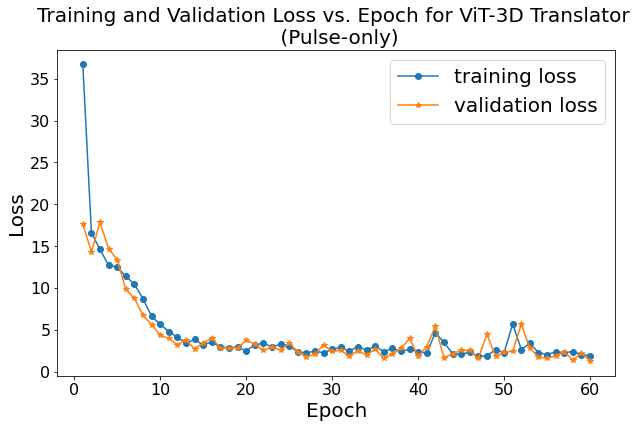

In [140]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(epochs[:60], train_losses[:60], label = 'training loss', marker = 'o')
plt.plot(epochs[:60], val_losses[:60], label = 'validation loss', marker = "*")
plt.legend(fontsize = 20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Loss", fontsize = 20)
plt.title("Training and Validation Loss vs. Epoch for ViT-3D Translator \n (Pulse-only)", fontsize = 20)

In [107]:
min(val_losses)

0.03302317339306076

In [110]:
import numpy as np
np.argmin(val_losses)

97

In [132]:
path = '/Users/rishabhsharma/Desktop/UR_MSDS_Fall_2024/Capstone/LLE/ViT_AE_prototype/Results/first_pulse_only/val_losses.npy'
np.save(path, val_losses)